# Experiment with dropout rate in linear layers

# Imports

In [1]:
! pip install torch-summary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import json
from torchsummary import summary
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
import librosa.display
import math
import os
from textwrap import dedent

IRMAS_PATH = "/content/drive/MyDrive/ITCS 5156 project/IRMAS dataset/IRMAS-TrainingData/"
JSON_PATH = "/content/drive/MyDrive/ITCS 5156 project/IRMAS dataset/json_files/"
filename = "irmas_data_mfcc13_hop_length256_n_fft2048.json"

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Dataset / preprocessing

In [3]:
class IRMASDataset(Dataset):
  def __init__(self, JSON_PATH, filename, transform=None):
    with open(JSON_PATH + filename, "r") as f:
      self.irmas_data = json.load(f)
    self.metadata = self.irmas_data.pop('metadata') 
    self.instruments = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax",
    "tru", "vio", "voi"]
    self.encoder = LabelEncoder()
    self.encoder.fit(self.instruments)

  def __len__(self):
    return len(self.irmas_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = np.array(idx.tolist())

    mfccs = np.array(self.irmas_data[str(idx)]['mfccs'])[np.newaxis,...]

    primary_instrument = self.encoder.transform(
      [np.array(self.irmas_data[str(idx)]['primary_instrument'])]
    )
    sample = {'mfccs': mfccs, 'instrument': primary_instrument, 'metadata': self.metadata}
    return sample

def prep_dataset(filename, val_split=0.2, batch_size=1):

  dataset = IRMASDataset(JSON_PATH=JSON_PATH, filename=filename)
  train_set, val_set = random_split(dataset, [round(len(dataset) * (1-val_split)), round(len(dataset)*val_split)])

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1)

  return train_loader, val_loader, dataset

# Architectures

In [4]:
class ConvBlock(nn.Module):
  """Convolutional block with conv2d, linear activation, max pooling, and batch norm
  """
  def __init__(self, in_channels, out_channels, conv_kernel_size=3,
               conv_stride=1, conv_padding=0,
               inc_pool=True, pool_kernel_size=2, pool_stride=2):
    super(ConvBlock, self).__init__()
    if inc_pool:
      self.conv_block = nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                    kernel_size=conv_kernel_size, stride=conv_stride,
                    padding=conv_padding),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride),
          nn.BatchNorm2d(num_features=out_channels)
      ) 
    else:
      self.conv_block = nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                    kernel_size=conv_kernel_size, stride=conv_stride,
                    padding=conv_padding),
          nn.ReLU(),
          nn.BatchNorm2d(num_features=out_channels)
      ) 

  def forward(self, x):
    x = self.conv_block(x)
    return x

class LinearBlock(nn.Module):
  """Linear block with dense layer, relu, batch norm, then dropout
  """

  def __init__(self, in_features, out_features, dropout_prob=0):
    super(LinearBlock, self).__init__()
    self.linear_block = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=out_features),
        nn.ReLU(),
        nn.BatchNorm1d(num_features=out_features),
        nn.Dropout(p=dropout_prob)
    )

  def forward(self, x):
    x = self.linear_block(x)
    return x

class HeadBlock(nn.Module):
  """Linear block with softmax output"""
  def __init__(self, in_features):
    super(HeadBlock, self).__init__()
    self.head_block = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=11),
        #nn.Softmax()
    )

  def forward(self, x):
    x = self.head_block(x)
    return x

class Conv1Layer(nn.Module):

  def __init__(self, single_sample, channels=[8],
               conv_kernel_sizes=[3],
               conv_strides=[1],
               conv_paddings=[0],
               pool_masks=[True],
               pool_kernel_sizes=[2],
               pool_strides=[2],
               linear_features=[128, 64],
               dropout_probs=[0, 0]):

    super(Conv1Layer, self).__init__()

    # convolutional blocks
    self.conv1 = ConvBlock(in_channels=1, out_channels=channels[0],
                           conv_kernel_size=conv_kernel_sizes[0],
                           conv_stride=conv_strides[0],
                           conv_padding=conv_paddings[0],
                           inc_pool=pool_masks[0],
                           pool_kernel_size=pool_kernel_sizes[0],
                           pool_stride=pool_strides[0])
  
    # run a single sample through the convolutional block to get output size
    # https://discuss.pytorch.org/t/convolution-and-pooling-layers-need-a-method-to-calculate-output-size/21895
    sample_output1 = self.conv1(torch.from_numpy(
        single_sample[np.newaxis,...].astype(np.float32)))
  
    sample_flattened = sample_output1.flatten(start_dim=1)
 
    # linear blocks
    self.linear1 = LinearBlock(in_features=(sample_flattened.shape[1]),
                                            out_features=(linear_features[0]),
                                            dropout_prob=dropout_probs[0])
    self.linear2 = LinearBlock(in_features=(linear_features[0]),
                                            out_features=(linear_features[1]),
                                            dropout_prob=dropout_probs[1])
    self.head = HeadBlock(in_features=(linear_features[1]))

  def forward(self, x):
    x = self.conv1(x)
    x = x.flatten(start_dim=1)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.head(x)
    return x

class Conv3Layer(nn.Module):
  def __init__(self, single_sample, channels=[8, 16, 32],
               conv_kernel_sizes=[3, 3, 3],
               conv_strides=[1, 1, 1],
               conv_paddings=[0, 0, 1,],
               pool_masks=[True, False, False],
               pool_kernel_sizes=[2, 2, 2],
               pool_strides=[2, 2, 2],
               linear_features=[128, 64],
               dropout_probs=[0, 0]):
    super(Conv3Layer, self).__init__()

    self.conv1 = ConvBlock(in_channels=1, out_channels=channels[0],
                           conv_kernel_size=conv_kernel_sizes[0],
                           conv_stride=conv_strides[0],
                           conv_padding=conv_paddings[0],
                           inc_pool=pool_masks[0],
                           pool_kernel_size=pool_kernel_sizes[0],
                           pool_stride=pool_strides[0])
    
    self.conv2 = ConvBlock(in_channels=channels[0], out_channels=channels[1],
                           conv_kernel_size=conv_kernel_sizes[1],
                           conv_stride=conv_strides[1],
                           conv_padding=conv_paddings[1],
                           inc_pool=pool_masks[1],
                           pool_kernel_size=pool_kernel_sizes[1],
                           pool_stride=pool_strides[1])

    self.conv3 = ConvBlock(in_channels=channels[1], out_channels=channels[2],
                           conv_kernel_size=conv_kernel_sizes[2],
                           conv_stride=conv_strides[2],
                           conv_padding=conv_paddings[2],
                           inc_pool=pool_masks[2],
                           pool_kernel_size=pool_kernel_sizes[2],
                           pool_stride=pool_strides[2])
    
    # calculate size for linear layers
    sample_output1 = self.conv1(torch.from_numpy(
        single_sample[np.newaxis,...].astype(np.float32)))
    sample_output2 = self.conv2(sample_output1)
    sample_output3 = self.conv3(sample_output2)
    sample_flattened = sample_output3.flatten(start_dim=1)

    # linear blocks
    self.linear1 = LinearBlock(in_features=(sample_flattened.shape[1]),
                                            out_features=(linear_features[0]),
                                            dropout_prob=dropout_probs[0])
    self.linear2 = LinearBlock(in_features=(linear_features[0]),
                                            out_features=(linear_features[1]),
                                            dropout_prob=dropout_probs[1])
    self.head = HeadBlock(in_features=(linear_features[1]))
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.flatten(start_dim=1)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.head(x)
    return x

class Conv5Layer(nn.Module):
  def __init__(self, single_sample, channels= [8, 8, 32, 32, 64],
               conv_kernel_sizes=[3, 3, 3, 3, 3],
               conv_strides=[1, 1, 1, 1, 1],
               conv_paddings=[0, 0, 1, 1, 1],
               pool_masks=[True, False, False, False, False],
               pool_kernel_sizes=[2, 2, 2, 2, 2],
               pool_strides=[2, 2, 2, 2, 2],
               linear_features=[128, 64],
               dropout_probs=[0, 0]):
    super(Conv5Layer, self).__init__()

    # convolutional layers
    self.conv1 = ConvBlock(in_channels=1, out_channels=channels[0],
                           conv_kernel_size=conv_kernel_sizes[0],
                           conv_stride=conv_strides[0],
                           conv_padding=conv_paddings[0],
                           inc_pool=pool_masks[0],
                           pool_kernel_size=pool_kernel_sizes[0],
                           pool_stride=pool_strides[0])
    
    self.conv2 = ConvBlock(in_channels=channels[0], out_channels=channels[1],
                           conv_kernel_size=conv_kernel_sizes[1],
                           conv_stride=conv_strides[1],
                           conv_padding=conv_paddings[1],
                           inc_pool=pool_masks[1],
                           pool_kernel_size=pool_kernel_sizes[1],
                           pool_stride=pool_strides[1])

    self.conv3 = ConvBlock(in_channels=channels[1], out_channels=channels[2],
                           conv_kernel_size=conv_kernel_sizes[2],
                           conv_stride=conv_strides[2],
                           conv_padding=conv_paddings[2],
                           inc_pool=pool_masks[2],
                           pool_kernel_size=pool_kernel_sizes[2],
                           pool_stride=pool_strides[2])
    
    self.conv4 = ConvBlock(in_channels=channels[2], out_channels=channels[3],
                           conv_kernel_size=conv_kernel_sizes[3],
                           conv_stride=conv_strides[3],
                           conv_padding=conv_paddings[3],
                           inc_pool=pool_masks[3],
                           pool_kernel_size=pool_kernel_sizes[3],
                           pool_stride=pool_strides[3])
    
    self.conv5 = ConvBlock(in_channels=channels[3], out_channels=channels[4],
                           conv_kernel_size=conv_kernel_sizes[4],
                           conv_stride=conv_strides[4],
                           conv_padding=conv_paddings[4],
                           inc_pool=pool_masks[4],
                           pool_kernel_size=pool_kernel_sizes[4],
                           pool_stride=pool_strides[4])
    
    # calculate size for linear layers
    sample_output1 = self.conv1(torch.from_numpy(
        single_sample[np.newaxis,...].astype(np.float32)))
    sample_output2 = self.conv2(sample_output1)
    sample_output3 = self.conv3(sample_output2)
    sample_output4 = self.conv4(sample_output3)
    sample_output5 = self.conv5(sample_output4)
    sample_flattened = sample_output5.flatten(start_dim=1)


    # linear blocks
    self.linear1 = LinearBlock(in_features=(sample_flattened.shape[1]),
                                            out_features=(linear_features[0]),
                                            dropout_prob=dropout_probs[0])
    self.linear2 = LinearBlock(in_features=(linear_features[0]),
                                            out_features=(linear_features[1]),
                                            dropout_prob=dropout_probs[1])
    self.head = HeadBlock(in_features=(linear_features[1]))
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = x.flatten(start_dim=1)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.head(x)
    return x

# Train loop

In [5]:
def train_model(filename="irmas_data_mfcc13_hop_length256_n_fft2048", model_id="TestModel",
                num_epochs=2, interval=16, lr=0.001, batch_size=64,
                val_split=0.2, save_checkpoint=False, checkpoint_path="",
                notes="", checkpoint_name="utitled.pt", criterion=torch.nn.NLLLoss(),
                patience=None, min_epochs=5, buffer=0.05, dropout_prob=None,
                model_args={}, experiment_params={}):
  """Model training loop for music analysis project. Currently, this loop only supports
  models that take input in the shape [mini_batch, channels, L, W].

  :param filename:
  :param model_id:
  :param num_epochs:
  :param interval:
  :param lr:
  :param batch_size:
  :param val_split:
  :param save_checkpoint:
  :param checkpoint_path:
  :param notes:
  :param checkpoint name:
  :param criterion:
  :param patience: If validation loss does not improve over this many epochs, stop training
  """

  # Initialize device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print("device: ", device)
  
  # get train and validation set, print metadata
  train_loader, val_loader, dataset = prep_dataset(
      filename=filename, batch_size=batch_size, val_split=val_split)

  print("dataset metadata: ", dataset.metadata)

  # get number of train and validdation samples
  train_samples = round(len(dataset) * (1-val_split))
  val_samples = round(len(dataset)*val_split)

  # initialize loss history and accuracy history for each epoch
  # this is the stored history for the train and validation metrics
  epoch_hist = []
  avg_train_loss_hist = []  # training loss for each epoch
  std_train_loss_hist = []
  avg_val_loss_hist = []    # validation loss for each epoch
  std_val_loss_hist = []
  train_acc_hist = []       # training accuracy for each epoch
  train_prec_hist = []
  train_recall_hist = []
  train_f1_hist = []
  val_acc_hist = []         # validation accuracy for each epoch
  val_prec_hist = []
  val_recall_hist = []
  val_f1_hist = []


  # get one sample to load initial shape for neural net
  single_sample = dataset[0]
  one_mfcc = np.array(single_sample['mfccs'])
  print("train model: data loaders initialized")
  print("sample shape = ", one_mfcc.shape)

  # initialize model
  #model = models_dict[model_id](one_mfcc, dropout_prob).to(device)
  model = models_dict[model_id](one_mfcc, **model_args).to(device)
  print("model loaded")
  summary_str = str(summary(model, one_mfcc.shape, verbose=0))

  print(summary_str)

  # initialize optimizer and criterion
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  print("criterion: ", criterion)

  n_train_steps = len(train_loader)
  n_val_steps = len(val_loader)

  ### loop epochs
  for epoch in range(num_epochs):
    print("\n\ntraining epoch: ", epoch)
    epoch_hist.append(epoch+1)
    epoch_time_start = time.time()
    interval_time_start = time.time()
    model.to(device)

    # at the start of the epoch, set all tracked params to zero
    train_losses = []
    val_losses = []
    inter_epoch_loss = []
    train_num_correct = 0
    val_num_correct = 0

    # set params to be tracked within the epoch ("inter-epoch")
    # these will be outputted at each interval, but not saved
    inter_epoch_num_correct = 0

    ### Training loop
    model.train()
    print("model set to train")
    train_preds = []
    train_targets = []
    for i, sample in enumerate(train_loader):

      # prep input and target tensor
      input_tensor = torch.from_numpy(
          np.array(sample['mfccs']).astype(np.float32)).to(device)
      targets = sample['instrument']
      target_tensor = torch.squeeze(torch.tensor(targets), dim=1)
      #print("target tensor after processing: ", target_tensor)
      train_targets.extend(list(targets.numpy()))
      # make predictions
      predictions = torch.squeeze(model(input_tensor).to('cpu'), dim=1)

      # compute loss and do back-propagation
      loss = criterion(predictions, target_tensor)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # append the loss to overall 
      train_losses.append(loss.item())
      inter_epoch_loss.append(loss.item())

      # compute accuracies
      with torch.no_grad():
        predictions_arr = predictions.numpy()
        preds = [np.argmax(predictions_arr[i]) 
          for i in range(len(target_tensor))]
        # inter-epoch accuracy (reset this at each interval)
        inter_epoch_num_correct += np.sum([target_tensor[i] == np.argmax(predictions[i])
          for i in range(len(target_tensor))])
        
        # epoch accuracy (this is tracked and saved)
        train_num_correct += np.sum([target_tensor[i] == np.argmax(predictions[i])
          for i in range(len(target_tensor))])
        #print("debugging in epoch: preds = ", preds)
        train_preds.extend(preds)

      # print step info
      if i % interval == 0:

        # time elapsed
        interval_time_end = time.time()

        # compute mean and std of losses
        inter_epoch_loss_avg = np.mean(inter_epoch_loss)
        inter_epoch_loss_std = np.std(inter_epoch_loss)
        
        # compute inter-epoch accuracy
        # note, this accuracy may be incorrect at the end of each epoch
        # when the batch size is slightly different
        acc = inter_epoch_num_correct / (interval*batch_size)
        print(f"Epoch [{epoch+1}/{num_epochs}], step [{i+1}/{n_train_steps}], ",
              f"Loss: {inter_epoch_loss_avg:.4f} +/- {inter_epoch_loss_std:.4f}, ",
              f"accuracy: {acc}, "
              f"time elapsed = {interval_time_end-interval_time_start}s")
        interval_time_start = time.time()

        # reset inter_epoch metrics
        inter_epoch_num_correct = 0
        inter_epoch_loss = []

    ### training loop finished
    # append the accuracy
    train_acc_hist.append(train_num_correct / train_samples)

    # calculate classification metrics
    train_targets = np.array(train_targets).ravel()
    train_preds = np.array(train_preds).ravel()
    # print("debugging: train targets: ", train_targets)
    # print("debugging: train predictions: ", train_preds)
    train_prec, train_recall, train_f1, _ = precision_recall_fscore_support(train_targets, train_preds,
                                                       average='micro')

    ### Validation loop
    model.eval()
    print("model set to eval")
    val_preds = []
    val_targets = []
    with torch.no_grad():

      num_correct = 0
      for i, sample in enumerate(val_loader):
        
        # prep input and target tensor
        input_tensor = torch.from_numpy(
            np.array(sample['mfccs']).astype(np.float32)).to(device)
        targets = sample['instrument']
        val_targets.extend(list(targets.numpy()))
        target_tensor = torch.squeeze(torch.tensor(targets), dim=1)
        #target_tensor = torch.squeeze(torch.tensor(sample['instrument']), dim=1)

        # make predictions
        predictions = torch.squeeze(model(input_tensor).to('cpu'), dim=1)

        # compute and append losses
        loss = criterion(predictions, target_tensor)
        val_losses.append(loss.item())

        predictions_arr = predictions.numpy()
        preds = [np.argmax(predictions_arr[i]) 
          for i in range(len(target_tensor))]
        val_preds.extend(preds)
        # get num correct to comput accuracy
        val_num_correct += np.sum([target_tensor[i] == np.argmax(predictions[i])
          for i in range(len(target_tensor))])
      
      ### validation loop finished. prep model and metrics for saving
      # calculate validation accuracy
      val_acc_hist.append(val_num_correct / val_samples)
      val_targets = np.array(val_targets).ravel()
      val_preds = np.array(val_preds).ravel()
      # print("debugging: train targets: ", train_targets)
      # print("debugging: train predictions: ", train_preds)
      val_prec, val_recall, val_f1, _ = precision_recall_fscore_support(val_targets, val_preds,
                                                       average='micro')
      # calculate mean and standard deviation of losses
      avg_train_loss = np.mean(train_losses)
      std_train_loss = np.std(train_losses)
      avg_val_loss = np.mean(val_losses)
      std_val_loss = np.std(val_losses)

      # append mean and standard deviation to histories
      avg_train_loss_hist.append(avg_train_loss) 
      std_train_loss_hist.append(std_train_loss)  
      avg_val_loss_hist.append(avg_val_loss)
      std_val_loss_hist.append(std_val_loss)

      train_prec_hist.append(train_prec)
      train_recall_hist.append(train_recall)
      train_f1_hist.append(train_f1)

      val_prec_hist.append(val_prec)
      val_recall_hist.append(val_recall)
      val_f1_hist.append(val_f1)
    
    ### epoch training finished, output results and save checkpoint

    # text output
    epoch_time_end = time.time()
    print(f"\nEPOCH FINISHED: , ",
          f"training: acc = {train_acc_hist[-1]}, ",
          f"precision = {train_prec_hist[-1]}",
          f"recall = {train_recall_hist[-1]}",
          f"f1 = {train_f1_hist[-1]}",
          f"::: val: acc = {val_acc_hist[-1]}, ",
          f"precision = {val_prec_hist[-1]}",
          f"recall = {val_recall_hist[-1]}",
          f"time elapsed = {epoch_time_end-epoch_time_start}s")
    
    # make a plot
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    #ax.scatter(epoch_hist, avg_train_loss_hist, c='r', label="train loss", )
    ax[0].plot(epoch_hist, avg_train_loss_hist, 'ro--', label="train loss", )
    ax[0].errorbar(x=epoch_hist, y=avg_train_loss_hist, yerr=std_train_loss_hist,
                capsize=5, ls='none', color='r')

    # ax.scatter(epoch_hist, avg_val_loss_hist, c='b', label="val loss", )
    ax[0].plot(epoch_hist, avg_val_loss_hist, 'ko--', label="val loss", )
    ax[0].errorbar(x=epoch_hist, y=avg_val_loss_hist, yerr=std_val_loss_hist,
                capsize=5, ls='none', color='k')
    
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].legend()
    

    ax[1].plot(epoch_hist, train_acc_hist, 'r-.', label="train accuracy", 
                   marker='s')

    ax[1].plot(epoch_hist, val_acc_hist, 'k-.', label="val accuracy",
                   marker='s')
    ax[1].set_ylabel("accuracy")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylim([0, 1])
    ax[1].legend()
    fig.tight_layout(pad=1)
    plt.show()

    # check validation loss if we need to stop training
    # print("validation loss hist: ", avg_val_loss_hist)
    # if (epoch > patience) and all(avg_val_loss_hist[-1-i] >= avg_val_loss_hist[-1-i-1]
    #                               for i in range(patience)):
    model.to('cpu')
    if (epoch > min_epochs) and (
        avg_val_loss_hist[-1] > (std_val_loss_hist[-1] + std_train_loss_hist[-1] + avg_train_loss_hist[-1] + buffer)):
        #avg_val_loss_hist[-1] > (std_val_loss_hist[-1] + std_train_loss_hist[-1] + buffer)):
                    # and any(avg_val_loss_hist[-1-i] >= avg_val_loss_hist[-1-i-1]
                    #                                   for i in range(patience)):
      notes = notes + "\n\n stopped early"
      # save model
      # TODO: refactor this so torch.save isn't repeated
      if save_checkpoint:
        torch.save({
            'filename': filename,
            'epochs': epoch_hist,
            'model_id': model_id,
            'model_state_dict': model.state_dict(),
            'avg_train_loss_hist': avg_train_loss_hist,
            'std_train_loss_hist': std_train_loss_hist,
            'avg_val_loss_hist': avg_val_loss_hist,
            'std_val_loss_hist': std_val_loss_hist,
            'train_acc_hist': train_acc_hist,
            'val_acc_hist': val_acc_hist,
            'train_prec_hist': train_prec_hist,
            'train_recall_hist': train_recall_hist,
            'train_f1_hist': train_f1_hist,
            'val_prec_hist': val_prec_hist,
            'val_recall_hist': val_recall_hist,
            'val_f1_hist': val_f1_hist,
            'dataset_info': dataset.metadata,
            'notes': notes,
            'summary': summary_str,
            'experiment_params': experiment_params,
        }, checkpoint_path+checkpoint_name)
        print("model saved")
        print("stopping early")
        break

    # save model
    if save_checkpoint:
      torch.save({
          'filename': filename,
          'epochs': epoch_hist,
          'model_id': model_id,
          'model_state_dict': model.state_dict(),
          'avg_train_loss_hist': avg_train_loss_hist,
          'std_train_loss_hist': std_train_loss_hist,
          'avg_val_loss_hist': avg_val_loss_hist,
          'std_val_loss_hist': std_val_loss_hist,
          'train_acc_hist': train_acc_hist,
          'val_acc_hist': val_acc_hist,
          'train_prec_hist': train_prec_hist,
          'train_recall_hist': train_recall_hist,
          'train_f1_hist': train_f1_hist,
          'val_prec_hist': val_prec_hist,
          'val_recall_hist': val_recall_hist,
          'val_f1_hist': val_f1_hist,
          'dataset_info': dataset.metadata,
          'notes': notes,
          'summary': summary_str,
          'experiment_params': experiment_params,
      }, checkpoint_path+checkpoint_name)
      print("model saved")

# Get a sample for debugging

In [6]:
train_loader, val_loader, dataset = prep_dataset(
      filename=filename, batch_size=5, val_split=0.2)
single_sample = dataset[0]

one_mfcc = np.array(single_sample['mfccs'])
one_mfcc.shape

(1, 13, 517)

# Test architectures

In [7]:
models_dict = {
    "Conv_1_layer": Conv1Layer,
    "Conv_3_layer": Conv3Layer,
    "Conv_5_layer": Conv5Layer,
}


### params to vary
#all_channels = [[16, 32, 32, 64, 128], [32, 64, 64, 64, 128], [64, 64, 64, 128, 128]]
# all_channels = [
#   [[8], [16], [32], [64], [128]],

#   [[8, 8, 16], [8, 16, 32], [8, 16, 64], [8, 32, 128], [8, 8, 128], [8, 128, 128],
#    [32, 32, 64], [32, 64, 128], [32, 128, 128], 
#    [64, 64, 128], [128, 128, 128]],
  
#   [[8, 8, 8, 8, 8], [8, 8, 16, 16, 32], [8, 8, 16, 32, 64], [8, 8, 32, 64, 128],
#    [8, 16, 32, 64, 128], [8, 32, 32, 64, 128],

#    [16, 32, 32, 64, 128], [32, 64, 64, 64, 128], [64, 64, 64, 128, 128]]
# ]
all_channels = [[16, 32, 32, 64, 128]]

model_ids = ["Conv_1_layer", "Conv_3_layer", "Conv_5_layer"]

#layers = [1, 3, 5]
layers = [5]
pool_masks=[
            [True],
            [True, True, True],
            [True, True, True, True, True],
]
pool_kernel_sizes=[
                   [(1, 2)],
                   [(1, 2), (1, 2), (1, 2)],
                   [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
]

pool_strides=[
              [(1, 10)],
              [(1, 5), (1, 5), (1, 5)],
              [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)]
]

dropouts = [
      [0, 0],
      [0.1, 0],
      [0.25, 0],
      [0.5, 0],
      [0, 0.1],
      [0.1, 0.1],
      [0.25, 0.1],
      [0.5, 0.1],
      [0, 0.25],
      [0.1, 0.25],
      [0.25, 0.25],
      [0.5, 0.25],
      [0, 0.5],
      [0.1, 0.5],
      [0.25, 0.5],
      [0.5, 0.5]
]

for i, drop in enumerate(dropouts):
  
  model = models_dict['Conv_5_layer'](one_mfcc,
      channels = [16, 32, 32, 64, 128],
      conv_paddings = [1, 1, 1, 1, 1],
      pool_masks = [True, True, True, True, True],
      pool_kernel_sizes = pool_kernel_sizes[2],
      pool_strides = pool_strides[2],
      dropout_probs = drop)
  summary_str = summary(model, one_mfcc.shape, verbose=0)
  print(summary_str)
# for i, model_id in enumerate(model_ids):
#   print("testing model: ", model_id)

#   for channel in all_channels:
#     print("*"*80)
#     print("*"*80, "\n")
#     print("channels: ", channel)
#     print("pool masks: ", pool_masks[i])
#     print("pool kernel sizes: ", pool_kernel_sizes[i])
#     print("pool strides: ", pool_strides[i])

#     model = models_dict[model_id](one_mfcc, channels=channel,
#         conv_paddings=[1, 1, 1, 1, 1],
#         pool_masks=pool_masks[2],
#         pool_kernel_sizes=pool_kernel_sizes[2],
#         pool_strides=pool_strides[2]
#         dropouts = dropouts[]
#         )
#     summary_str = summary(model, one_mfcc.shape, verbose=0)
#     print(summary_str)


Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─ReLU: 3-6                    [-1, 32, 13, 258]         --
|    |    └─MaxPool2d: 3-7               [-1, 32, 13, 129]         --
|    |    └─BatchNorm2d: 3-8             [-1, 32, 13, 129]         64
├─ConvBlock: 1-3                         [-1, 32, 13, 64]          --
|    └─Sequ

# Run the pipeline

(1, 13, 517)
running model: drop_prob = [0, 0]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─ReLU: 3-6                    [-1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/100], step [1/84],  Loss: 2.6703 +/- 0.0000,  accuracy: 0.0068359375, time elapsed = 0.44476866722106934s
Epoch [1/100], step [17/84],  Loss: 2.0977 +/- 0.1369,  accuracy: 0.291015625, time elapsed = 0.9229526519775391s
Epoch [1/100], step [33/84],  Loss: 1.9346 +/- 0.0828,  accuracy: 0.357421875, time elapsed = 0.9104645252227783s
Epoch [1/100], step [49/84],  Loss: 1.8670 +/- 0.0833,  accuracy: 0.376953125, time elapsed = 0.9199423789978027s
Epoch [1/100], step [65/84],  Loss: 1.7970 +/- 0.0872,  accuracy: 0.4169921875, time elapsed = 0.9315962791442871s
Epoch [1/100], step [81/84],  Loss: 1.7059 +/- 0.1022,  accuracy: 0.4580078125, time elapsed = 0.9421424865722656s
model set to eval


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:189: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



EPOCH FINISHED: ,  training: acc = 0.3772142457579713,  precision = 0.3772142457579713 recall = 0.3772142457579713 f1 = 0.3772142457579713 ::: val: acc = 0.453392990305742,  precision = 0.453392990305742 recall = 0.453392990305742 time elapsed = 6.694509744644165s


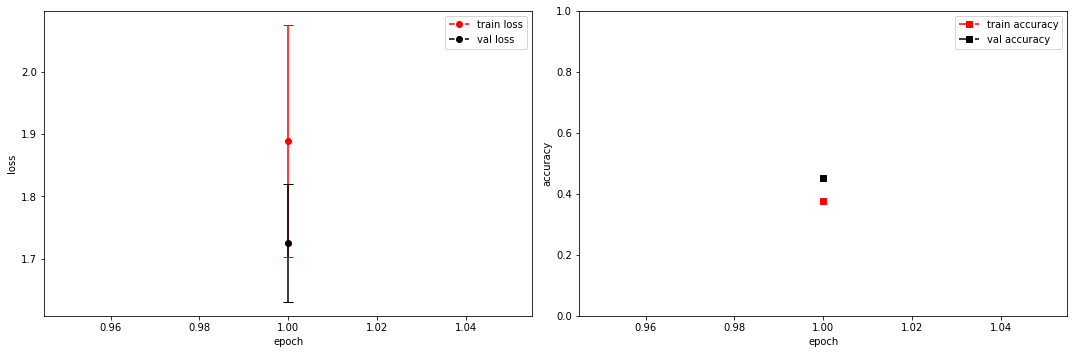

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.6487 +/- 0.0000,  accuracy: 0.0283203125, time elapsed = 0.24596452713012695s
Epoch [2/100], step [17/84],  Loss: 1.5160 +/- 0.0928,  accuracy: 0.5283203125, time elapsed = 0.9481105804443359s
Epoch [2/100], step [33/84],  Loss: 1.5187 +/- 0.0675,  accuracy: 0.537109375, time elapsed = 0.9165468215942383s
Epoch [2/100], step [49/84],  Loss: 1.4787 +/- 0.1234,  accuracy: 0.5380859375, time elapsed = 0.9094922542572021s
Epoch [2/100], step [65/84],  Loss: 1.4834 +/- 0.1091,  accuracy: 0.5283203125, time elapsed = 0.9196443557739258s
Epoch [2/100], step [81/84],  Loss: 1.4783 +/- 0.0628,  accuracy: 0.5341796875, time elapsed = 0.9222252368927002s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5316054447137796,  precision = 0.5316054447137796 recall = 0.5316054447137796 f1 = 0.5316054447137796 ::: val: acc = 0.4862043251304996,  precision = 0.4862043251304996 recall = 0.4862043251304996 time e

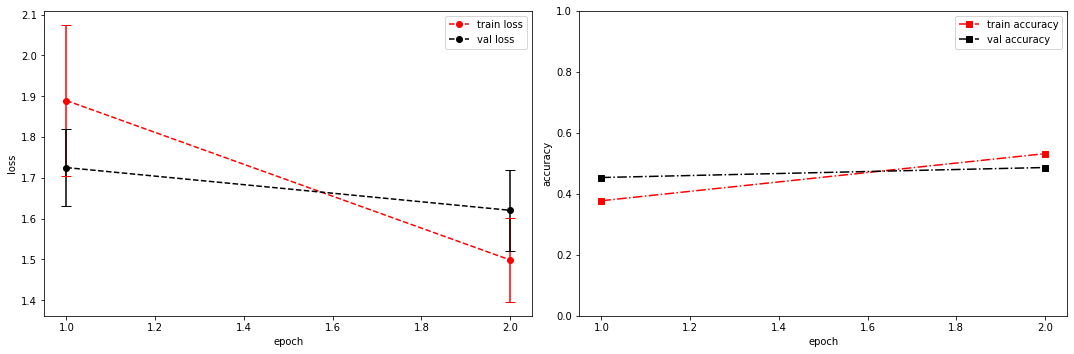

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.1959 +/- 0.0000,  accuracy: 0.04296875, time elapsed = 0.24879121780395508s
Epoch [3/100], step [17/84],  Loss: 1.1994 +/- 0.0823,  accuracy: 0.6796875, time elapsed = 0.8987836837768555s
Epoch [3/100], step [33/84],  Loss: 1.1548 +/- 0.0781,  accuracy: 0.70703125, time elapsed = 0.9014909267425537s
Epoch [3/100], step [49/84],  Loss: 1.1584 +/- 0.0836,  accuracy: 0.6923828125, time elapsed = 0.8728911876678467s
Epoch [3/100], step [65/84],  Loss: 1.1735 +/- 0.0847,  accuracy: 0.669921875, time elapsed = 0.9058427810668945s
Epoch [3/100], step [81/84],  Loss: 1.1880 +/- 0.0700,  accuracy: 0.6640625, time elapsed = 0.8973274230957031s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6818944620548201,  precision = 0.6818944620548201 recall = 0.6818944620548201 f1 = 0.6818944620548201 ::: val: acc = 0.5078299776286354,  precision = 0.5078299776286354 recall = 0.5078299776286354 time elapsed = 6

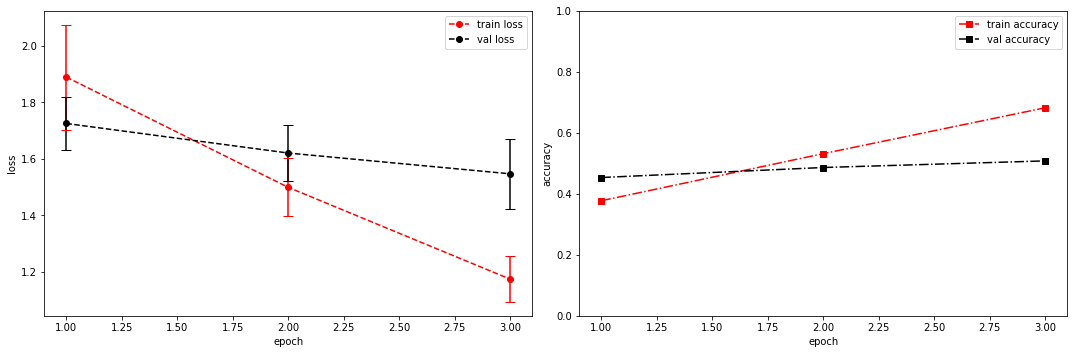

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 0.9285 +/- 0.0000,  accuracy: 0.048828125, time elapsed = 0.24255156517028809s
Epoch [4/100], step [17/84],  Loss: 0.8653 +/- 0.0528,  accuracy: 0.84375, time elapsed = 0.9162561893463135s
Epoch [4/100], step [33/84],  Loss: 0.8692 +/- 0.0648,  accuracy: 0.8212890625, time elapsed = 0.9129023551940918s
Epoch [4/100], step [49/84],  Loss: 0.8406 +/- 0.0642,  accuracy: 0.8349609375, time elapsed = 0.9130442142486572s
Epoch [4/100], step [65/84],  Loss: 0.8500 +/- 0.0619,  accuracy: 0.8251953125, time elapsed = 0.9052870273590088s
Epoch [4/100], step [81/84],  Loss: 0.8329 +/- 0.0553,  accuracy: 0.84375, time elapsed = 0.9029154777526855s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.8316240909938467,  precision = 0.8316240909938467 recall = 0.8316240909938467 f1 = 0.8316240909938467 ::: val: acc = 0.5011185682326622,  precision = 0.5011185682326622 recall = 0.5011185682326622 time elapsed = 6

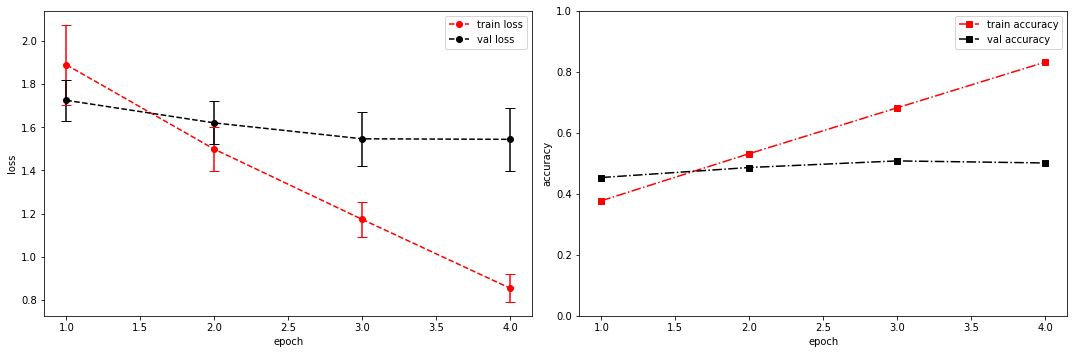

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 0.5935 +/- 0.0000,  accuracy: 0.0615234375, time elapsed = 0.2582685947418213s
Epoch [5/100], step [17/84],  Loss: 0.6029 +/- 0.0537,  accuracy: 0.9287109375, time elapsed = 0.9257068634033203s
Epoch [5/100], step [33/84],  Loss: 0.5788 +/- 0.0508,  accuracy: 0.94921875, time elapsed = 0.9353325366973877s
Epoch [5/100], step [49/84],  Loss: 0.5486 +/- 0.0543,  accuracy: 0.9501953125, time elapsed = 0.9168834686279297s
Epoch [5/100], step [65/84],  Loss: 0.5454 +/- 0.0414,  accuracy: 0.9462890625, time elapsed = 0.926471471786499s
Epoch [5/100], step [81/84],  Loss: 0.5564 +/- 0.0551,  accuracy: 0.9345703125, time elapsed = 0.929030179977417s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.94256945739325,  precision = 0.94256945739325 recall = 0.94256945739325 f1 = 0.94256945739325 ::: val: acc = 0.4988814317673378,  precision = 0.4988814317673378 recall = 0.4988814317673378 time elapsed = 6.5

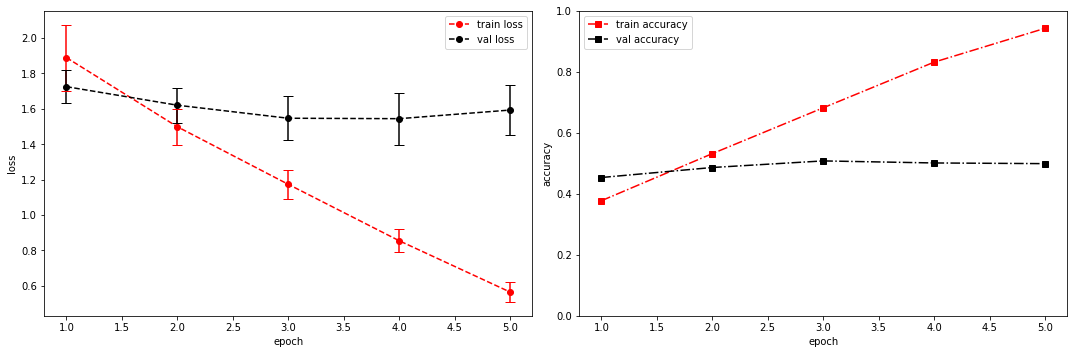

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 0.3559 +/- 0.0000,  accuracy: 0.0615234375, time elapsed = 0.25488829612731934s
Epoch [6/100], step [17/84],  Loss: 0.3941 +/- 0.0395,  accuracy: 0.9814453125, time elapsed = 0.8789920806884766s
Epoch [6/100], step [33/84],  Loss: 0.3696 +/- 0.0418,  accuracy: 0.9775390625, time elapsed = 0.8647923469543457s
Epoch [6/100], step [49/84],  Loss: 0.3511 +/- 0.0297,  accuracy: 0.9892578125, time elapsed = 0.8772623538970947s
Epoch [6/100], step [65/84],  Loss: 0.3276 +/- 0.0364,  accuracy: 0.9912109375, time elapsed = 0.8846466541290283s
Epoch [6/100], step [81/84],  Loss: 0.3397 +/- 0.0313,  accuracy: 0.984375, time elapsed = 0.8776228427886963s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9843371247436137,  precision = 0.9843371247436137 recall = 0.9843371247436137 f1 = 0.9843371247436137 ::: val: acc = 0.5294556301267711,  precision = 0.5294556301267711 recall = 0.5294556301267711 time elap

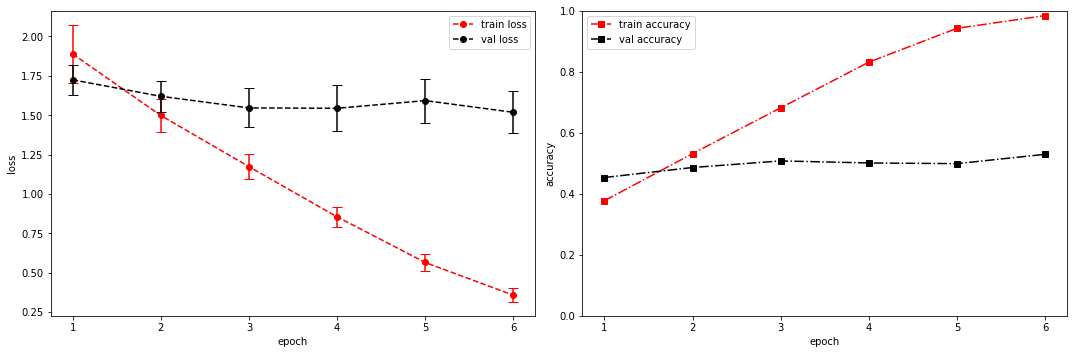

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.2706 +/- 0.0000,  accuracy: 0.0615234375, time elapsed = 0.2460787296295166s
Epoch [7/100], step [17/84],  Loss: 0.2447 +/- 0.0253,  accuracy: 1.0, time elapsed = 0.8807418346405029s
Epoch [7/100], step [33/84],  Loss: 0.2417 +/- 0.0251,  accuracy: 0.9970703125, time elapsed = 0.8757305145263672s
Epoch [7/100], step [49/84],  Loss: 0.2337 +/- 0.0349,  accuracy: 0.9931640625, time elapsed = 0.8828577995300293s
Epoch [7/100], step [65/84],  Loss: 0.2220 +/- 0.0322,  accuracy: 0.998046875, time elapsed = 0.8972573280334473s
Epoch [7/100], step [81/84],  Loss: 0.2256 +/- 0.0251,  accuracy: 0.99609375, time elapsed = 0.8802952766418457s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9962707439865747,  precision = 0.9962707439865747 recall = 0.9962707439865747 f1 = 0.9962707439865747 ::: val: acc = 0.5130499627143923,  precision = 0.5130499627143923 recall = 0.5130499627143923 time elapsed = 6.2

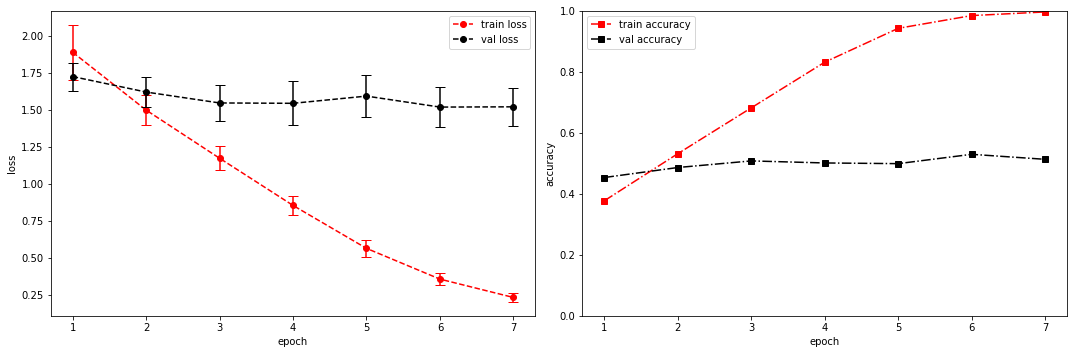

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0.1, 0]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─ReL

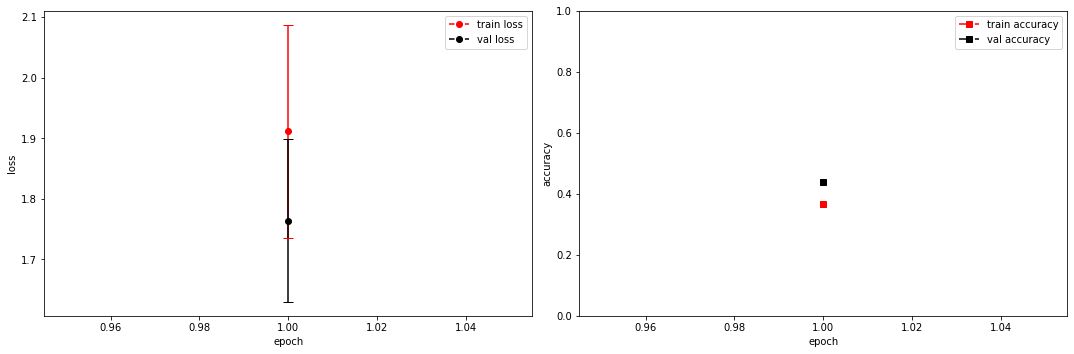

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.6723 +/- 0.0000,  accuracy: 0.029296875, time elapsed = 0.2654130458831787s
Epoch [2/100], step [17/84],  Loss: 1.5814 +/- 0.0965,  accuracy: 0.5244140625, time elapsed = 0.8935272693634033s
Epoch [2/100], step [33/84],  Loss: 1.5304 +/- 0.0627,  accuracy: 0.560546875, time elapsed = 0.8759510517120361s
Epoch [2/100], step [49/84],  Loss: 1.5081 +/- 0.0650,  accuracy: 0.5419921875, time elapsed = 0.896669864654541s
Epoch [2/100], step [65/84],  Loss: 1.4615 +/- 0.0958,  accuracy: 0.56640625, time elapsed = 0.9019486904144287s
Epoch [2/100], step [81/84],  Loss: 1.5025 +/- 0.1072,  accuracy: 0.5556640625, time elapsed = 0.8799829483032227s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5483870967741935,  precision = 0.5483870967741935 recall = 0.5483870967741935 f1 = 0.5483870967741935 ::: val: acc = 0.4489187173750932,  precision = 0.4489187173750932 recall = 0.4489187173750932 time elapse

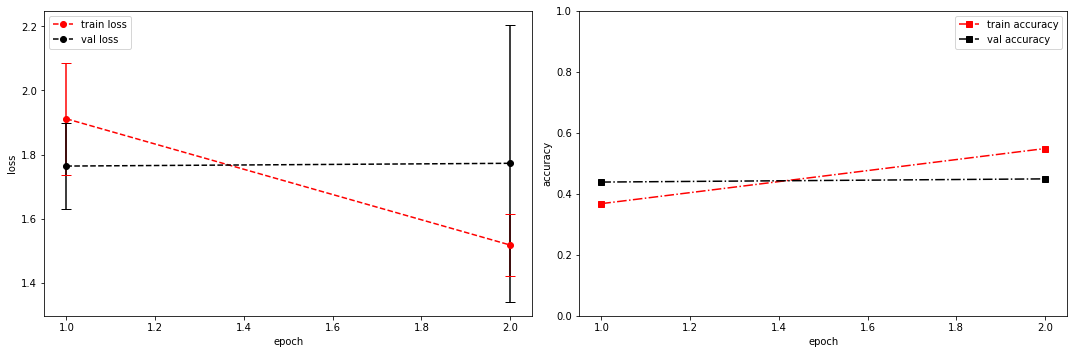

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.1572 +/- 0.0000,  accuracy: 0.044921875, time elapsed = 0.26371002197265625s
Epoch [3/100], step [17/84],  Loss: 1.2335 +/- 0.0730,  accuracy: 0.701171875, time elapsed = 0.8914287090301514s
Epoch [3/100], step [33/84],  Loss: 1.1984 +/- 0.0745,  accuracy: 0.701171875, time elapsed = 0.8899140357971191s
Epoch [3/100], step [49/84],  Loss: 1.1964 +/- 0.0786,  accuracy: 0.6884765625, time elapsed = 0.8932778835296631s
Epoch [3/100], step [65/84],  Loss: 1.1818 +/- 0.0872,  accuracy: 0.7119140625, time elapsed = 0.8784441947937012s
Epoch [3/100], step [81/84],  Loss: 1.1403 +/- 0.0691,  accuracy: 0.72265625, time elapsed = 0.8705708980560303s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.705015849338057,  precision = 0.705015849338057 recall = 0.705015849338057 f1 = 0.705015849338057 ::: val: acc = 0.49739000745712153,  precision = 0.49739000745712153 recall = 0.49739000745712153 time elapse

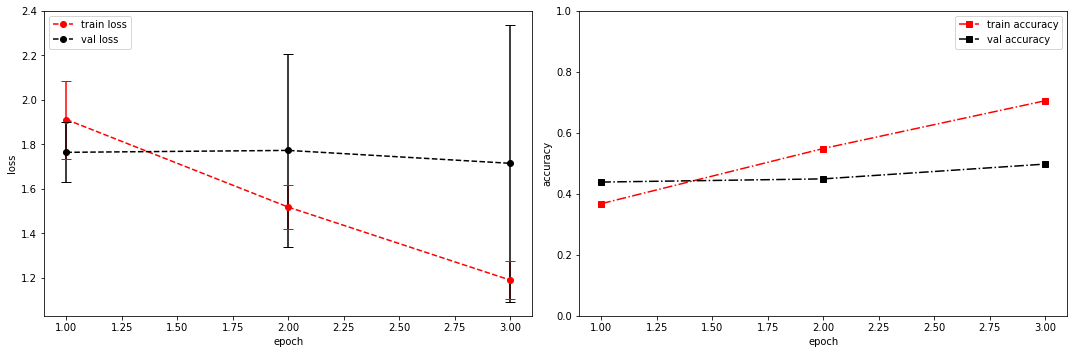

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 0.8788 +/- 0.0000,  accuracy: 0.0556640625, time elapsed = 0.25026535987854004s
Epoch [4/100], step [17/84],  Loss: 0.8788 +/- 0.0381,  accuracy: 0.8623046875, time elapsed = 0.8919720649719238s
Epoch [4/100], step [33/84],  Loss: 0.8439 +/- 0.0411,  accuracy: 0.8681640625, time elapsed = 0.8899846076965332s
Epoch [4/100], step [49/84],  Loss: 0.8606 +/- 0.0687,  accuracy: 0.8603515625, time elapsed = 0.8949511051177979s
Epoch [4/100], step [65/84],  Loss: 0.8330 +/- 0.0410,  accuracy: 0.8662109375, time elapsed = 0.8888201713562012s
Epoch [4/100], step [81/84],  Loss: 0.8244 +/- 0.0688,  accuracy: 0.8544921875, time elapsed = 0.8892841339111328s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.8636956927093045,  precision = 0.8636956927093045 recall = 0.8636956927093045 f1 = 0.8636956927093044 ::: val: acc = 0.4936614466815809,  precision = 0.4936614466815809 recall = 0.4936614466815809 time 

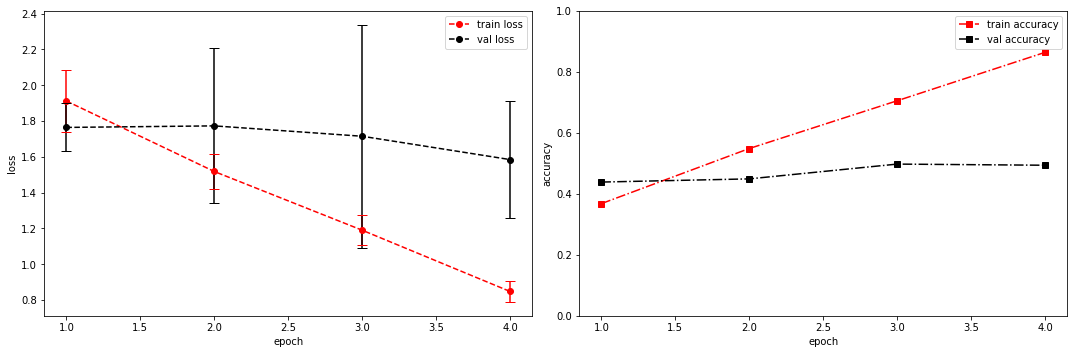

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 0.6325 +/- 0.0000,  accuracy: 0.0576171875, time elapsed = 0.2713356018066406s
Epoch [5/100], step [17/84],  Loss: 0.5931 +/- 0.0365,  accuracy: 0.955078125, time elapsed = 0.8919434547424316s
Epoch [5/100], step [33/84],  Loss: 0.5780 +/- 0.0414,  accuracy: 0.9677734375, time elapsed = 0.9026734828948975s
Epoch [5/100], step [49/84],  Loss: 0.5502 +/- 0.0491,  accuracy: 0.9580078125, time elapsed = 0.8886125087738037s
Epoch [5/100], step [65/84],  Loss: 0.5447 +/- 0.0404,  accuracy: 0.9580078125, time elapsed = 0.9024937152862549s
Epoch [5/100], step [81/84],  Loss: 0.5412 +/- 0.0312,  accuracy: 0.95703125, time elapsed = 0.8769283294677734s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9591646466529927,  precision = 0.9591646466529927 recall = 0.9591646466529927 f1 = 0.9591646466529927 ::: val: acc = 0.49217002237136465,  precision = 0.49217002237136465 recall = 0.49217002237136465 time e

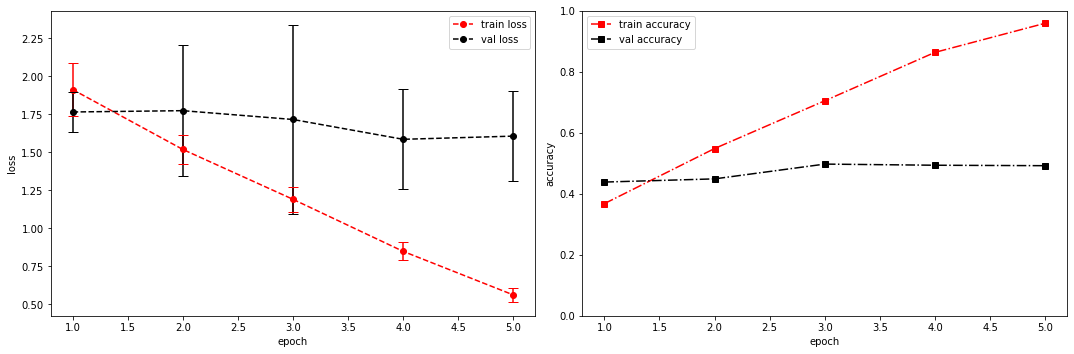

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 0.3718 +/- 0.0000,  accuracy: 0.0625, time elapsed = 0.25783514976501465s
Epoch [6/100], step [17/84],  Loss: 0.3938 +/- 0.0258,  accuracy: 0.98828125, time elapsed = 0.9236946105957031s
Epoch [6/100], step [33/84],  Loss: 0.3646 +/- 0.0340,  accuracy: 0.9912109375, time elapsed = 0.9149045944213867s
Epoch [6/100], step [49/84],  Loss: 0.3627 +/- 0.0249,  accuracy: 0.9921875, time elapsed = 0.9064474105834961s
Epoch [6/100], step [65/84],  Loss: 0.3529 +/- 0.0284,  accuracy: 0.98828125, time elapsed = 0.9080085754394531s
Epoch [6/100], step [81/84],  Loss: 0.3620 +/- 0.0292,  accuracy: 0.9912109375, time elapsed = 0.8905348777770996s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9903039343650941,  precision = 0.9903039343650941 recall = 0.9903039343650941 f1 = 0.9903039343650941 ::: val: acc = 0.49217002237136465,  precision = 0.49217002237136465 recall = 0.49217002237136465 time elapsed = 

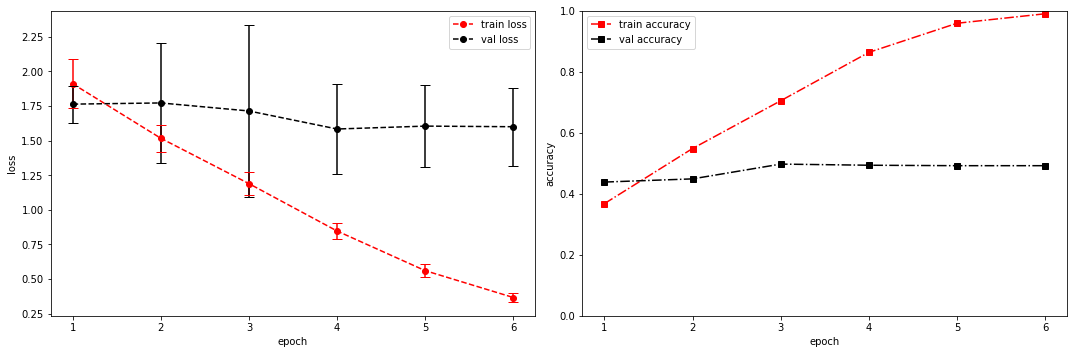

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.2815 +/- 0.0000,  accuracy: 0.0615234375, time elapsed = 0.2559781074523926s
Epoch [7/100], step [17/84],  Loss: 0.2660 +/- 0.0194,  accuracy: 0.9990234375, time elapsed = 0.8750944137573242s
Epoch [7/100], step [33/84],  Loss: 0.2567 +/- 0.0276,  accuracy: 0.998046875, time elapsed = 0.8803088665008545s
Epoch [7/100], step [49/84],  Loss: 0.2456 +/- 0.0253,  accuracy: 0.99609375, time elapsed = 0.8894424438476562s
Epoch [7/100], step [65/84],  Loss: 0.2354 +/- 0.0176,  accuracy: 0.998046875, time elapsed = 0.8899364471435547s
Epoch [7/100], step [81/84],  Loss: 0.2337 +/- 0.0192,  accuracy: 0.9951171875, time elapsed = 0.8640196323394775s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.997203057989931,  precision = 0.997203057989931 recall = 0.997203057989931 f1 = 0.997203057989931 ::: val: acc = 0.4981357196122297,  precision = 0.4981357196122297 recall = 0.4981357196122297 time elapsed =

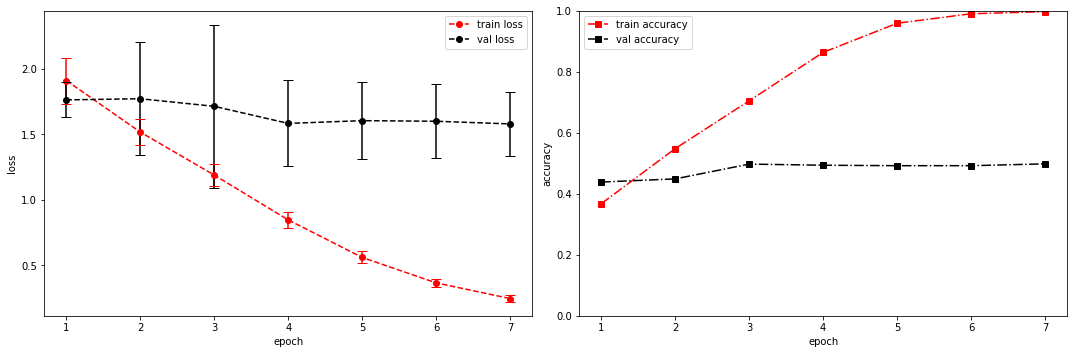

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0.25, 0]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─Re

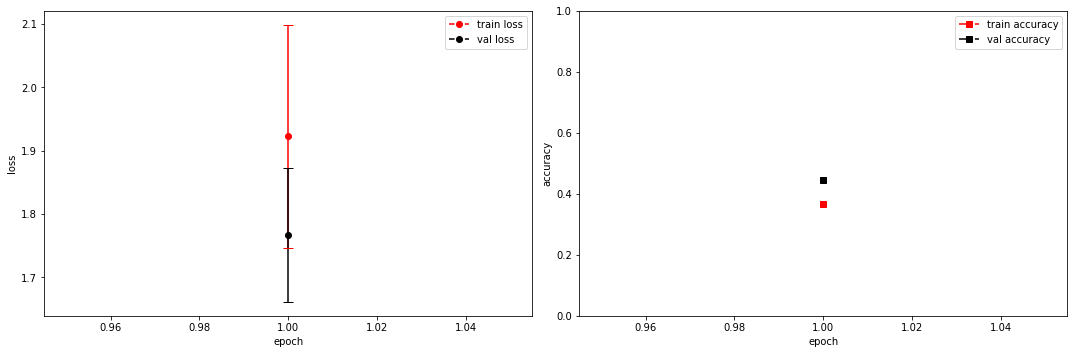

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.7218 +/- 0.0000,  accuracy: 0.03125, time elapsed = 0.2633364200592041s
Epoch [2/100], step [17/84],  Loss: 1.6221 +/- 0.1161,  accuracy: 0.5, time elapsed = 0.8931746482849121s
Epoch [2/100], step [33/84],  Loss: 1.6690 +/- 0.0932,  accuracy: 0.462890625, time elapsed = 0.8941240310668945s
Epoch [2/100], step [49/84],  Loss: 1.6009 +/- 0.0796,  accuracy: 0.5185546875, time elapsed = 0.8787534236907959s
Epoch [2/100], step [65/84],  Loss: 1.5583 +/- 0.0913,  accuracy: 0.5048828125, time elapsed = 0.9220168590545654s
Epoch [2/100], step [81/84],  Loss: 1.5931 +/- 0.0790,  accuracy: 0.513671875, time elapsed = 0.8951582908630371s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5012120082043632,  precision = 0.5012120082043632 recall = 0.5012120082043632 f1 = 0.5012120082043632 ::: val: acc = 0.4697986577181208,  precision = 0.4697986577181208 recall = 0.4697986577181208 time elapsed = 6.36977

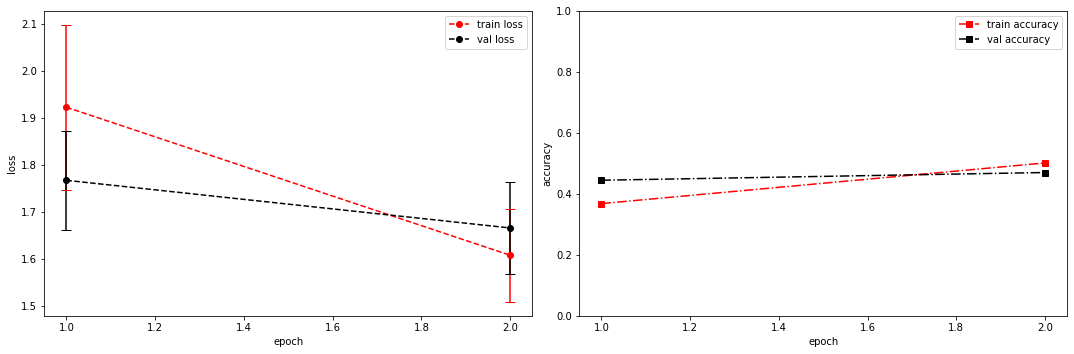

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.4297 +/- 0.0000,  accuracy: 0.0361328125, time elapsed = 0.2642066478729248s
Epoch [3/100], step [17/84],  Loss: 1.4230 +/- 0.0639,  accuracy: 0.5791015625, time elapsed = 0.9144814014434814s
Epoch [3/100], step [33/84],  Loss: 1.3708 +/- 0.0628,  accuracy: 0.6044921875, time elapsed = 0.8739120960235596s
Epoch [3/100], step [49/84],  Loss: 1.3734 +/- 0.0957,  accuracy: 0.5947265625, time elapsed = 0.886974573135376s
Epoch [3/100], step [65/84],  Loss: 1.3864 +/- 0.0926,  accuracy: 0.58984375, time elapsed = 0.8932797908782959s
Epoch [3/100], step [81/84],  Loss: 1.3983 +/- 0.1041,  accuracy: 0.5908203125, time elapsed = 0.869943380355835s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5894089129218721,  precision = 0.5894089129218721 recall = 0.5894089129218721 f1 = 0.5894089129218721 ::: val: acc = 0.46830723340790453,  precision = 0.46830723340790453 recall = 0.46830723340790453 time el

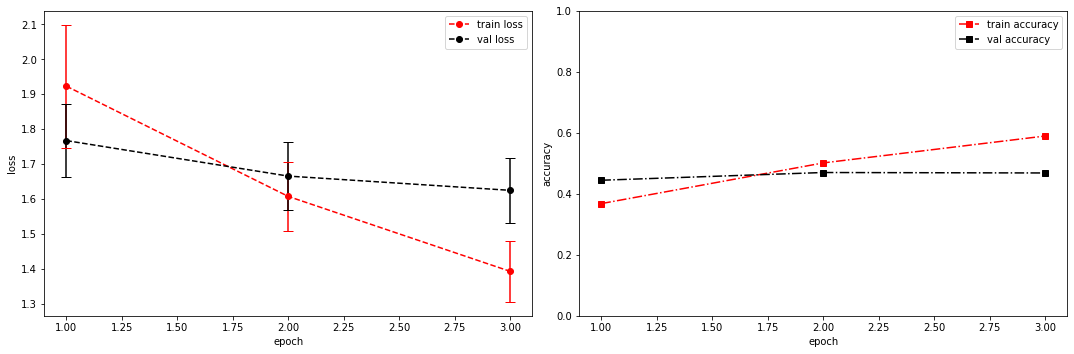

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.2928 +/- 0.0000,  accuracy: 0.0380859375, time elapsed = 0.251406192779541s
Epoch [4/100], step [17/84],  Loss: 1.1544 +/- 0.0678,  accuracy: 0.703125, time elapsed = 0.8962125778198242s
Epoch [4/100], step [33/84],  Loss: 1.1409 +/- 0.1091,  accuracy: 0.7333984375, time elapsed = 0.8994903564453125s
Epoch [4/100], step [49/84],  Loss: 1.1256 +/- 0.0788,  accuracy: 0.7099609375, time elapsed = 0.8901422023773193s
Epoch [4/100], step [65/84],  Loss: 1.1585 +/- 0.1025,  accuracy: 0.6865234375, time elapsed = 0.9084796905517578s
Epoch [4/100], step [81/84],  Loss: 1.1320 +/- 0.0759,  accuracy: 0.6904296875, time elapsed = 0.894442081451416s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.7033376841320157,  precision = 0.7033376841320157 recall = 0.7033376841320157 f1 = 0.7033376841320157 ::: val: acc = 0.4929157345264728,  precision = 0.4929157345264728 recall = 0.4929157345264728 time elapsed

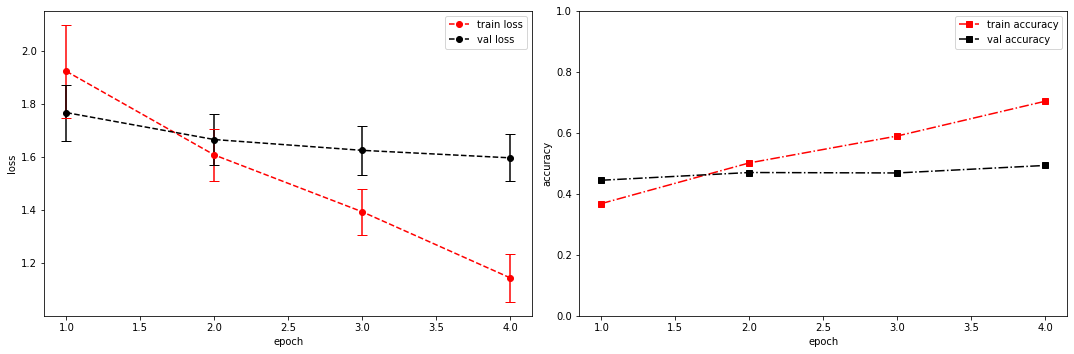

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 0.8397 +/- 0.0000,  accuracy: 0.052734375, time elapsed = 0.26276731491088867s
Epoch [5/100], step [17/84],  Loss: 0.9273 +/- 0.0586,  accuracy: 0.828125, time elapsed = 0.9313857555389404s
Epoch [5/100], step [33/84],  Loss: 0.9132 +/- 0.0572,  accuracy: 0.818359375, time elapsed = 0.9232773780822754s
Epoch [5/100], step [49/84],  Loss: 0.9085 +/- 0.0684,  accuracy: 0.810546875, time elapsed = 0.9028699398040771s
Epoch [5/100], step [65/84],  Loss: 0.8990 +/- 0.0844,  accuracy: 0.794921875, time elapsed = 0.8873205184936523s
Epoch [5/100], step [81/84],  Loss: 0.8655 +/- 0.0580,  accuracy: 0.8193359375, time elapsed = 0.8907794952392578s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.8124184225247063,  precision = 0.8124184225247063 recall = 0.8124184225247063 f1 = 0.8124184225247063 ::: val: acc = 0.4407158836689038,  precision = 0.4407158836689038 recall = 0.4407158836689038 time elapsed 

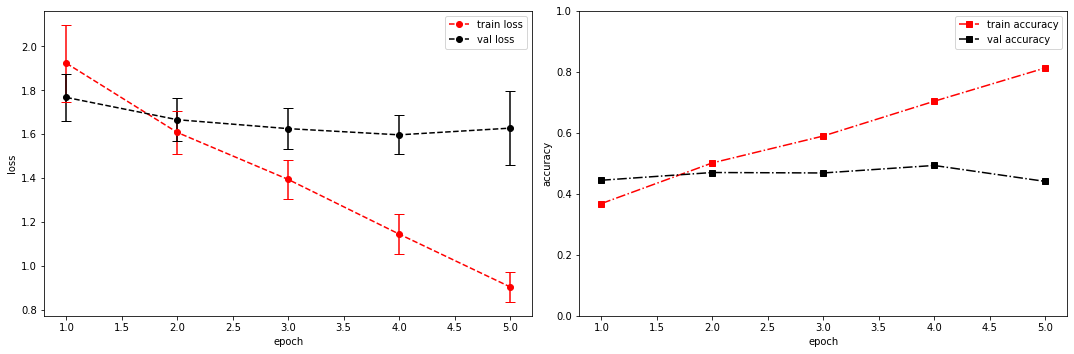

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 0.6670 +/- 0.0000,  accuracy: 0.0537109375, time elapsed = 0.2573404312133789s
Epoch [6/100], step [17/84],  Loss: 0.6473 +/- 0.0541,  accuracy: 0.919921875, time elapsed = 0.9003009796142578s
Epoch [6/100], step [33/84],  Loss: 0.6272 +/- 0.0689,  accuracy: 0.91796875, time elapsed = 0.8692440986633301s
Epoch [6/100], step [49/84],  Loss: 0.6365 +/- 0.0566,  accuracy: 0.91015625, time elapsed = 0.8814225196838379s
Epoch [6/100], step [65/84],  Loss: 0.6343 +/- 0.0528,  accuracy: 0.9052734375, time elapsed = 0.8835597038269043s
Epoch [6/100], step [81/84],  Loss: 0.6514 +/- 0.0468,  accuracy: 0.8994140625, time elapsed = 0.8961918354034424s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9097520044751072,  precision = 0.9097520044751072 recall = 0.9097520044751072 f1 = 0.9097520044751072 ::: val: acc = 0.5093214019388516,  precision = 0.5093214019388516 recall = 0.5093214019388516 time elapse

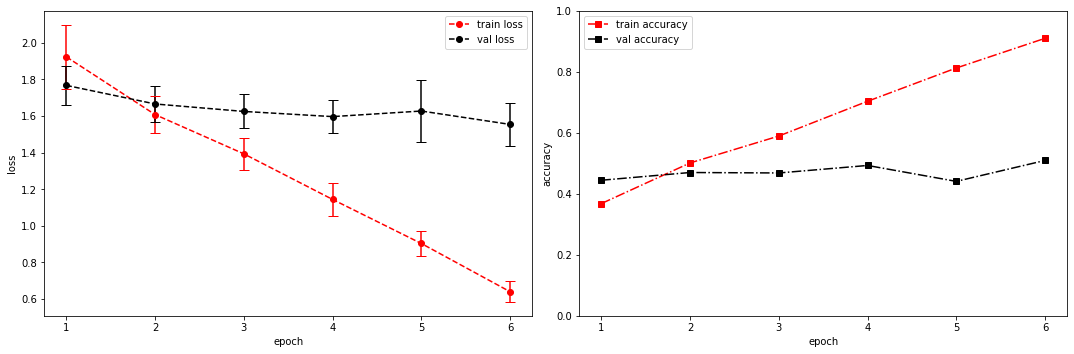

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.4096 +/- 0.0000,  accuracy: 0.0615234375, time elapsed = 0.2638540267944336s
Epoch [7/100], step [17/84],  Loss: 0.4487 +/- 0.0352,  accuracy: 0.9697265625, time elapsed = 0.9344379901885986s
Epoch [7/100], step [33/84],  Loss: 0.4709 +/- 0.0463,  accuracy: 0.9658203125, time elapsed = 0.9025387763977051s
Epoch [7/100], step [49/84],  Loss: 0.4548 +/- 0.0384,  accuracy: 0.9599609375, time elapsed = 0.906975269317627s
Epoch [7/100], step [65/84],  Loss: 0.4483 +/- 0.0429,  accuracy: 0.962890625, time elapsed = 0.8967084884643555s
Epoch [7/100], step [81/84],  Loss: 0.4452 +/- 0.0532,  accuracy: 0.9599609375, time elapsed = 0.8995654582977295s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9643856050717882,  precision = 0.9643856050717882 recall = 0.9643856050717882 f1 = 0.9643856050717882 ::: val: acc = 0.48322147651006714,  precision = 0.48322147651006714 recall = 0.48322147651006714 time 

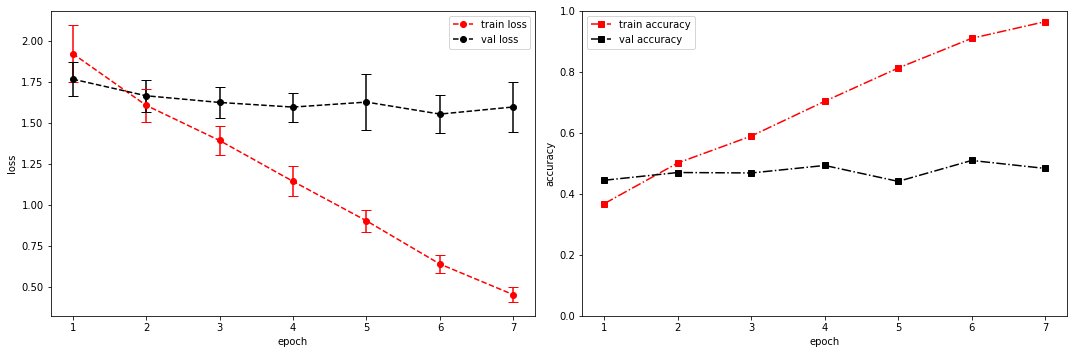

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0.5, 0]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─ReL

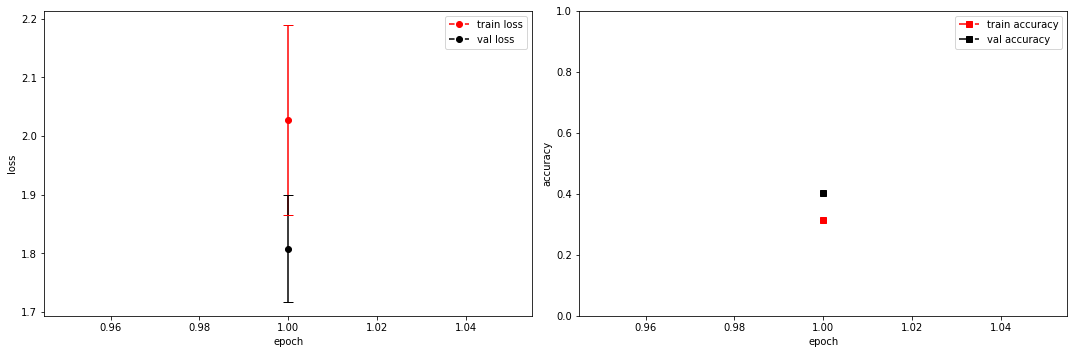

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.8252 +/- 0.0000,  accuracy: 0.0234375, time elapsed = 0.2555241584777832s
Epoch [2/100], step [17/84],  Loss: 1.7502 +/- 0.0762,  accuracy: 0.4169921875, time elapsed = 0.8846616744995117s
Epoch [2/100], step [33/84],  Loss: 1.7800 +/- 0.0580,  accuracy: 0.4208984375, time elapsed = 0.8756041526794434s
Epoch [2/100], step [49/84],  Loss: 1.7588 +/- 0.0857,  accuracy: 0.421875, time elapsed = 0.868527889251709s
Epoch [2/100], step [65/84],  Loss: 1.7580 +/- 0.0694,  accuracy: 0.4296875, time elapsed = 0.8805434703826904s
Epoch [2/100], step [81/84],  Loss: 1.7142 +/- 0.1053,  accuracy: 0.4482421875, time elapsed = 0.8641939163208008s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.42644042513518554,  precision = 0.42644042513518554 recall = 0.42644042513518554 f1 = 0.4264404251351855 ::: val: acc = 0.46234153616703955,  precision = 0.46234153616703955 recall = 0.46234153616703955 time elapse

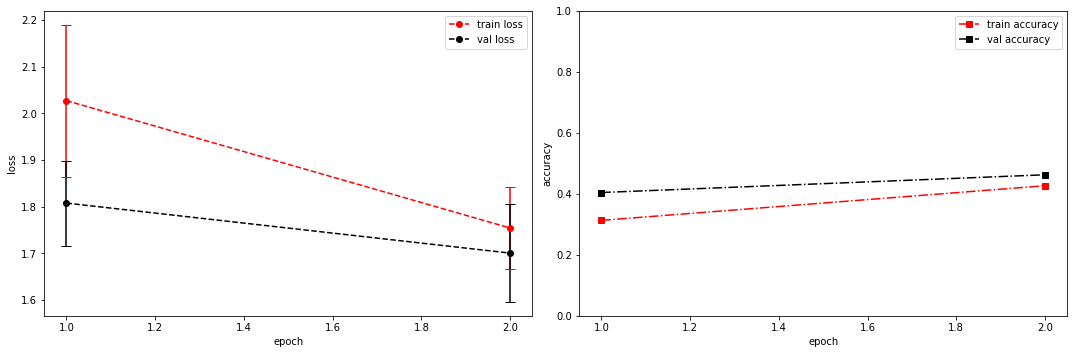

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.5698 +/- 0.0000,  accuracy: 0.033203125, time elapsed = 0.26470398902893066s
Epoch [3/100], step [17/84],  Loss: 1.6437 +/- 0.1009,  accuracy: 0.490234375, time elapsed = 0.8959312438964844s
Epoch [3/100], step [33/84],  Loss: 1.5946 +/- 0.1065,  accuracy: 0.4931640625, time elapsed = 0.8845179080963135s
Epoch [3/100], step [49/84],  Loss: 1.5879 +/- 0.0795,  accuracy: 0.5224609375, time elapsed = 0.8834197521209717s
Epoch [3/100], step [65/84],  Loss: 1.5707 +/- 0.1193,  accuracy: 0.5048828125, time elapsed = 0.9033794403076172s
Epoch [3/100], step [81/84],  Loss: 1.5476 +/- 0.0907,  accuracy: 0.5146484375, time elapsed = 0.8926506042480469s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.504568338616446,  precision = 0.504568338616446 recall = 0.504568338616446 f1 = 0.504568338616446 ::: val: acc = 0.5018642803877703,  precision = 0.5018642803877703 recall = 0.5018642803877703 time elapse

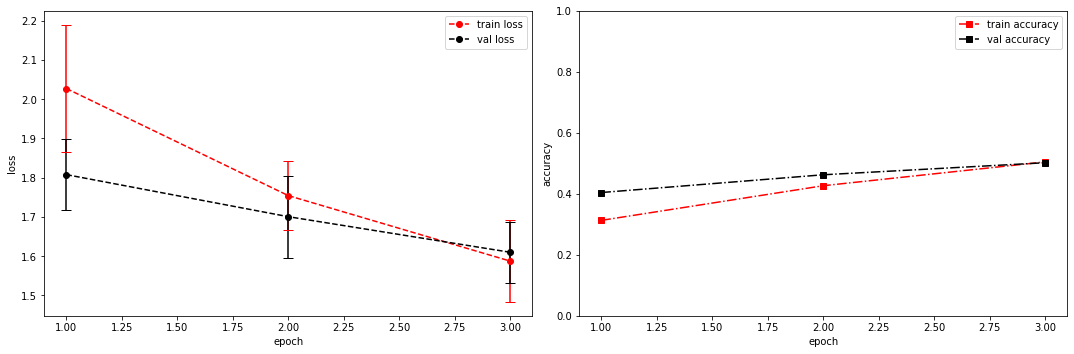

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.4471 +/- 0.0000,  accuracy: 0.033203125, time elapsed = 0.2547743320465088s
Epoch [4/100], step [17/84],  Loss: 1.4378 +/- 0.0583,  accuracy: 0.57421875, time elapsed = 0.9577844142913818s
Epoch [4/100], step [33/84],  Loss: 1.4336 +/- 0.1052,  accuracy: 0.58984375, time elapsed = 0.9130136966705322s
Epoch [4/100], step [49/84],  Loss: 1.3962 +/- 0.0855,  accuracy: 0.583984375, time elapsed = 0.9013197422027588s
Epoch [4/100], step [65/84],  Loss: 1.4074 +/- 0.1041,  accuracy: 0.5791015625, time elapsed = 0.8796203136444092s
Epoch [4/100], step [81/84],  Loss: 1.3959 +/- 0.0780,  accuracy: 0.5888671875, time elapsed = 0.87601637840271s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5830691776990491,  precision = 0.5830691776990491 recall = 0.5830691776990491 f1 = 0.5830691776990491 ::: val: acc = 0.4981357196122297,  precision = 0.4981357196122297 recall = 0.4981357196122297 time elapsed =

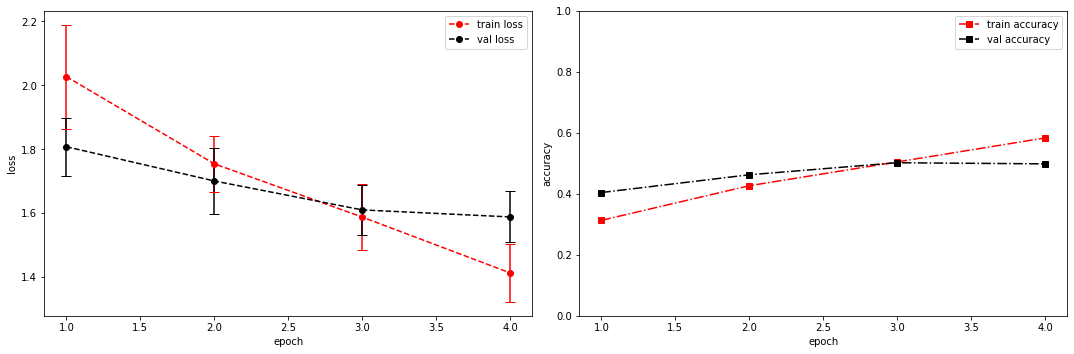

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.4189 +/- 0.0000,  accuracy: 0.037109375, time elapsed = 0.25980567932128906s
Epoch [5/100], step [17/84],  Loss: 1.2229 +/- 0.0924,  accuracy: 0.6591796875, time elapsed = 0.9032456874847412s
Epoch [5/100], step [33/84],  Loss: 1.2243 +/- 0.0700,  accuracy: 0.6552734375, time elapsed = 0.8839099407196045s
Epoch [5/100], step [49/84],  Loss: 1.2064 +/- 0.0719,  accuracy: 0.68359375, time elapsed = 0.8842377662658691s
Epoch [5/100], step [65/84],  Loss: 1.2452 +/- 0.0710,  accuracy: 0.6552734375, time elapsed = 0.9098985195159912s
Epoch [5/100], step [81/84],  Loss: 1.1831 +/- 0.0776,  accuracy: 0.68359375, time elapsed = 0.8814668655395508s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6656721983964199,  precision = 0.6656721983964199 recall = 0.6656721983964199 f1 = 0.6656721983964199 ::: val: acc = 0.5391498881431768,  precision = 0.5391498881431768 recall = 0.5391498881431768 time elaps

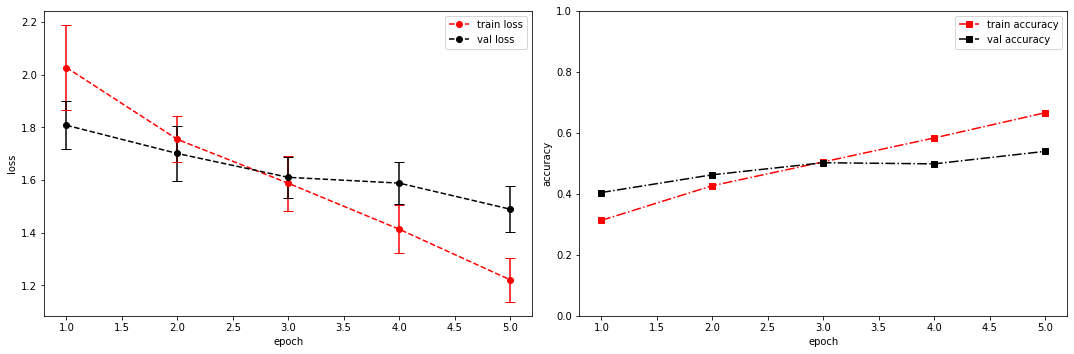

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.1060 +/- 0.0000,  accuracy: 0.0439453125, time elapsed = 0.26001977920532227s
Epoch [6/100], step [17/84],  Loss: 1.0217 +/- 0.0746,  accuracy: 0.7705078125, time elapsed = 0.9137279987335205s
Epoch [6/100], step [33/84],  Loss: 1.0235 +/- 0.0540,  accuracy: 0.7568359375, time elapsed = 0.9052369594573975s
Epoch [6/100], step [49/84],  Loss: 1.0139 +/- 0.0555,  accuracy: 0.7587890625, time elapsed = 0.8929481506347656s
Epoch [6/100], step [65/84],  Loss: 1.0111 +/- 0.0716,  accuracy: 0.763671875, time elapsed = 0.8896524906158447s
Epoch [6/100], step [81/84],  Loss: 1.0022 +/- 0.0989,  accuracy: 0.763671875, time elapsed = 0.9094481468200684s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.7622599291441358,  precision = 0.7622599291441358 recall = 0.7622599291441358 f1 = 0.7622599291441358 ::: val: acc = 0.5428784489187174,  precision = 0.5428784489187174 recall = 0.5428784489187174 time el

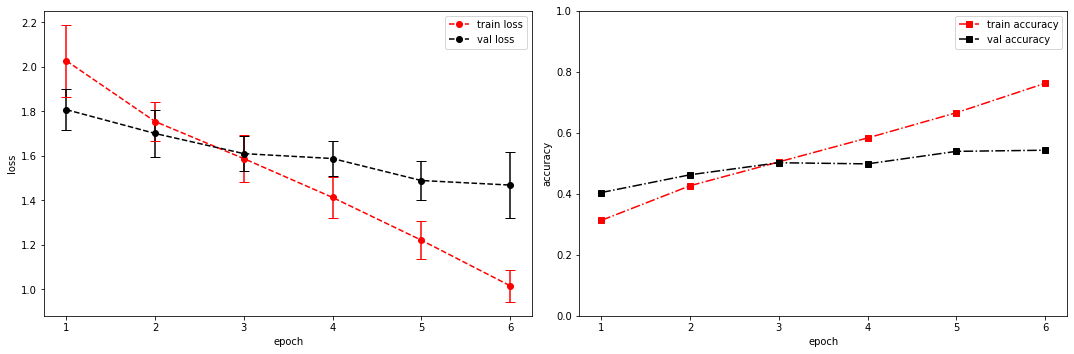

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.7420 +/- 0.0000,  accuracy: 0.0546875, time elapsed = 0.2678864002227783s
Epoch [7/100], step [17/84],  Loss: 0.8664 +/- 0.0706,  accuracy: 0.8251953125, time elapsed = 0.9107089042663574s
Epoch [7/100], step [33/84],  Loss: 0.8256 +/- 0.0635,  accuracy: 0.8349609375, time elapsed = 0.8740923404693604s
Epoch [7/100], step [49/84],  Loss: 0.8368 +/- 0.0574,  accuracy: 0.8271484375, time elapsed = 0.8934526443481445s
Epoch [7/100], step [65/84],  Loss: 0.8344 +/- 0.0566,  accuracy: 0.8291015625, time elapsed = 0.8994989395141602s
Epoch [7/100], step [81/84],  Loss: 0.8142 +/- 0.0643,  accuracy: 0.8291015625, time elapsed = 0.9000244140625s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.8316240909938467,  precision = 0.8316240909938467 recall = 0.8316240909938467 f1 = 0.8316240909938467 ::: val: acc = 0.5510812826249067,  precision = 0.5510812826249067 recall = 0.5510812826249067 time elapsed

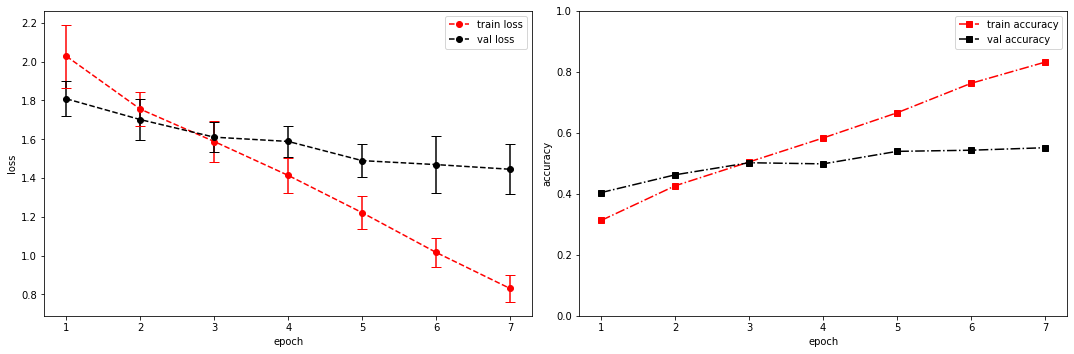

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0, 0.1]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─ReL

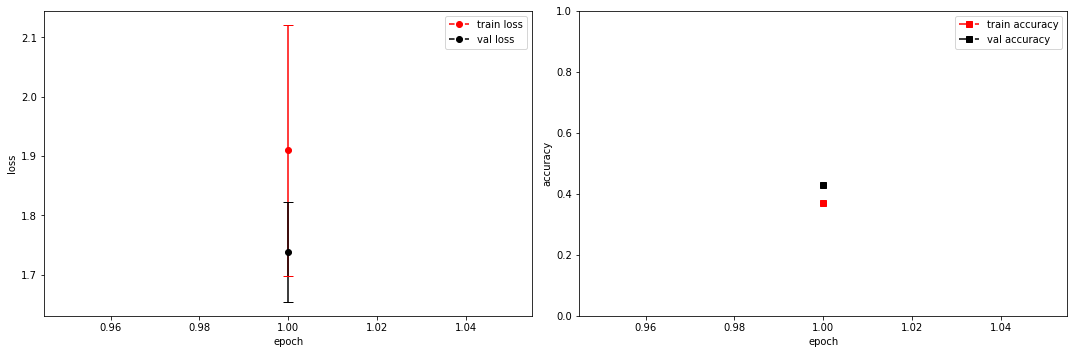

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.6137 +/- 0.0000,  accuracy: 0.033203125, time elapsed = 0.25714778900146484s
Epoch [2/100], step [17/84],  Loss: 1.5659 +/- 0.0450,  accuracy: 0.51953125, time elapsed = 0.9117588996887207s
Epoch [2/100], step [33/84],  Loss: 1.5234 +/- 0.1242,  accuracy: 0.5341796875, time elapsed = 0.8845019340515137s
Epoch [2/100], step [49/84],  Loss: 1.5097 +/- 0.0784,  accuracy: 0.5185546875, time elapsed = 0.8924028873443604s
Epoch [2/100], step [65/84],  Loss: 1.5257 +/- 0.0949,  accuracy: 0.517578125, time elapsed = 0.8811023235321045s
Epoch [2/100], step [81/84],  Loss: 1.4323 +/- 0.0928,  accuracy: 0.5732421875, time elapsed = 0.889441728591919s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5316054447137796,  precision = 0.5316054447137796 recall = 0.5316054447137796 f1 = 0.5316054447137796 ::: val: acc = 0.47576435495898584,  precision = 0.47576435495898584 recall = 0.47576435495898584 time el

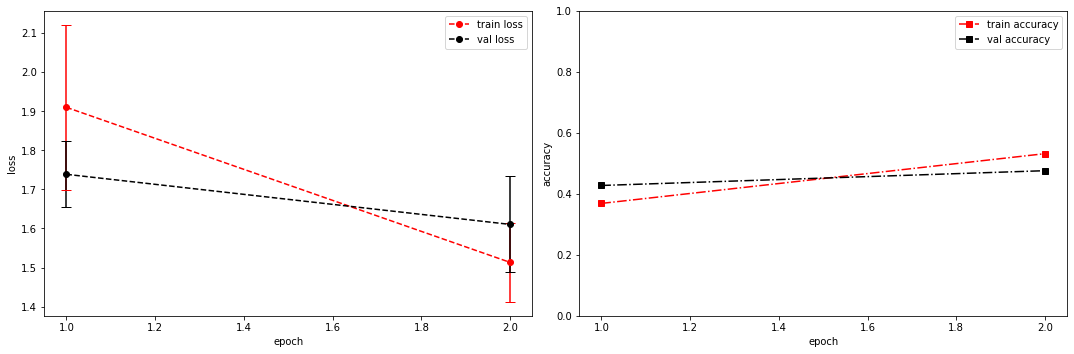

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.3711 +/- 0.0000,  accuracy: 0.0390625, time elapsed = 0.2538635730743408s
Epoch [3/100], step [17/84],  Loss: 1.2494 +/- 0.0580,  accuracy: 0.6298828125, time elapsed = 0.9132018089294434s
Epoch [3/100], step [33/84],  Loss: 1.1979 +/- 0.0587,  accuracy: 0.6875, time elapsed = 0.8938534259796143s
Epoch [3/100], step [49/84],  Loss: 1.1873 +/- 0.0972,  accuracy: 0.6875, time elapsed = 0.9421534538269043s
Epoch [3/100], step [65/84],  Loss: 1.2111 +/- 0.0661,  accuracy: 0.65625, time elapsed = 0.9072339534759521s
Epoch [3/100], step [81/84],  Loss: 1.1518 +/- 0.0749,  accuracy: 0.6796875, time elapsed = 0.9046206474304199s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.666418049599105,  precision = 0.666418049599105 recall = 0.666418049599105 f1 = 0.666418049599105 ::: val: acc = 0.4862043251304996,  precision = 0.4862043251304996 recall = 0.4862043251304996 time elapsed = 6.361874580383301s

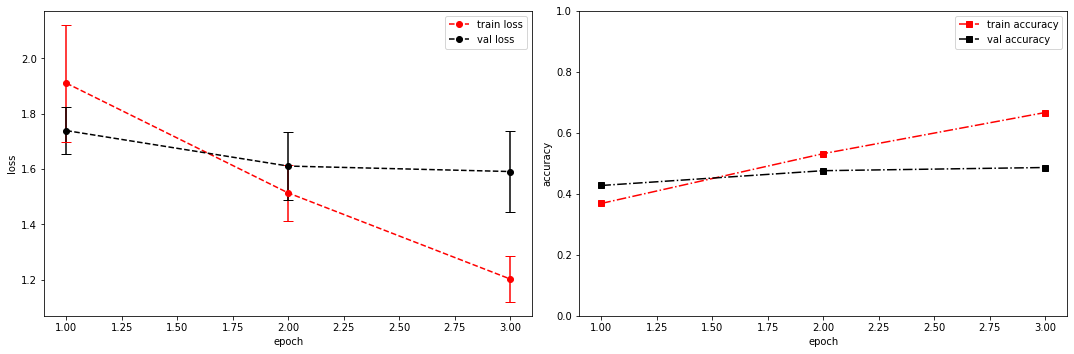

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 0.8369 +/- 0.0000,  accuracy: 0.0537109375, time elapsed = 0.24746465682983398s
Epoch [4/100], step [17/84],  Loss: 0.9713 +/- 0.0974,  accuracy: 0.7919921875, time elapsed = 0.9063205718994141s
Epoch [4/100], step [33/84],  Loss: 0.9398 +/- 0.0803,  accuracy: 0.791015625, time elapsed = 0.9346418380737305s
Epoch [4/100], step [49/84],  Loss: 0.9211 +/- 0.0716,  accuracy: 0.798828125, time elapsed = 0.8973324298858643s
Epoch [4/100], step [65/84],  Loss: 0.8513 +/- 0.0536,  accuracy: 0.8359375, time elapsed = 0.8871688842773438s
Epoch [4/100], step [81/84],  Loss: 0.9018 +/- 0.0895,  accuracy: 0.806640625, time elapsed = 0.884286642074585s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.8049599104978556,  precision = 0.8049599104978556 recall = 0.8049599104978556 f1 = 0.8049599104978556 ::: val: acc = 0.4608501118568233,  precision = 0.4608501118568233 recall = 0.4608501118568233 time elapsed

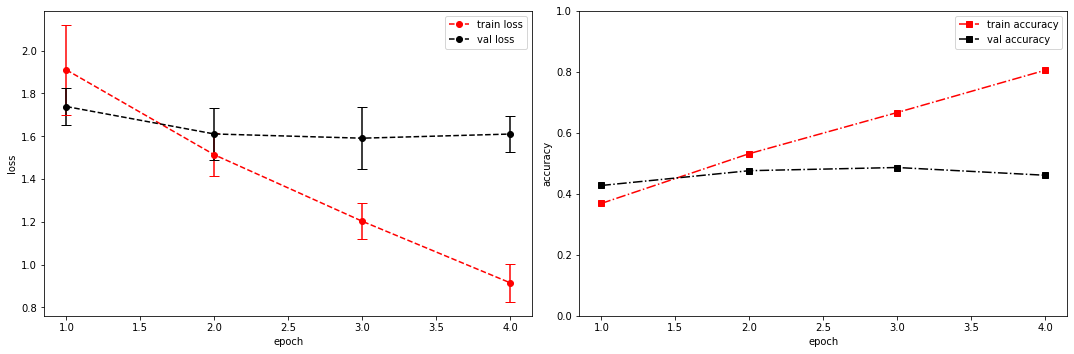

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 0.6576 +/- 0.0000,  accuracy: 0.0537109375, time elapsed = 0.2688782215118408s
Epoch [5/100], step [17/84],  Loss: 0.6534 +/- 0.0511,  accuracy: 0.9072265625, time elapsed = 0.9101932048797607s
Epoch [5/100], step [33/84],  Loss: 0.6033 +/- 0.0438,  accuracy: 0.9306640625, time elapsed = 0.9122602939605713s
Epoch [5/100], step [49/84],  Loss: 0.5930 +/- 0.0380,  accuracy: 0.943359375, time elapsed = 0.8813519477844238s
Epoch [5/100], step [65/84],  Loss: 0.6010 +/- 0.0538,  accuracy: 0.9306640625, time elapsed = 0.9098865985870361s
Epoch [5/100], step [81/84],  Loss: 0.6217 +/- 0.0550,  accuracy: 0.90234375, time elapsed = 0.8912220001220703s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9220585493194108,  precision = 0.9220585493194108 recall = 0.9220585493194108 f1 = 0.9220585493194108 ::: val: acc = 0.5003728560775541,  precision = 0.5003728560775541 recall = 0.5003728560775541 time elap

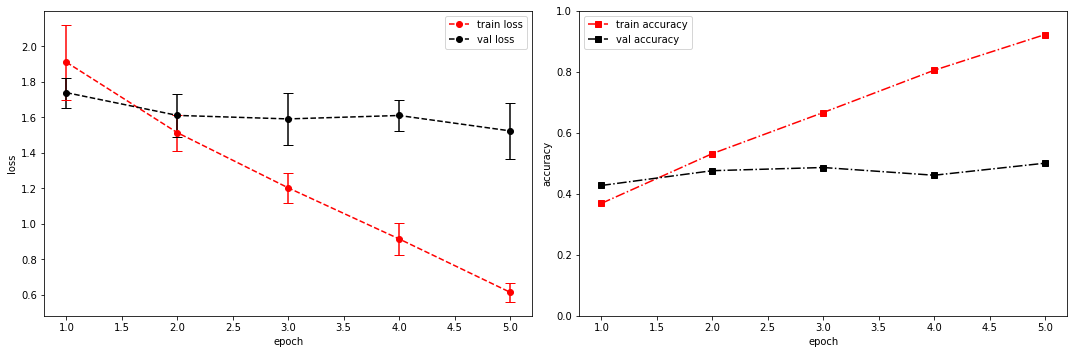

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 0.4721 +/- 0.0000,  accuracy: 0.060546875, time elapsed = 0.25400781631469727s
Epoch [6/100], step [17/84],  Loss: 0.4357 +/- 0.0418,  accuracy: 0.9794921875, time elapsed = 0.8971669673919678s
Epoch [6/100], step [33/84],  Loss: 0.4013 +/- 0.0439,  accuracy: 0.9814453125, time elapsed = 0.892509937286377s
Epoch [6/100], step [49/84],  Loss: 0.4027 +/- 0.0427,  accuracy: 0.982421875, time elapsed = 0.8857975006103516s
Epoch [6/100], step [65/84],  Loss: 0.3850 +/- 0.0248,  accuracy: 0.9794921875, time elapsed = 0.8921444416046143s
Epoch [6/100], step [81/84],  Loss: 0.3846 +/- 0.0407,  accuracy: 0.978515625, time elapsed = 0.8963680267333984s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9802349431288458,  precision = 0.9802349431288458 recall = 0.9802349431288458 f1 = 0.9802349431288458 ::: val: acc = 0.5070842654735273,  precision = 0.5070842654735273 recall = 0.5070842654735273 time elap

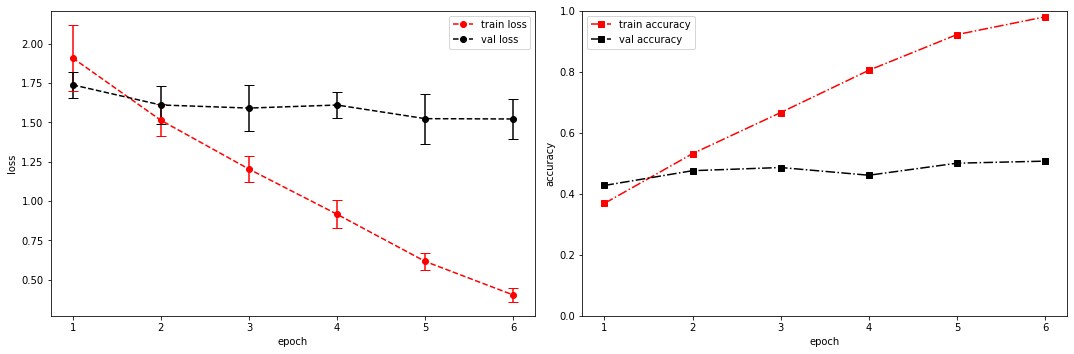

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.3320 +/- 0.0000,  accuracy: 0.0615234375, time elapsed = 0.2635772228240967s
Epoch [7/100], step [17/84],  Loss: 0.2836 +/- 0.0302,  accuracy: 0.9931640625, time elapsed = 0.91324782371521s
Epoch [7/100], step [33/84],  Loss: 0.2763 +/- 0.0330,  accuracy: 0.990234375, time elapsed = 0.9106278419494629s
Epoch [7/100], step [49/84],  Loss: 0.2662 +/- 0.0366,  accuracy: 0.99609375, time elapsed = 0.9115457534790039s
Epoch [7/100], step [65/84],  Loss: 0.2534 +/- 0.0291,  accuracy: 0.9951171875, time elapsed = 0.8937764167785645s
Epoch [7/100], step [81/84],  Loss: 0.2483 +/- 0.0287,  accuracy: 0.994140625, time elapsed = 0.9051370620727539s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9938467275778482,  precision = 0.9938467275778482 recall = 0.9938467275778482 f1 = 0.9938467275778482 ::: val: acc = 0.4988814317673378,  precision = 0.4988814317673378 recall = 0.4988814317673378 time elapsed

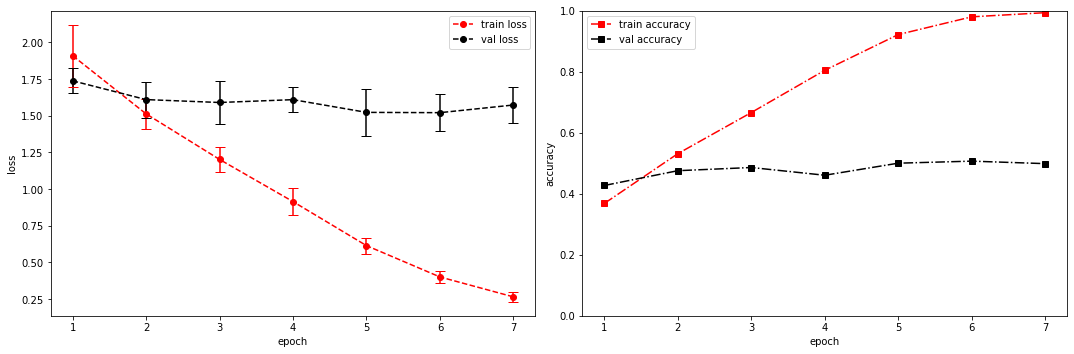

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0.1, 0.1]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─R

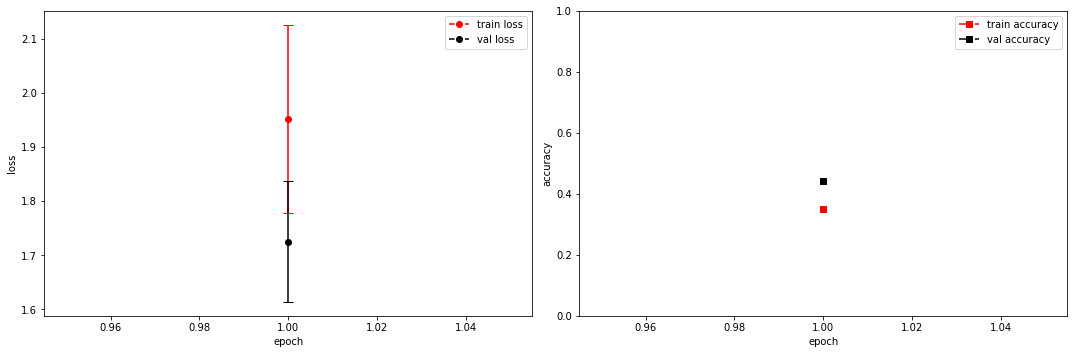

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.6310 +/- 0.0000,  accuracy: 0.02734375, time elapsed = 0.2623105049133301s
Epoch [2/100], step [17/84],  Loss: 1.6510 +/- 0.0859,  accuracy: 0.4755859375, time elapsed = 0.9169564247131348s
Epoch [2/100], step [33/84],  Loss: 1.5856 +/- 0.1070,  accuracy: 0.5029296875, time elapsed = 0.9066104888916016s
Epoch [2/100], step [49/84],  Loss: 1.6016 +/- 0.0965,  accuracy: 0.505859375, time elapsed = 0.8825883865356445s
Epoch [2/100], step [65/84],  Loss: 1.6010 +/- 0.0704,  accuracy: 0.490234375, time elapsed = 0.8842651844024658s
Epoch [2/100], step [81/84],  Loss: 1.6252 +/- 0.1173,  accuracy: 0.470703125, time elapsed = 0.8918771743774414s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.48760022375536083,  precision = 0.48760022375536083 recall = 0.48760022375536083 f1 = 0.48760022375536083 ::: val: acc = 0.46607009694258017,  precision = 0.46607009694258017 recall = 0.46607009694258017 time

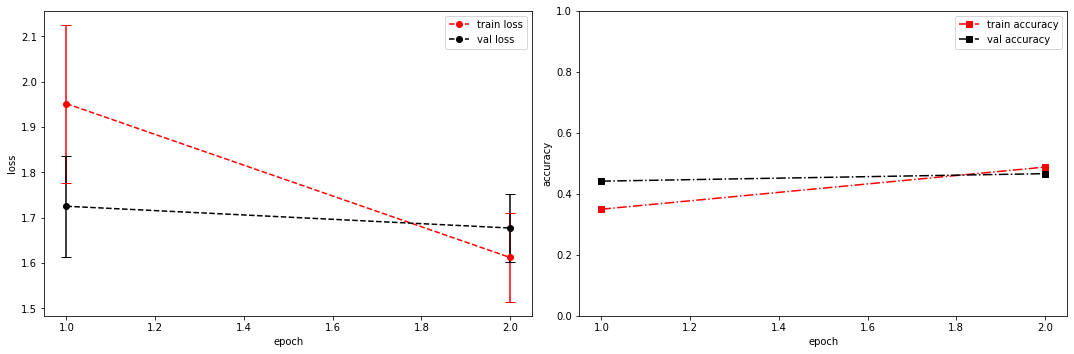

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.5040 +/- 0.0000,  accuracy: 0.037109375, time elapsed = 0.2753570079803467s
Epoch [3/100], step [17/84],  Loss: 1.4130 +/- 0.0682,  accuracy: 0.583984375, time elapsed = 0.9182674884796143s
Epoch [3/100], step [33/84],  Loss: 1.3983 +/- 0.1246,  accuracy: 0.572265625, time elapsed = 0.906141996383667s
Epoch [3/100], step [49/84],  Loss: 1.3323 +/- 0.0807,  accuracy: 0.61328125, time elapsed = 0.8960576057434082s
Epoch [3/100], step [65/84],  Loss: 1.3830 +/- 0.0989,  accuracy: 0.59765625, time elapsed = 0.8981788158416748s
Epoch [3/100], step [81/84],  Loss: 1.3515 +/- 0.1007,  accuracy: 0.5966796875, time elapsed = 0.8979542255401611s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5936975573373112,  precision = 0.5936975573373112 recall = 0.5936975573373112 f1 = 0.5936975573373112 ::: val: acc = 0.48695003728560776,  precision = 0.48695003728560776 recall = 0.48695003728560776 time elapse

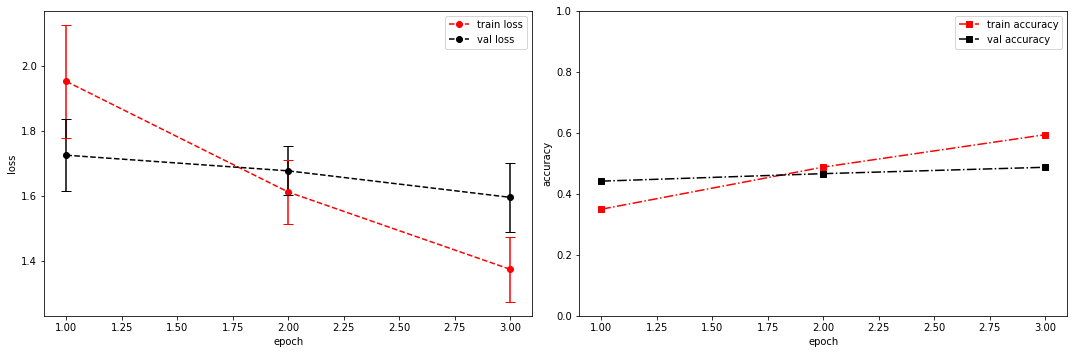

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.0391 +/- 0.0000,  accuracy: 0.044921875, time elapsed = 0.2738795280456543s
Epoch [4/100], step [17/84],  Loss: 1.1630 +/- 0.0880,  accuracy: 0.6904296875, time elapsed = 0.8991053104400635s
Epoch [4/100], step [33/84],  Loss: 1.1103 +/- 0.0630,  accuracy: 0.7099609375, time elapsed = 0.8963994979858398s
Epoch [4/100], step [49/84],  Loss: 1.0806 +/- 0.0724,  accuracy: 0.7255859375, time elapsed = 0.8836231231689453s
Epoch [4/100], step [65/84],  Loss: 1.1065 +/- 0.0681,  accuracy: 0.7060546875, time elapsed = 0.8655133247375488s
Epoch [4/100], step [81/84],  Loss: 1.0883 +/- 0.0923,  accuracy: 0.71875, time elapsed = 0.8830752372741699s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.70986388215551,  precision = 0.70986388215551 recall = 0.70986388215551 f1 = 0.7098638821555099 ::: val: acc = 0.4936614466815809,  precision = 0.4936614466815809 recall = 0.4936614466815809 time elapsed = 6.3

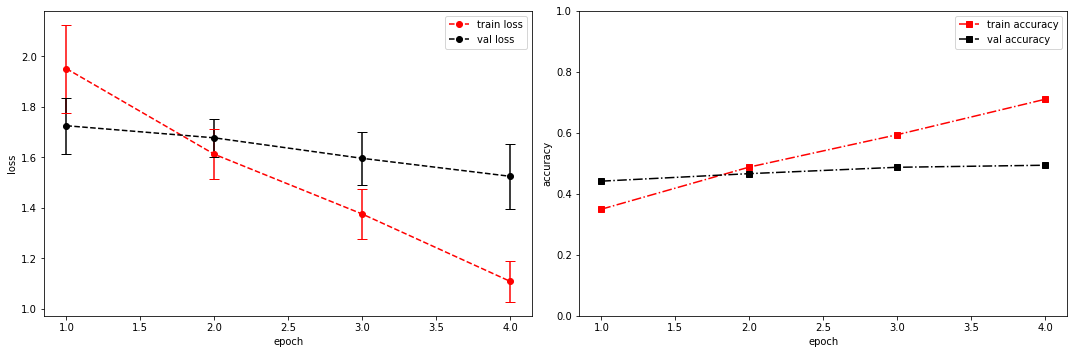

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 0.8952 +/- 0.0000,  accuracy: 0.052734375, time elapsed = 0.25919485092163086s
Epoch [5/100], step [17/84],  Loss: 0.8762 +/- 0.0773,  accuracy: 0.8251953125, time elapsed = 0.9001750946044922s
Epoch [5/100], step [33/84],  Loss: 0.8401 +/- 0.0544,  accuracy: 0.8447265625, time elapsed = 0.9023535251617432s
Epoch [5/100], step [49/84],  Loss: 0.8436 +/- 0.0473,  accuracy: 0.8408203125, time elapsed = 0.9054703712463379s
Epoch [5/100], step [65/84],  Loss: 0.8653 +/- 0.0765,  accuracy: 0.8212890625, time elapsed = 0.8956763744354248s
Epoch [5/100], step [81/84],  Loss: 0.8598 +/- 0.0458,  accuracy: 0.8212890625, time elapsed = 0.8885307312011719s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.831064702591833,  precision = 0.831064702591833 recall = 0.831064702591833 f1 = 0.831064702591833 ::: val: acc = 0.5197613721103654,  precision = 0.5197613721103654 recall = 0.5197613721103654 time elaps

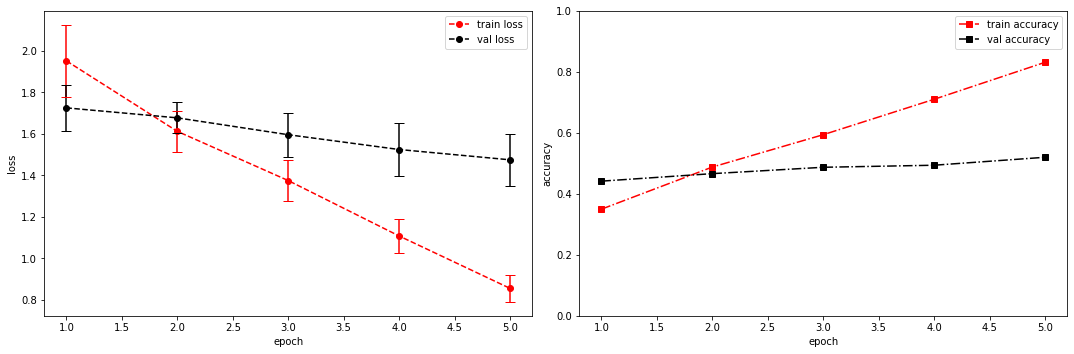

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 0.7178 +/- 0.0000,  accuracy: 0.0537109375, time elapsed = 0.27342700958251953s
Epoch [6/100], step [17/84],  Loss: 0.6405 +/- 0.0528,  accuracy: 0.904296875, time elapsed = 0.9179444313049316s
Epoch [6/100], step [33/84],  Loss: 0.6122 +/- 0.0443,  accuracy: 0.91015625, time elapsed = 0.9306955337524414s
Epoch [6/100], step [49/84],  Loss: 0.6172 +/- 0.0575,  accuracy: 0.916015625, time elapsed = 0.8718521595001221s
Epoch [6/100], step [65/84],  Loss: 0.6255 +/- 0.0571,  accuracy: 0.9013671875, time elapsed = 0.8817007541656494s
Epoch [6/100], step [81/84],  Loss: 0.6275 +/- 0.0598,  accuracy: 0.91015625, time elapsed = 0.8935742378234863s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9080738392690658,  precision = 0.9080738392690658 recall = 0.9080738392690658 f1 = 0.9080738392690657 ::: val: acc = 0.5212527964205816,  precision = 0.5212527964205816 recall = 0.5212527964205816 time elapse

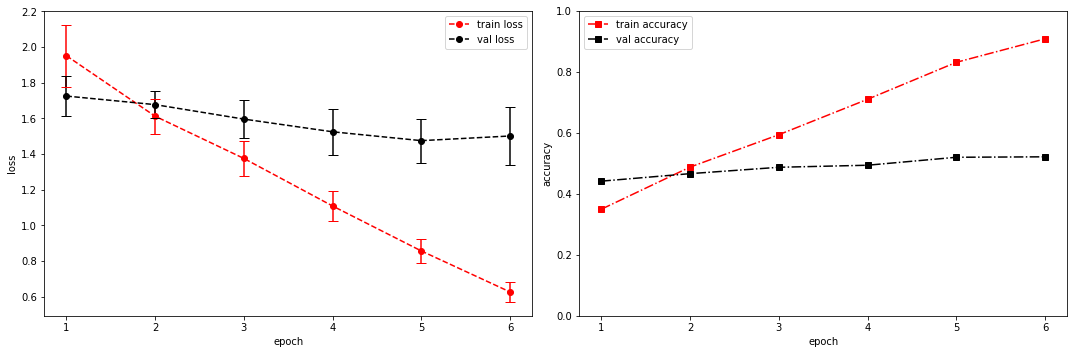

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.4708 +/- 0.0000,  accuracy: 0.0615234375, time elapsed = 0.27762746810913086s
Epoch [7/100], step [17/84],  Loss: 0.4514 +/- 0.0592,  accuracy: 0.9609375, time elapsed = 0.8828201293945312s
Epoch [7/100], step [33/84],  Loss: 0.4484 +/- 0.0427,  accuracy: 0.96875, time elapsed = 0.874835729598999s
Epoch [7/100], step [49/84],  Loss: 0.4610 +/- 0.0405,  accuracy: 0.958984375, time elapsed = 0.9087870121002197s
Epoch [7/100], step [65/84],  Loss: 0.4418 +/- 0.0582,  accuracy: 0.9619140625, time elapsed = 0.8952744007110596s
Epoch [7/100], step [81/84],  Loss: 0.4403 +/- 0.0360,  accuracy: 0.9599609375, time elapsed = 0.9426157474517822s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9617751258623904,  precision = 0.9617751258623904 recall = 0.9617751258623904 f1 = 0.9617751258623904 ::: val: acc = 0.5160328113348247,  precision = 0.5160328113348247 recall = 0.5160328113348247 time elapsed = 

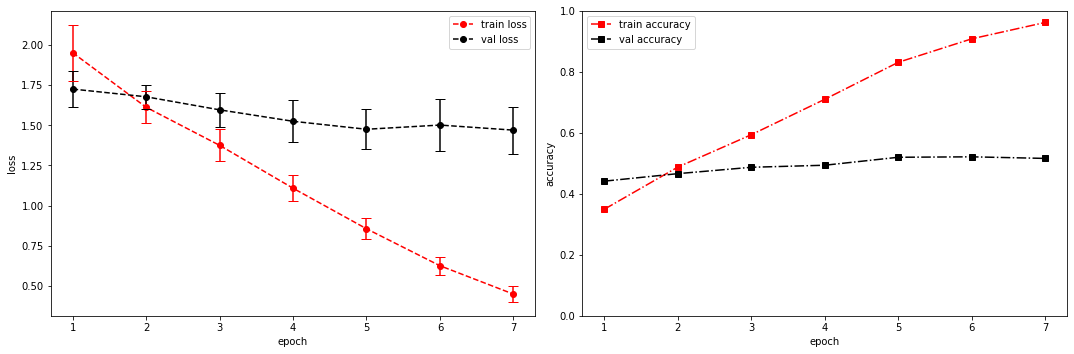

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0.25, 0.1]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─

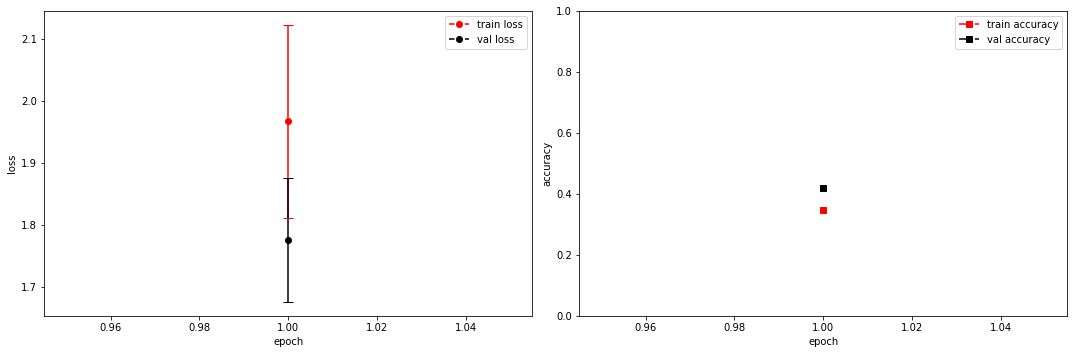

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.7009 +/- 0.0000,  accuracy: 0.0341796875, time elapsed = 0.28313422203063965s
Epoch [2/100], step [17/84],  Loss: 1.6928 +/- 0.0894,  accuracy: 0.4775390625, time elapsed = 0.9185748100280762s
Epoch [2/100], step [33/84],  Loss: 1.6514 +/- 0.0865,  accuracy: 0.4833984375, time elapsed = 0.8769605159759521s
Epoch [2/100], step [49/84],  Loss: 1.6604 +/- 0.0608,  accuracy: 0.458984375, time elapsed = 0.8766844272613525s
Epoch [2/100], step [65/84],  Loss: 1.6367 +/- 0.0975,  accuracy: 0.4814453125, time elapsed = 0.8869161605834961s
Epoch [2/100], step [81/84],  Loss: 1.6470 +/- 0.0924,  accuracy: 0.482421875, time elapsed = 0.9064264297485352s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.4773447697184412,  precision = 0.4773447697184412 recall = 0.4773447697184412 f1 = 0.4773447697184412 ::: val: acc = 0.4608501118568233,  precision = 0.4608501118568233 recall = 0.4608501118568233 time el

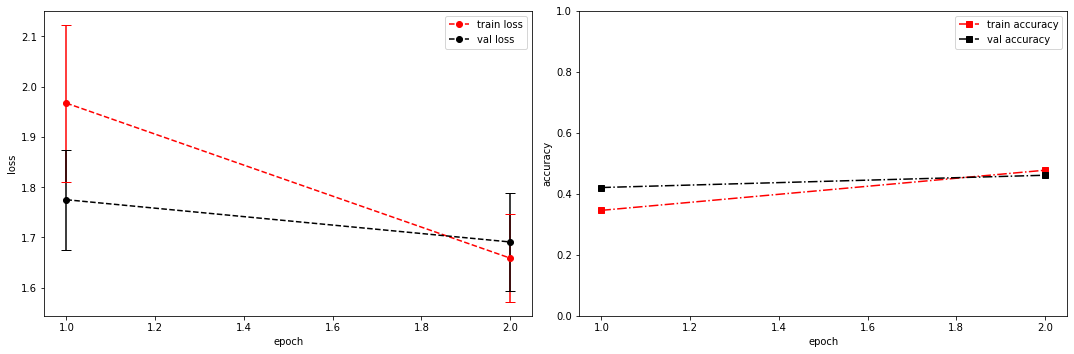

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.6431 +/- 0.0000,  accuracy: 0.033203125, time elapsed = 0.26888394355773926s
Epoch [3/100], step [17/84],  Loss: 1.4972 +/- 0.0936,  accuracy: 0.56640625, time elapsed = 0.9019246101379395s
Epoch [3/100], step [33/84],  Loss: 1.4423 +/- 0.0774,  accuracy: 0.576171875, time elapsed = 0.8884096145629883s
Epoch [3/100], step [49/84],  Loss: 1.4609 +/- 0.0825,  accuracy: 0.5537109375, time elapsed = 0.905780553817749s
Epoch [3/100], step [65/84],  Loss: 1.4593 +/- 0.0835,  accuracy: 0.576171875, time elapsed = 0.8967208862304688s
Epoch [3/100], step [81/84],  Loss: 1.4529 +/- 0.0738,  accuracy: 0.56640625, time elapsed = 0.9062159061431885s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5679656908446765,  precision = 0.5679656908446765 recall = 0.5679656908446765 f1 = 0.5679656908446765 ::: val: acc = 0.48396718866517524,  precision = 0.48396718866517524 recall = 0.48396718866517524 time elaps

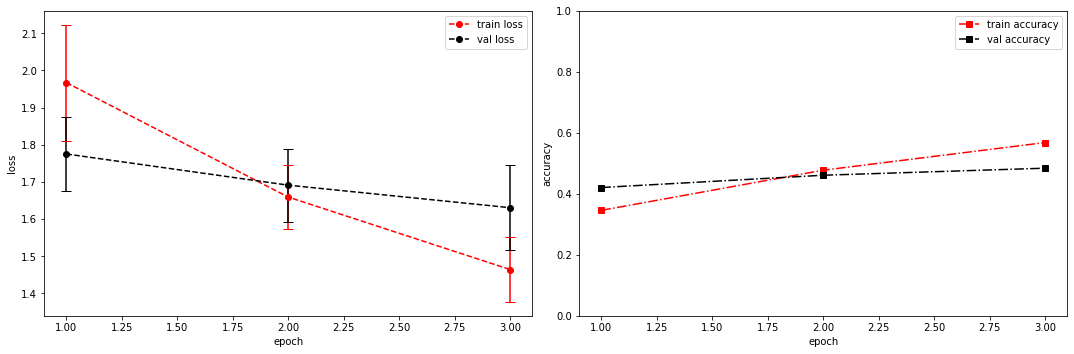

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.2806 +/- 0.0000,  accuracy: 0.0390625, time elapsed = 0.2718312740325928s
Epoch [4/100], step [17/84],  Loss: 1.2504 +/- 0.1072,  accuracy: 0.685546875, time elapsed = 0.9147536754608154s
Epoch [4/100], step [33/84],  Loss: 1.2565 +/- 0.0954,  accuracy: 0.669921875, time elapsed = 0.903428316116333s
Epoch [4/100], step [49/84],  Loss: 1.2366 +/- 0.0752,  accuracy: 0.6630859375, time elapsed = 0.8920278549194336s
Epoch [4/100], step [65/84],  Loss: 1.2413 +/- 0.0553,  accuracy: 0.6669921875, time elapsed = 0.8903701305389404s
Epoch [4/100], step [81/84],  Loss: 1.2369 +/- 0.0951,  accuracy: 0.6533203125, time elapsed = 0.8850822448730469s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6684691404064889,  precision = 0.6684691404064889 recall = 0.6684691404064889 f1 = 0.6684691404064889 ::: val: acc = 0.48322147651006714,  precision = 0.48322147651006714 recall = 0.48322147651006714 time elap

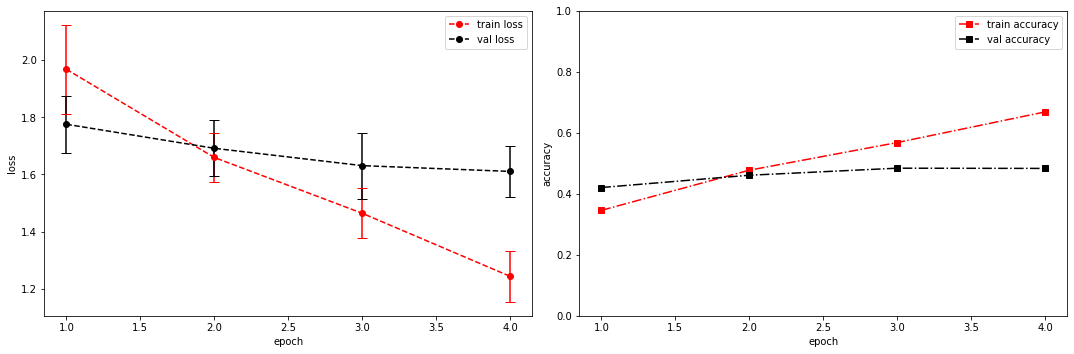

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.1231 +/- 0.0000,  accuracy: 0.044921875, time elapsed = 0.275158166885376s
Epoch [5/100], step [17/84],  Loss: 1.0247 +/- 0.0722,  accuracy: 0.7724609375, time elapsed = 0.8872706890106201s
Epoch [5/100], step [33/84],  Loss: 1.0151 +/- 0.0777,  accuracy: 0.7763671875, time elapsed = 0.8971779346466064s
Epoch [5/100], step [49/84],  Loss: 0.9885 +/- 0.0689,  accuracy: 0.7734375, time elapsed = 0.9072270393371582s
Epoch [5/100], step [65/84],  Loss: 0.9678 +/- 0.0717,  accuracy: 0.79296875, time elapsed = 0.8824460506439209s
Epoch [5/100], step [81/84],  Loss: 0.9764 +/- 0.0744,  accuracy: 0.7802734375, time elapsed = 0.8804969787597656s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.7782957300018646,  precision = 0.7782957300018646 recall = 0.7782957300018646 f1 = 0.7782957300018647 ::: val: acc = 0.4809843400447427,  precision = 0.4809843400447427 recall = 0.4809843400447427 time elapsed 

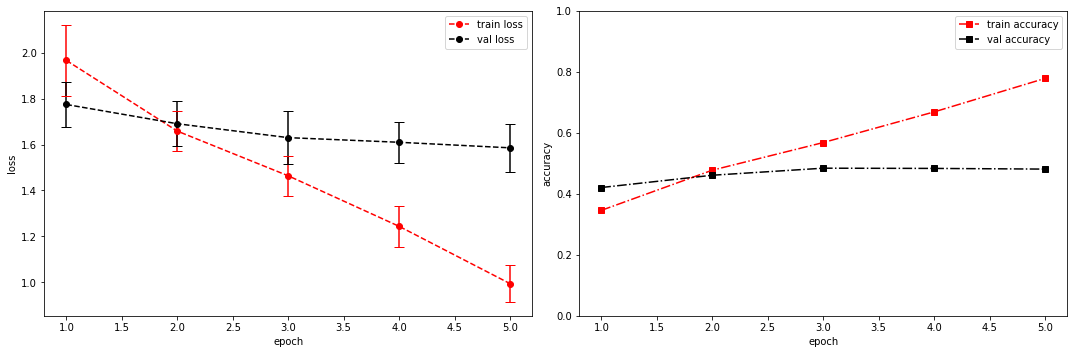

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 0.8017 +/- 0.0000,  accuracy: 0.052734375, time elapsed = 0.2736167907714844s
Epoch [6/100], step [17/84],  Loss: 0.7700 +/- 0.0368,  accuracy: 0.8994140625, time elapsed = 0.8891618251800537s
Epoch [6/100], step [33/84],  Loss: 0.7594 +/- 0.0704,  accuracy: 0.8759765625, time elapsed = 0.9116621017456055s
Epoch [6/100], step [49/84],  Loss: 0.7311 +/- 0.0408,  accuracy: 0.8896484375, time elapsed = 0.8659577369689941s
Epoch [6/100], step [65/84],  Loss: 0.7309 +/- 0.0641,  accuracy: 0.8916015625, time elapsed = 0.8775086402893066s
Epoch [6/100], step [81/84],  Loss: 0.7453 +/- 0.0546,  accuracy: 0.875, time elapsed = 0.8843679428100586s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.8862576915905277,  precision = 0.8862576915905277 recall = 0.8862576915905277 f1 = 0.8862576915905276 ::: val: acc = 0.5167785234899329,  precision = 0.5167785234899329 recall = 0.5167785234899329 time elapsed =

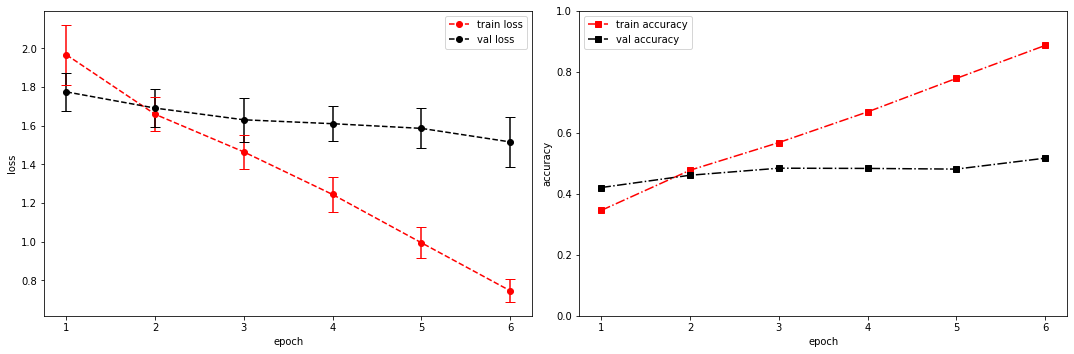

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.5461 +/- 0.0000,  accuracy: 0.060546875, time elapsed = 0.26228976249694824s
Epoch [7/100], step [17/84],  Loss: 0.5722 +/- 0.0547,  accuracy: 0.9404296875, time elapsed = 0.9120543003082275s
Epoch [7/100], step [33/84],  Loss: 0.5402 +/- 0.0542,  accuracy: 0.947265625, time elapsed = 0.9056570529937744s
Epoch [7/100], step [49/84],  Loss: 0.5316 +/- 0.0453,  accuracy: 0.9482421875, time elapsed = 0.8952126502990723s
Epoch [7/100], step [65/84],  Loss: 0.5227 +/- 0.0470,  accuracy: 0.9482421875, time elapsed = 0.8806672096252441s
Epoch [7/100], step [81/84],  Loss: 0.5474 +/- 0.0551,  accuracy: 0.9345703125, time elapsed = 0.8769283294677734s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9442476225992914,  precision = 0.9442476225992914 recall = 0.9442476225992914 f1 = 0.9442476225992914 ::: val: acc = 0.49217002237136465,  precision = 0.49217002237136465 recall = 0.49217002237136465 time

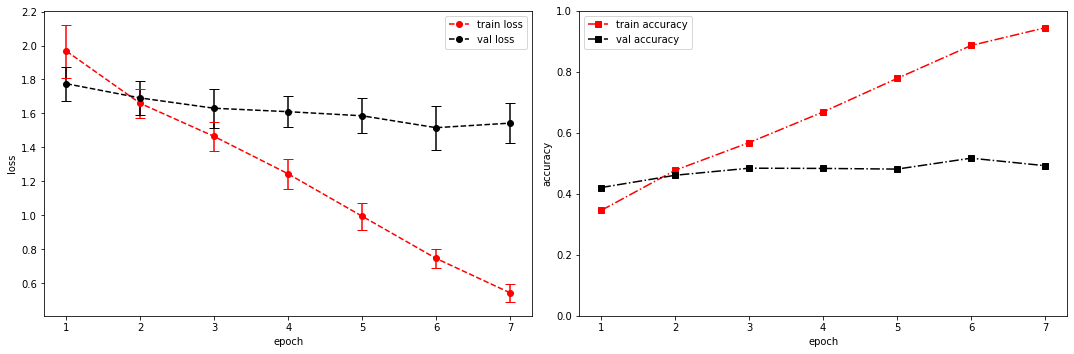

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0.5, 0.1]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─R

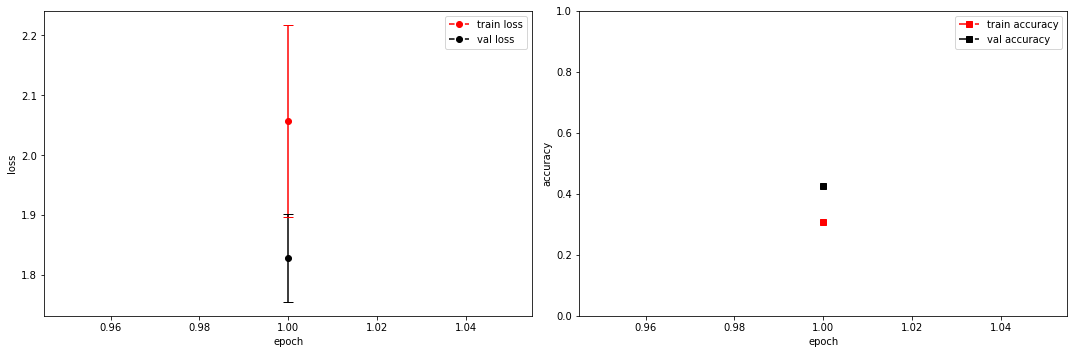

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.8598 +/- 0.0000,  accuracy: 0.0205078125, time elapsed = 0.279862642288208s
Epoch [2/100], step [17/84],  Loss: 1.7918 +/- 0.0662,  accuracy: 0.4326171875, time elapsed = 0.9928479194641113s
Epoch [2/100], step [33/84],  Loss: 1.8152 +/- 0.0837,  accuracy: 0.40625, time elapsed = 0.9020707607269287s
Epoch [2/100], step [49/84],  Loss: 1.7648 +/- 0.0836,  accuracy: 0.427734375, time elapsed = 0.9312496185302734s
Epoch [2/100], step [65/84],  Loss: 1.7973 +/- 0.1202,  accuracy: 0.416015625, time elapsed = 0.91111159324646s
Epoch [2/100], step [81/84],  Loss: 1.7482 +/- 0.1031,  accuracy: 0.4404296875, time elapsed = 0.8929777145385742s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.42588103673317174,  precision = 0.42588103673317174 recall = 0.42588103673317174 f1 = 0.42588103673317174 ::: val: acc = 0.4697986577181208,  precision = 0.4697986577181208 recall = 0.4697986577181208 time elapsed

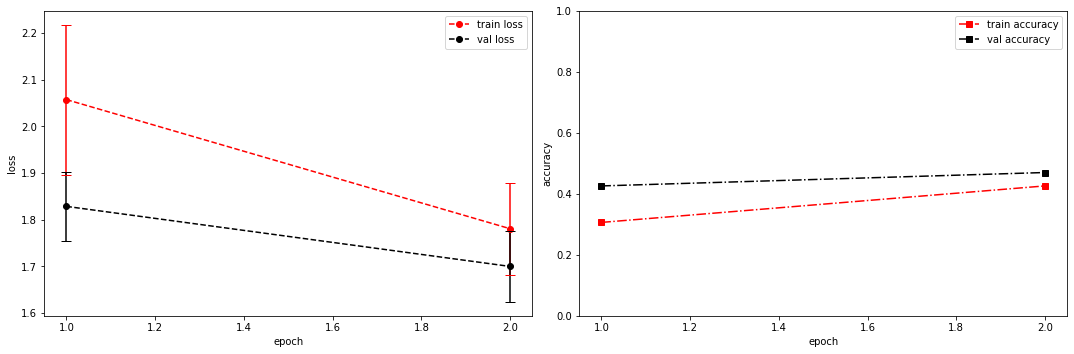

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.8092 +/- 0.0000,  accuracy: 0.0234375, time elapsed = 0.27648162841796875s
Epoch [3/100], step [17/84],  Loss: 1.6485 +/- 0.0924,  accuracy: 0.48828125, time elapsed = 0.9343984127044678s
Epoch [3/100], step [33/84],  Loss: 1.6369 +/- 0.0782,  accuracy: 0.482421875, time elapsed = 0.8811345100402832s
Epoch [3/100], step [49/84],  Loss: 1.6249 +/- 0.1125,  accuracy: 0.50390625, time elapsed = 0.9096999168395996s
Epoch [3/100], step [65/84],  Loss: 1.6021 +/- 0.1041,  accuracy: 0.51953125, time elapsed = 0.9295632839202881s
Epoch [3/100], step [81/84],  Loss: 1.5952 +/- 0.0842,  accuracy: 0.515625, time elapsed = 0.9170467853546143s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5027037106097334,  precision = 0.5027037106097334 recall = 0.5027037106097334 f1 = 0.5027037106097334 ::: val: acc = 0.44966442953020136,  precision = 0.44966442953020136 recall = 0.44966442953020136 time elapsed = 6

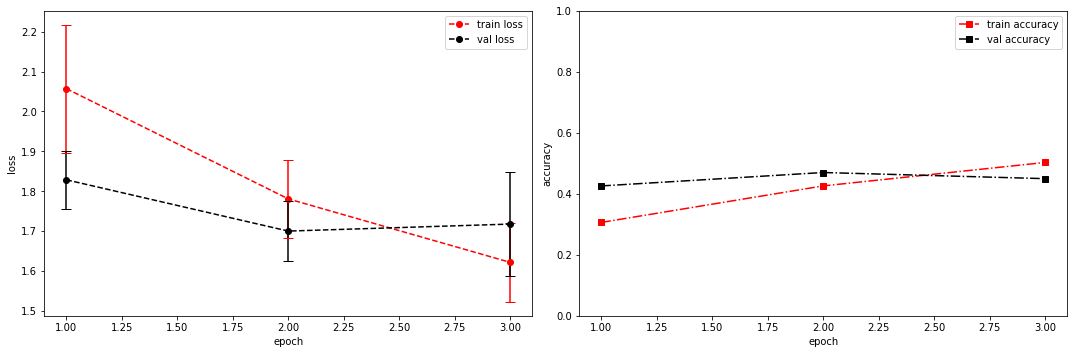

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.4431 +/- 0.0000,  accuracy: 0.03515625, time elapsed = 0.27571678161621094s
Epoch [4/100], step [17/84],  Loss: 1.5223 +/- 0.1036,  accuracy: 0.53515625, time elapsed = 0.9296000003814697s
Epoch [4/100], step [33/84],  Loss: 1.5602 +/- 0.0718,  accuracy: 0.5146484375, time elapsed = 0.9039015769958496s
Epoch [4/100], step [49/84],  Loss: 1.5002 +/- 0.0903,  accuracy: 0.537109375, time elapsed = 0.8806843757629395s
Epoch [4/100], step [65/84],  Loss: 1.4554 +/- 0.0975,  accuracy: 0.560546875, time elapsed = 0.889737606048584s
Epoch [4/100], step [81/84],  Loss: 1.4557 +/- 0.0784,  accuracy: 0.583984375, time elapsed = 0.882788896560669s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5474547827708373,  precision = 0.5474547827708373 recall = 0.5474547827708373 f1 = 0.5474547827708373 ::: val: acc = 0.5205070842654735,  precision = 0.5205070842654735 recall = 0.5205070842654735 time elapsed =

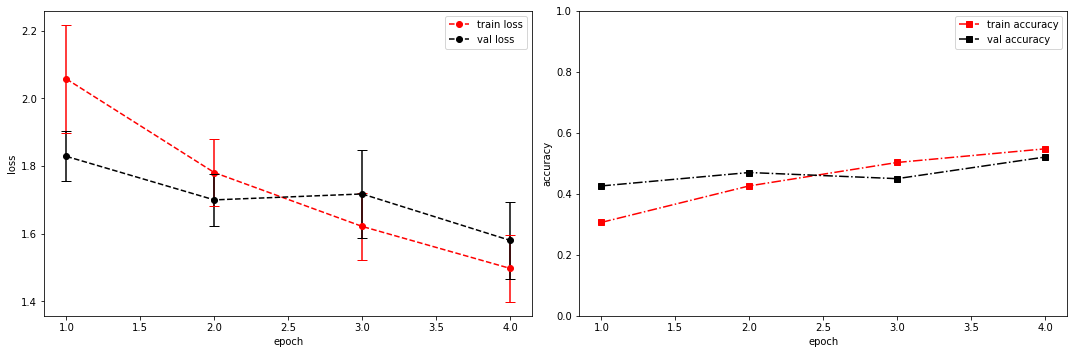

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.1354 +/- 0.0000,  accuracy: 0.046875, time elapsed = 0.2792031764984131s
Epoch [5/100], step [17/84],  Loss: 1.3460 +/- 0.0964,  accuracy: 0.6318359375, time elapsed = 0.9265003204345703s
Epoch [5/100], step [33/84],  Loss: 1.3347 +/- 0.1220,  accuracy: 0.6162109375, time elapsed = 0.9338638782501221s
Epoch [5/100], step [49/84],  Loss: 1.3257 +/- 0.0834,  accuracy: 0.62890625, time elapsed = 0.9150345325469971s
Epoch [5/100], step [65/84],  Loss: 1.3297 +/- 0.1032,  accuracy: 0.62890625, time elapsed = 0.9233334064483643s
Epoch [5/100], step [81/84],  Loss: 1.3248 +/- 0.0883,  accuracy: 0.603515625, time elapsed = 0.9024457931518555s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6218534402386724,  precision = 0.6218534402386724 recall = 0.6218534402386724 f1 = 0.6218534402386724 ::: val: acc = 0.5331841909023117,  precision = 0.5331841909023117 recall = 0.5331841909023117 time elapsed = 

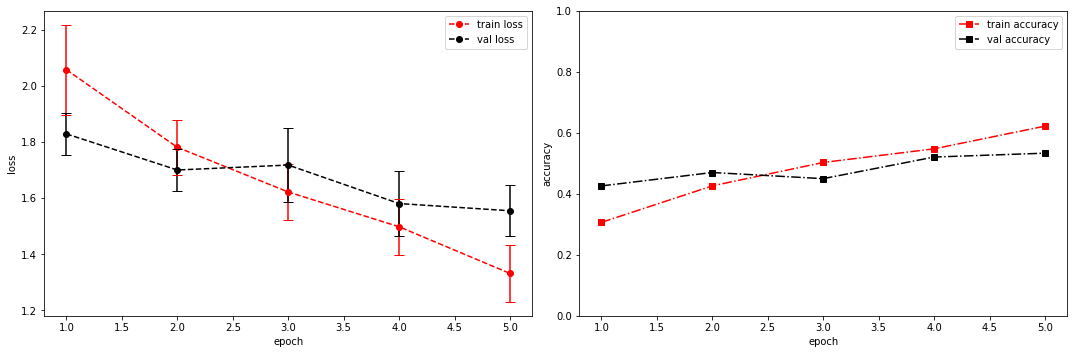

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.0276 +/- 0.0000,  accuracy: 0.0498046875, time elapsed = 0.28824639320373535s
Epoch [6/100], step [17/84],  Loss: 1.1281 +/- 0.0585,  accuracy: 0.748046875, time elapsed = 0.9103908538818359s
Epoch [6/100], step [33/84],  Loss: 1.1654 +/- 0.0729,  accuracy: 0.701171875, time elapsed = 0.9042637348175049s
Epoch [6/100], step [49/84],  Loss: 1.1161 +/- 0.0705,  accuracy: 0.7119140625, time elapsed = 0.9207518100738525s
Epoch [6/100], step [65/84],  Loss: 1.1262 +/- 0.0842,  accuracy: 0.7080078125, time elapsed = 0.9131414890289307s
Epoch [6/100], step [81/84],  Loss: 1.1540 +/- 0.0579,  accuracy: 0.69140625, time elapsed = 0.9040591716766357s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.7109826589595376,  precision = 0.7109826589595376 recall = 0.7109826589595376 f1 = 0.7109826589595376 ::: val: acc = 0.5137956748695004,  precision = 0.5137956748695004 recall = 0.5137956748695004 time elap

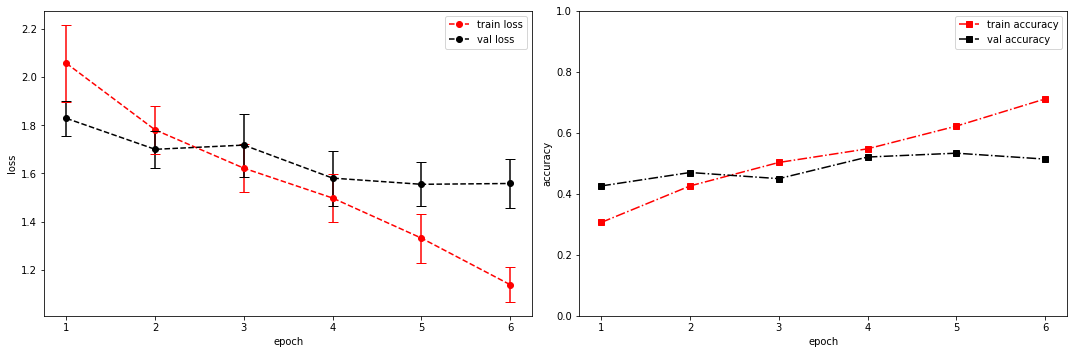

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.9352 +/- 0.0000,  accuracy: 0.052734375, time elapsed = 0.27043676376342773s
Epoch [7/100], step [17/84],  Loss: 0.9988 +/- 0.0745,  accuracy: 0.7509765625, time elapsed = 0.9337930679321289s
Epoch [7/100], step [33/84],  Loss: 1.0042 +/- 0.0790,  accuracy: 0.7578125, time elapsed = 0.9140403270721436s
Epoch [7/100], step [49/84],  Loss: 0.9619 +/- 0.0858,  accuracy: 0.7939453125, time elapsed = 0.8950028419494629s
Epoch [7/100], step [65/84],  Loss: 0.9759 +/- 0.0806,  accuracy: 0.7802734375, time elapsed = 0.8935534954071045s
Epoch [7/100], step [81/84],  Loss: 0.9884 +/- 0.0795,  accuracy: 0.759765625, time elapsed = 0.8849241733551025s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.7691590527689726,  precision = 0.7691590527689726 recall = 0.7691590527689726 f1 = 0.7691590527689726 ::: val: acc = 0.5197613721103654,  precision = 0.5197613721103654 recall = 0.5197613721103654 time elaps

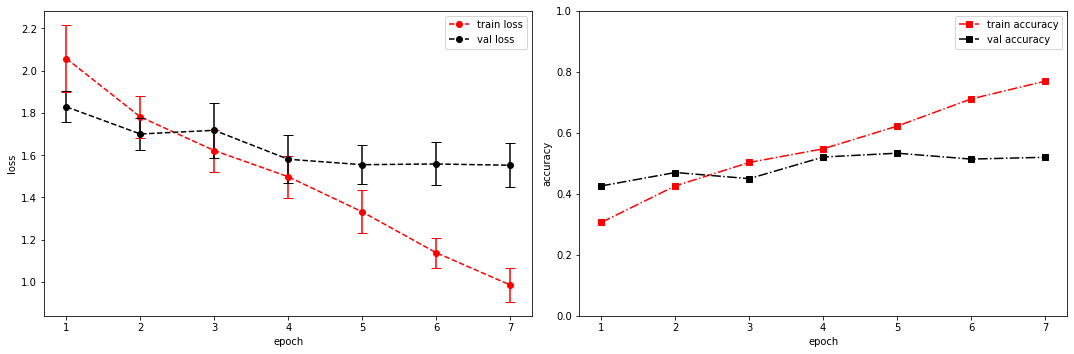

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0, 0.25]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─Re

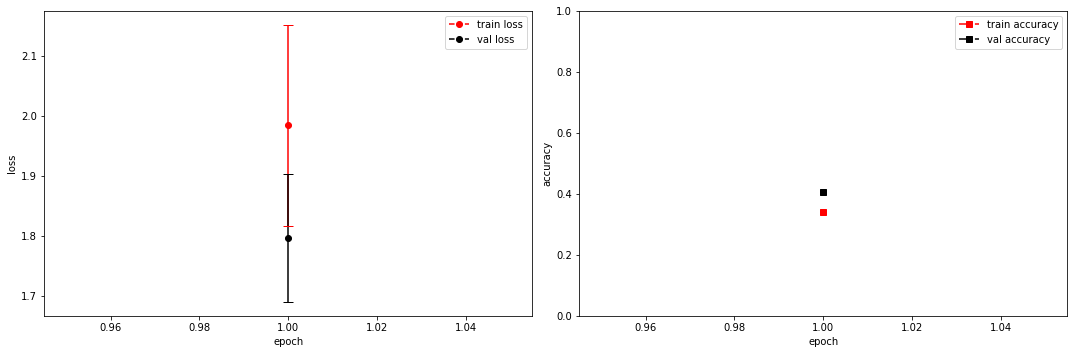

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.5727 +/- 0.0000,  accuracy: 0.0302734375, time elapsed = 0.26730871200561523s
Epoch [2/100], step [17/84],  Loss: 1.7217 +/- 0.1065,  accuracy: 0.44140625, time elapsed = 0.925788402557373s
Epoch [2/100], step [33/84],  Loss: 1.6575 +/- 0.0904,  accuracy: 0.4716796875, time elapsed = 0.8899815082550049s
Epoch [2/100], step [49/84],  Loss: 1.6610 +/- 0.1272,  accuracy: 0.4580078125, time elapsed = 0.8913240432739258s
Epoch [2/100], step [65/84],  Loss: 1.6535 +/- 0.1227,  accuracy: 0.49609375, time elapsed = 0.8865485191345215s
Epoch [2/100], step [81/84],  Loss: 1.6550 +/- 0.0911,  accuracy: 0.470703125, time elapsed = 0.9073283672332764s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.469513332090248,  precision = 0.469513332090248 recall = 0.469513332090248 f1 = 0.469513332090248 ::: val: acc = 0.4451901565995526,  precision = 0.4451901565995526 recall = 0.4451901565995526 time elapsed = 

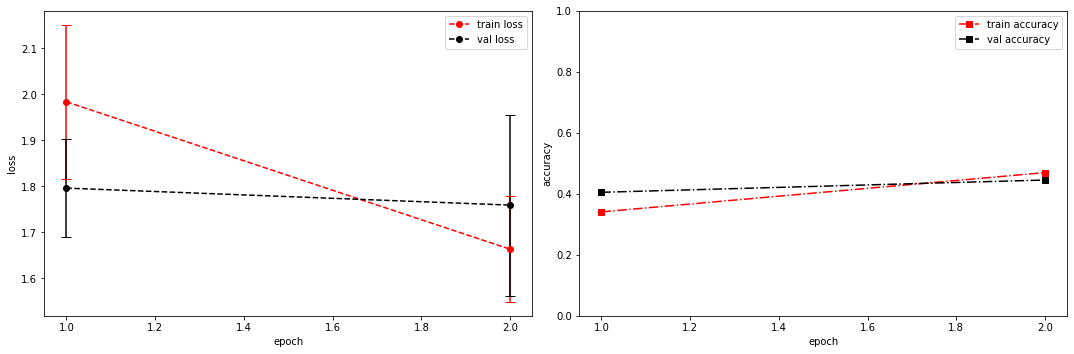

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.5587 +/- 0.0000,  accuracy: 0.029296875, time elapsed = 0.28749585151672363s
Epoch [3/100], step [17/84],  Loss: 1.4128 +/- 0.1120,  accuracy: 0.583984375, time elapsed = 0.9039225578308105s
Epoch [3/100], step [33/84],  Loss: 1.4090 +/- 0.0640,  accuracy: 0.5830078125, time elapsed = 0.9128148555755615s
Epoch [3/100], step [49/84],  Loss: 1.4577 +/- 0.1082,  accuracy: 0.54296875, time elapsed = 0.9080049991607666s
Epoch [3/100], step [65/84],  Loss: 1.4037 +/- 0.0658,  accuracy: 0.58203125, time elapsed = 0.9127874374389648s
Epoch [3/100], step [81/84],  Loss: 1.4531 +/- 0.0827,  accuracy: 0.5400390625, time elapsed = 0.9007177352905273s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5670333768413202,  precision = 0.5670333768413202 recall = 0.5670333768413202 f1 = 0.5670333768413202 ::: val: acc = 0.42953020134228187,  precision = 0.42953020134228187 recall = 0.42953020134228187 time ela

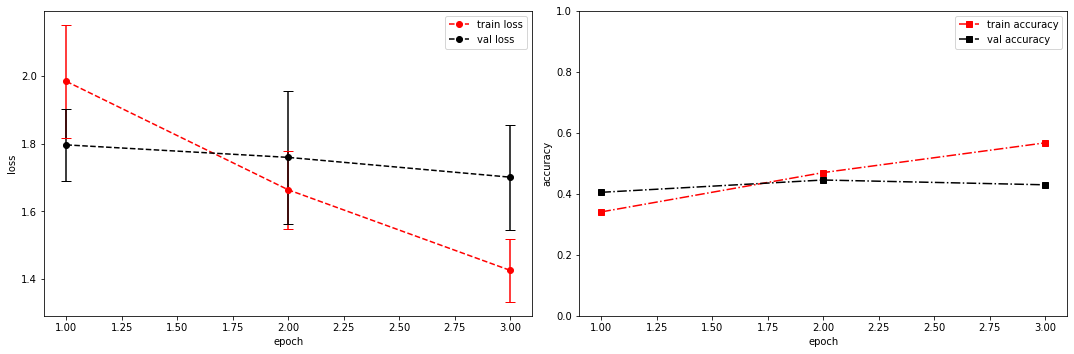

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.2374 +/- 0.0000,  accuracy: 0.0341796875, time elapsed = 0.2765178680419922s
Epoch [4/100], step [17/84],  Loss: 1.1914 +/- 0.0611,  accuracy: 0.6650390625, time elapsed = 0.9118442535400391s
Epoch [4/100], step [33/84],  Loss: 1.1396 +/- 0.0840,  accuracy: 0.7060546875, time elapsed = 0.9310121536254883s
Epoch [4/100], step [49/84],  Loss: 1.1617 +/- 0.0754,  accuracy: 0.6875, time elapsed = 0.9355940818786621s
Epoch [4/100], step [65/84],  Loss: 1.1521 +/- 0.0900,  accuracy: 0.67578125, time elapsed = 0.8855288028717041s
Epoch [4/100], step [81/84],  Loss: 1.1666 +/- 0.0734,  accuracy: 0.6669921875, time elapsed = 0.9158065319061279s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6781652060413947,  precision = 0.6781652060413947 recall = 0.6781652060413947 f1 = 0.6781652060413947 ::: val: acc = 0.49142431021625654,  precision = 0.49142431021625654 recall = 0.49142431021625654 time elapse

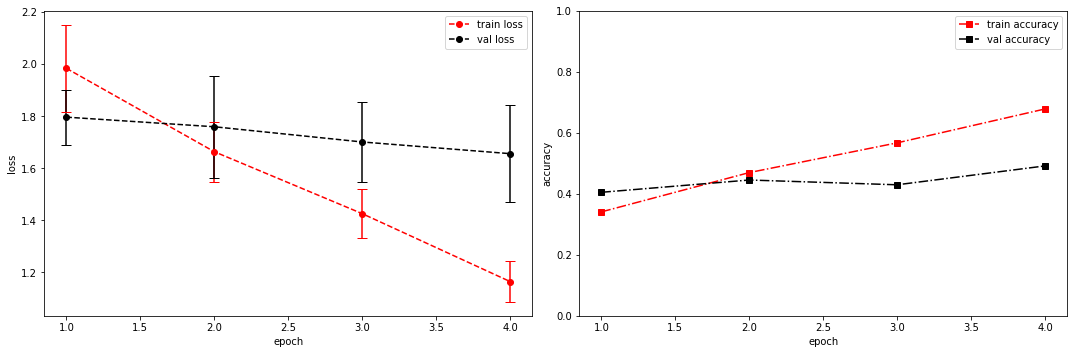

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.0943 +/- 0.0000,  accuracy: 0.04296875, time elapsed = 0.2909839153289795s
Epoch [5/100], step [17/84],  Loss: 0.9127 +/- 0.0717,  accuracy: 0.8017578125, time elapsed = 0.9266130924224854s
Epoch [5/100], step [33/84],  Loss: 0.8619 +/- 0.0951,  accuracy: 0.82421875, time elapsed = 0.9147672653198242s
Epoch [5/100], step [49/84],  Loss: 0.8916 +/- 0.0653,  accuracy: 0.7958984375, time elapsed = 0.900536298751831s
Epoch [5/100], step [65/84],  Loss: 0.9285 +/- 0.1160,  accuracy: 0.7939453125, time elapsed = 0.9158749580383301s
Epoch [5/100], step [81/84],  Loss: 0.9092 +/- 0.0925,  accuracy: 0.787109375, time elapsed = 0.8934988975524902s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.7973149356703337,  precision = 0.7973149356703337 recall = 0.7973149356703337 f1 = 0.7973149356703337 ::: val: acc = 0.47129008202833705,  precision = 0.47129008202833705 recall = 0.47129008202833705 time elap

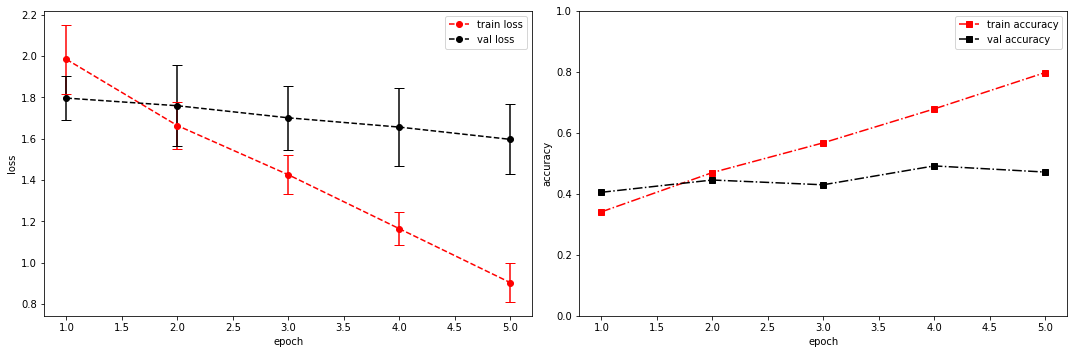

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 0.7542 +/- 0.0000,  accuracy: 0.0556640625, time elapsed = 0.2752819061279297s
Epoch [6/100], step [17/84],  Loss: 0.6936 +/- 0.0665,  accuracy: 0.89453125, time elapsed = 0.8993871212005615s
Epoch [6/100], step [33/84],  Loss: 0.6714 +/- 0.0685,  accuracy: 0.9072265625, time elapsed = 0.8867714405059814s
Epoch [6/100], step [49/84],  Loss: 0.6509 +/- 0.0647,  accuracy: 0.8994140625, time elapsed = 0.8935177326202393s
Epoch [6/100], step [65/84],  Loss: 0.6523 +/- 0.0691,  accuracy: 0.8818359375, time elapsed = 0.9160921573638916s
Epoch [6/100], step [81/84],  Loss: 0.6246 +/- 0.0434,  accuracy: 0.916015625, time elapsed = 0.8752093315124512s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.8996830132388588,  precision = 0.8996830132388588 recall = 0.8996830132388588 f1 = 0.8996830132388588 ::: val: acc = 0.49515287099179717,  precision = 0.49515287099179717 recall = 0.49515287099179717 time e

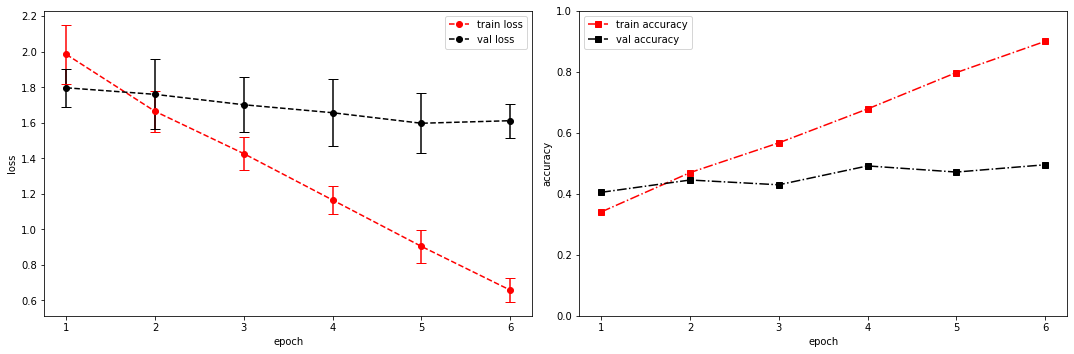

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.4686 +/- 0.0000,  accuracy: 0.0615234375, time elapsed = 0.2842409610748291s
Epoch [7/100], step [17/84],  Loss: 0.4991 +/- 0.0359,  accuracy: 0.9521484375, time elapsed = 0.9050772190093994s
Epoch [7/100], step [33/84],  Loss: 0.4928 +/- 0.0431,  accuracy: 0.955078125, time elapsed = 0.8952257633209229s
Epoch [7/100], step [49/84],  Loss: 0.4583 +/- 0.0406,  accuracy: 0.9658203125, time elapsed = 0.9035964012145996s
Epoch [7/100], step [65/84],  Loss: 0.4544 +/- 0.0424,  accuracy: 0.9580078125, time elapsed = 0.8849153518676758s
Epoch [7/100], step [81/84],  Loss: 0.4669 +/- 0.0403,  accuracy: 0.955078125, time elapsed = 0.8838069438934326s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9578594070482939,  precision = 0.9578594070482939 recall = 0.9578594070482939 f1 = 0.9578594070482939 ::: val: acc = 0.47874720357941836,  precision = 0.47874720357941836 recall = 0.47874720357941836 time 

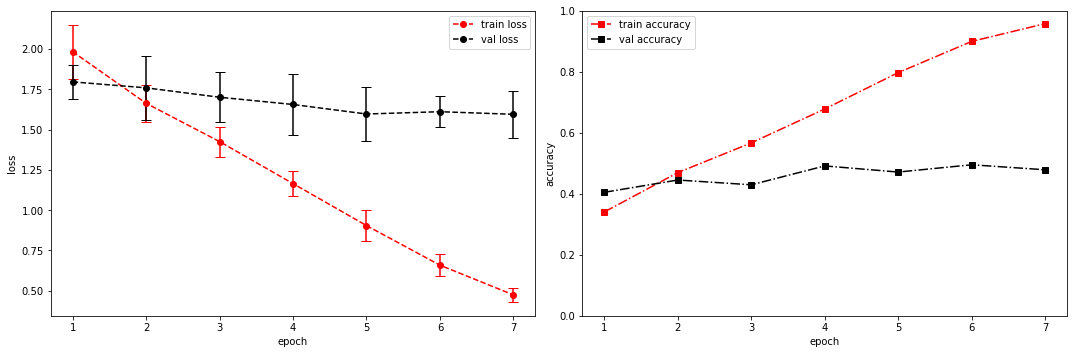

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0.1, 0.25]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─

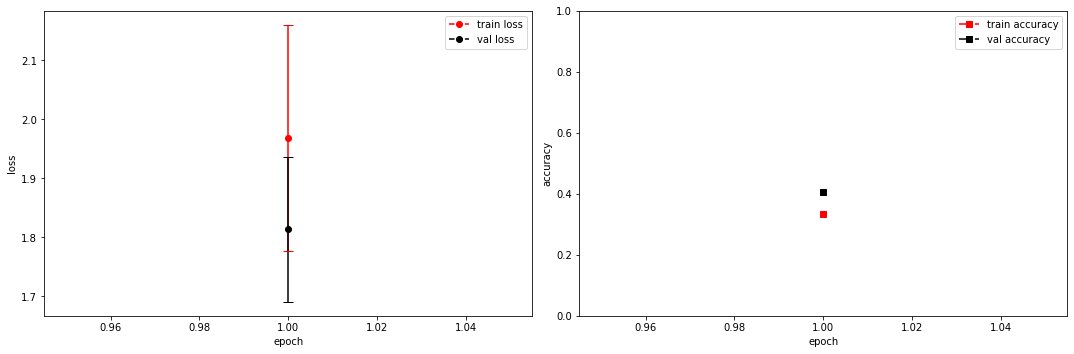

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.8296 +/- 0.0000,  accuracy: 0.0205078125, time elapsed = 0.27117347717285156s
Epoch [2/100], step [17/84],  Loss: 1.7232 +/- 0.0953,  accuracy: 0.4501953125, time elapsed = 0.9302966594696045s
Epoch [2/100], step [33/84],  Loss: 1.6886 +/- 0.0788,  accuracy: 0.451171875, time elapsed = 0.8983285427093506s
Epoch [2/100], step [49/84],  Loss: 1.6453 +/- 0.1058,  accuracy: 0.484375, time elapsed = 0.8882110118865967s
Epoch [2/100], step [65/84],  Loss: 1.6134 +/- 0.0921,  accuracy: 0.4833984375, time elapsed = 0.8912112712860107s
Epoch [2/100], step [81/84],  Loss: 1.5611 +/- 0.0746,  accuracy: 0.5107421875, time elapsed = 0.9109644889831543s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.4765989185157561,  precision = 0.4765989185157561 recall = 0.4765989185157561 f1 = 0.4765989185157561 ::: val: acc = 0.46308724832214765,  precision = 0.46308724832214765 recall = 0.46308724832214765 time el

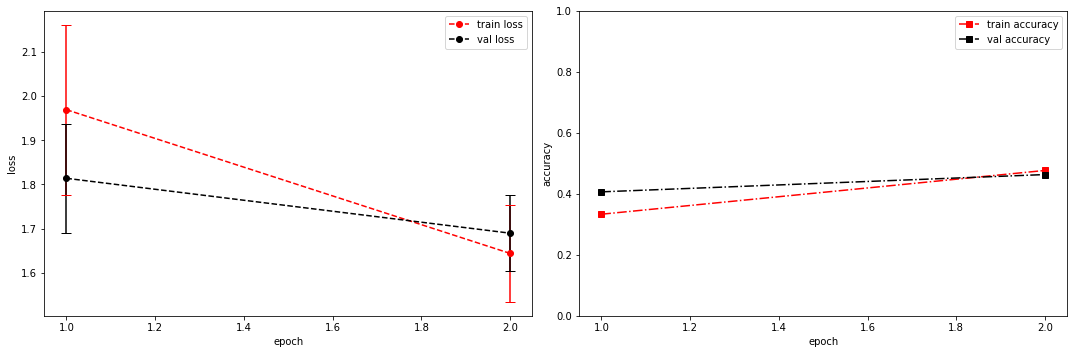

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.3533 +/- 0.0000,  accuracy: 0.037109375, time elapsed = 0.27371740341186523s
Epoch [3/100], step [17/84],  Loss: 1.4494 +/- 0.0820,  accuracy: 0.5546875, time elapsed = 0.9120442867279053s
Epoch [3/100], step [33/84],  Loss: 1.4625 +/- 0.0887,  accuracy: 0.5576171875, time elapsed = 0.9236366748809814s
Epoch [3/100], step [49/84],  Loss: 1.4147 +/- 0.0832,  accuracy: 0.5849609375, time elapsed = 0.9011549949645996s
Epoch [3/100], step [65/84],  Loss: 1.3971 +/- 0.1198,  accuracy: 0.583984375, time elapsed = 0.8936841487884521s
Epoch [3/100], step [81/84],  Loss: 1.4320 +/- 0.1240,  accuracy: 0.552734375, time elapsed = 1.019186019897461s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5659146000372925,  precision = 0.5659146000372925 recall = 0.5659146000372925 f1 = 0.5659146000372925 ::: val: acc = 0.47129008202833705,  precision = 0.47129008202833705 recall = 0.47129008202833705 time elap

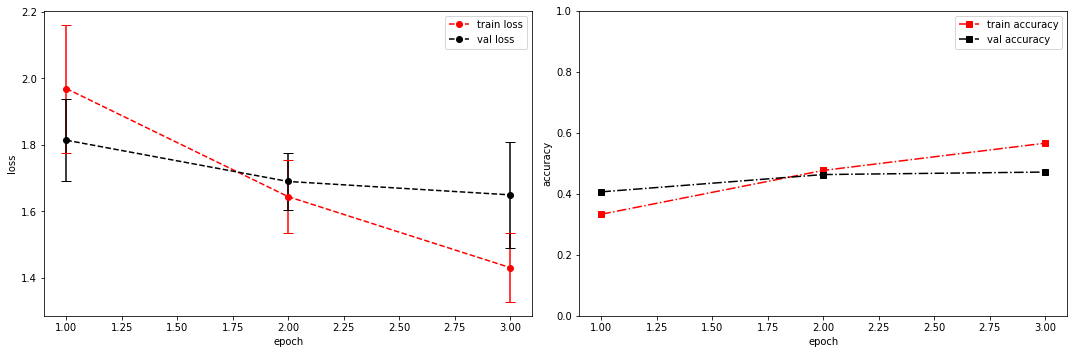

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.1564 +/- 0.0000,  accuracy: 0.04296875, time elapsed = 0.26644134521484375s
Epoch [4/100], step [17/84],  Loss: 1.2071 +/- 0.1044,  accuracy: 0.6708984375, time elapsed = 0.9152069091796875s
Epoch [4/100], step [33/84],  Loss: 1.1817 +/- 0.1203,  accuracy: 0.6982421875, time elapsed = 0.9188239574432373s
Epoch [4/100], step [49/84],  Loss: 1.2366 +/- 0.0947,  accuracy: 0.6484375, time elapsed = 0.9007034301757812s
Epoch [4/100], step [65/84],  Loss: 1.1810 +/- 0.0783,  accuracy: 0.6826171875, time elapsed = 0.8926126956939697s
Epoch [4/100], step [81/84],  Loss: 1.1933 +/- 0.1135,  accuracy: 0.6650390625, time elapsed = 0.8978164196014404s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6716390080179004,  precision = 0.6716390080179004 recall = 0.6716390080179004 f1 = 0.6716390080179004 ::: val: acc = 0.47054436987322895,  precision = 0.47054436987322895 recall = 0.47054436987322895 time el

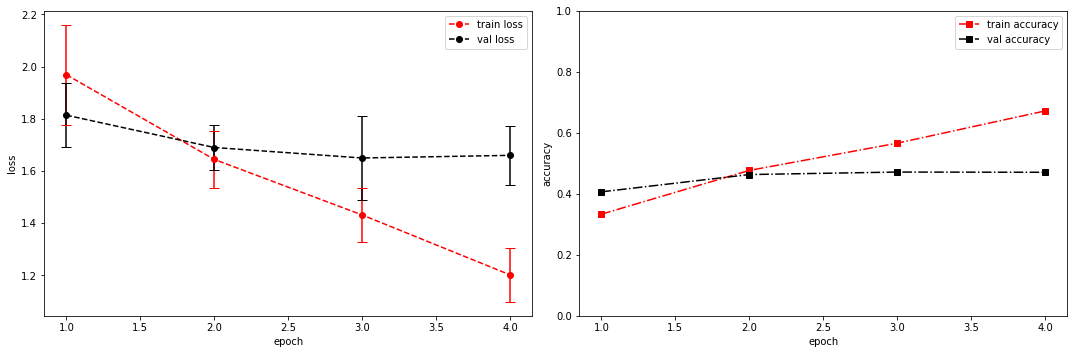

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 0.9949 +/- 0.0000,  accuracy: 0.0478515625, time elapsed = 0.2620248794555664s
Epoch [5/100], step [17/84],  Loss: 0.9991 +/- 0.0726,  accuracy: 0.7783203125, time elapsed = 0.9185988903045654s
Epoch [5/100], step [33/84],  Loss: 0.9744 +/- 0.0582,  accuracy: 0.7734375, time elapsed = 0.9135782718658447s
Epoch [5/100], step [49/84],  Loss: 0.9324 +/- 0.0540,  accuracy: 0.7900390625, time elapsed = 0.8924319744110107s
Epoch [5/100], step [65/84],  Loss: 0.9804 +/- 0.0902,  accuracy: 0.76953125, time elapsed = 0.890275239944458s
Epoch [5/100], step [81/84],  Loss: 0.9707 +/- 0.0567,  accuracy: 0.76171875, time elapsed = 0.90439772605896s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.7728883087823979,  precision = 0.7728883087823979 recall = 0.7728883087823979 f1 = 0.7728883087823978 ::: val: acc = 0.4899328859060403,  precision = 0.4899328859060403 recall = 0.4899328859060403 time elapsed = 6

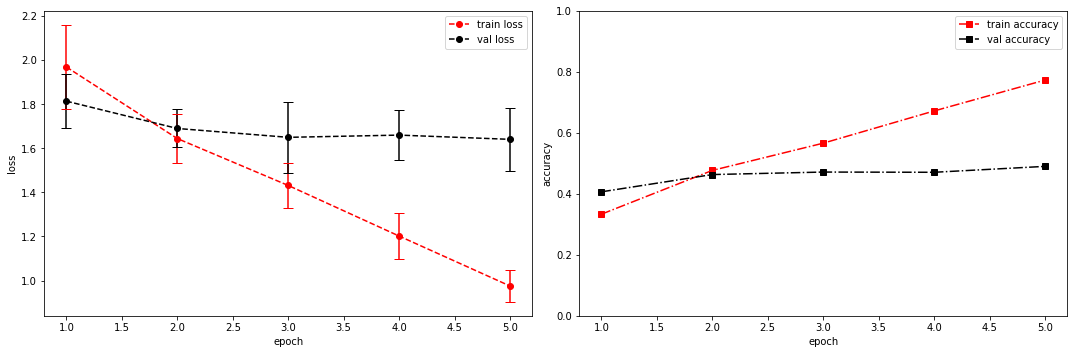

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 0.7534 +/- 0.0000,  accuracy: 0.0537109375, time elapsed = 0.26918816566467285s
Epoch [6/100], step [17/84],  Loss: 0.7781 +/- 0.0580,  accuracy: 0.865234375, time elapsed = 0.898916482925415s
Epoch [6/100], step [33/84],  Loss: 0.7494 +/- 0.0624,  accuracy: 0.8896484375, time elapsed = 0.8900332450866699s
Epoch [6/100], step [49/84],  Loss: 0.7211 +/- 0.0538,  accuracy: 0.880859375, time elapsed = 0.8926918506622314s
Epoch [6/100], step [65/84],  Loss: 0.7359 +/- 0.0654,  accuracy: 0.875, time elapsed = 0.8835313320159912s
Epoch [6/100], step [81/84],  Loss: 0.7396 +/- 0.0535,  accuracy: 0.8828125, time elapsed = 0.8916347026824951s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.8774939399589782,  precision = 0.8774939399589782 recall = 0.8774939399589782 f1 = 0.8774939399589782 ::: val: acc = 0.5018642803877703,  precision = 0.5018642803877703 recall = 0.5018642803877703 time elapsed = 6.3

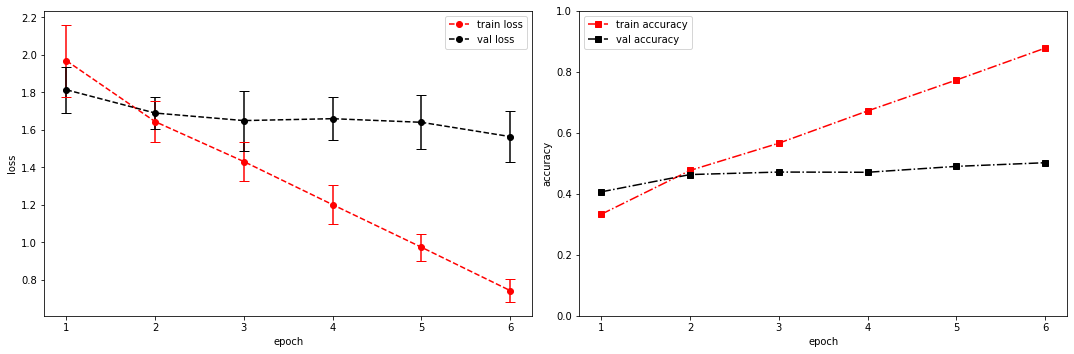

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.6139 +/- 0.0000,  accuracy: 0.056640625, time elapsed = 0.27549195289611816s
Epoch [7/100], step [17/84],  Loss: 0.5547 +/- 0.0395,  accuracy: 0.9384765625, time elapsed = 0.9099791049957275s
Epoch [7/100], step [33/84],  Loss: 0.5418 +/- 0.0511,  accuracy: 0.9443359375, time elapsed = 0.8892087936401367s
Epoch [7/100], step [49/84],  Loss: 0.5584 +/- 0.0569,  accuracy: 0.9345703125, time elapsed = 0.9029810428619385s
Epoch [7/100], step [65/84],  Loss: 0.5599 +/- 0.0476,  accuracy: 0.9453125, time elapsed = 0.8832037448883057s
Epoch [7/100], step [81/84],  Loss: 0.5311 +/- 0.0276,  accuracy: 0.927734375, time elapsed = 0.9046261310577393s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.9380943501771397,  precision = 0.9380943501771397 recall = 0.9380943501771397 f1 = 0.9380943501771397 ::: val: acc = 0.5041014168530947,  precision = 0.5041014168530947 recall = 0.5041014168530947 time elaps

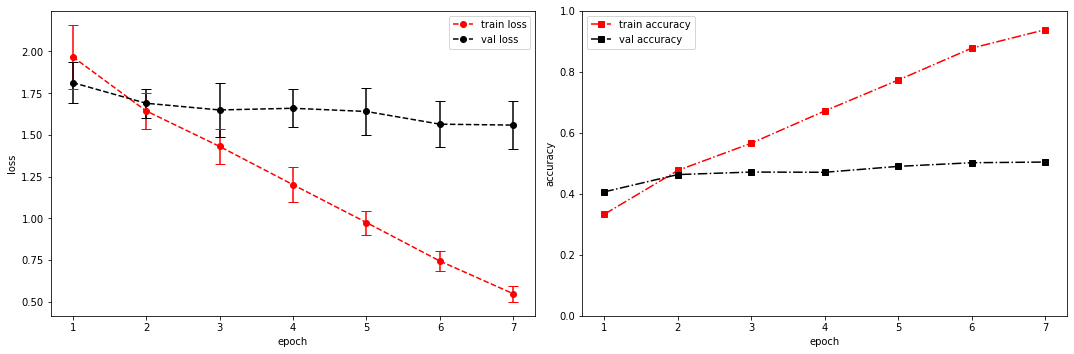

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0.25, 0.25]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └

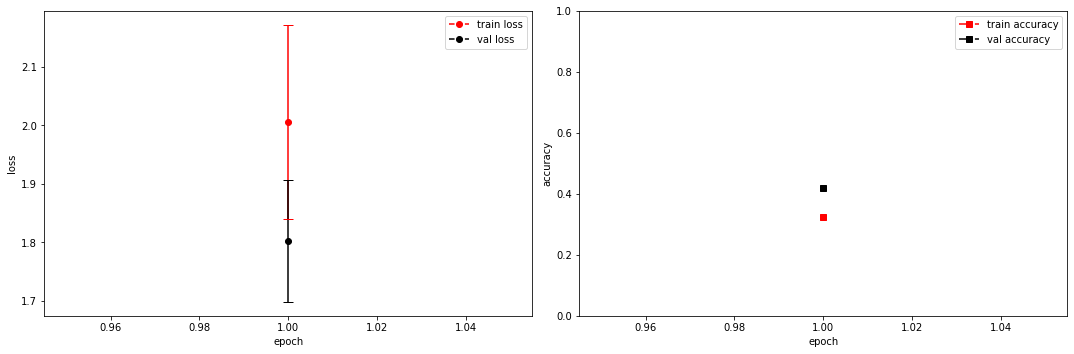

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.8052 +/- 0.0000,  accuracy: 0.021484375, time elapsed = 0.26367688179016113s
Epoch [2/100], step [17/84],  Loss: 1.7405 +/- 0.1184,  accuracy: 0.4267578125, time elapsed = 0.9286930561065674s
Epoch [2/100], step [33/84],  Loss: 1.7392 +/- 0.0924,  accuracy: 0.4267578125, time elapsed = 0.9092104434967041s
Epoch [2/100], step [49/84],  Loss: 1.7013 +/- 0.0917,  accuracy: 0.4560546875, time elapsed = 0.8991279602050781s
Epoch [2/100], step [65/84],  Loss: 1.6892 +/- 0.1059,  accuracy: 0.466796875, time elapsed = 0.9096391201019287s
Epoch [2/100], step [81/84],  Loss: 1.6711 +/- 0.0792,  accuracy: 0.4677734375, time elapsed = 0.8920722007751465s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.44676487040835355,  precision = 0.44676487040835355 recall = 0.44676487040835355 f1 = 0.4467648704083536 ::: val: acc = 0.4526472781506339,  precision = 0.4526472781506339 recall = 0.4526472781506339 time

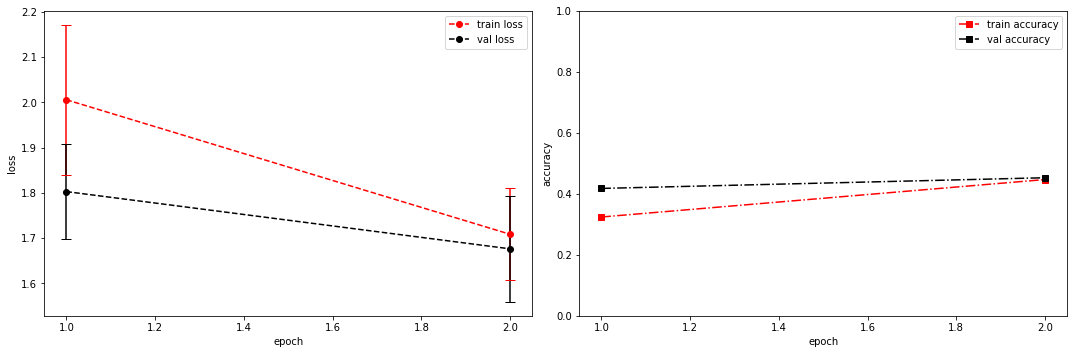

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.5877 +/- 0.0000,  accuracy: 0.029296875, time elapsed = 0.2775390148162842s
Epoch [3/100], step [17/84],  Loss: 1.5300 +/- 0.1015,  accuracy: 0.53125, time elapsed = 0.9219081401824951s
Epoch [3/100], step [33/84],  Loss: 1.5381 +/- 0.0814,  accuracy: 0.5224609375, time elapsed = 0.925931453704834s
Epoch [3/100], step [49/84],  Loss: 1.4840 +/- 0.0761,  accuracy: 0.5322265625, time elapsed = 0.9339683055877686s
Epoch [3/100], step [65/84],  Loss: 1.5124 +/- 0.1082,  accuracy: 0.5380859375, time elapsed = 0.9333786964416504s
Epoch [3/100], step [81/84],  Loss: 1.5393 +/- 0.1306,  accuracy: 0.5185546875, time elapsed = 0.9194467067718506s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5261980234943129,  precision = 0.5261980234943129 recall = 0.5261980234943129 f1 = 0.5261980234943129 ::: val: acc = 0.4272930648769575,  precision = 0.4272930648769575 recall = 0.4272930648769575 time elapsed 

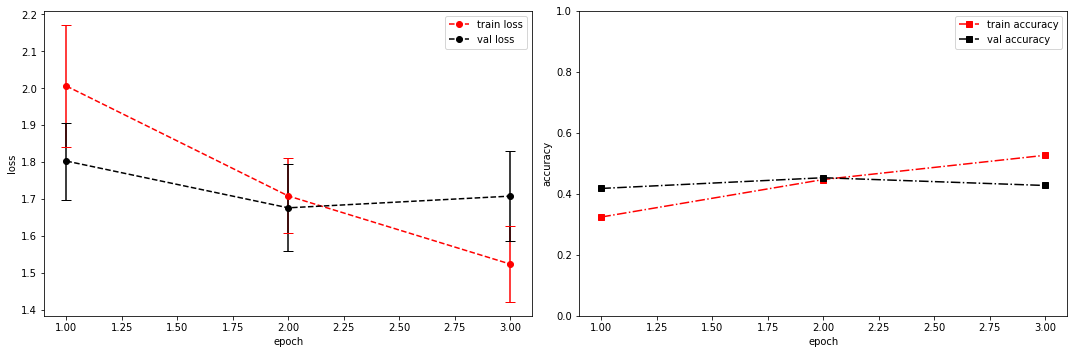

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.4298 +/- 0.0000,  accuracy: 0.0341796875, time elapsed = 0.2665135860443115s
Epoch [4/100], step [17/84],  Loss: 1.3522 +/- 0.0716,  accuracy: 0.6044921875, time elapsed = 0.9312117099761963s
Epoch [4/100], step [33/84],  Loss: 1.3551 +/- 0.0871,  accuracy: 0.6005859375, time elapsed = 0.9333207607269287s
Epoch [4/100], step [49/84],  Loss: 1.3462 +/- 0.0861,  accuracy: 0.603515625, time elapsed = 0.9224843978881836s
Epoch [4/100], step [65/84],  Loss: 1.3349 +/- 0.1149,  accuracy: 0.591796875, time elapsed = 0.9193706512451172s
Epoch [4/100], step [81/84],  Loss: 1.3268 +/- 0.0870,  accuracy: 0.59375, time elapsed = 0.9082958698272705s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5979862017527503,  precision = 0.5979862017527503 recall = 0.5979862017527503 f1 = 0.5979862017527503 ::: val: acc = 0.5070842654735273,  precision = 0.5070842654735273 recall = 0.5070842654735273 time elapsed 

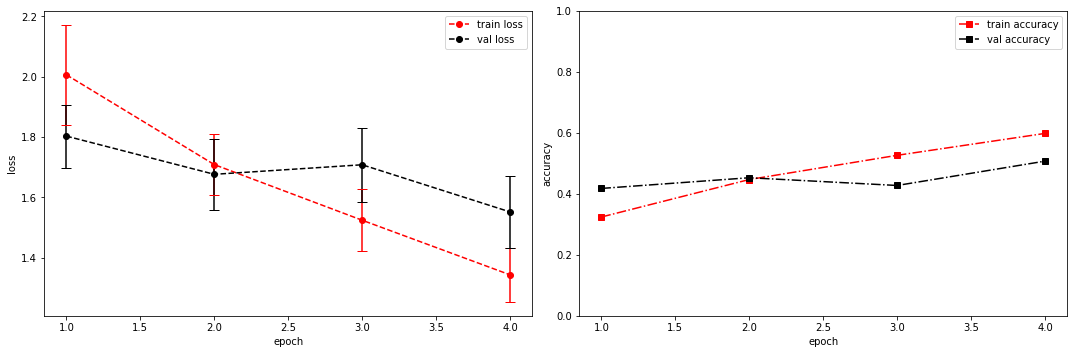

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.1279 +/- 0.0000,  accuracy: 0.0458984375, time elapsed = 0.27918076515197754s
Epoch [5/100], step [17/84],  Loss: 1.1498 +/- 0.0593,  accuracy: 0.673828125, time elapsed = 0.9200143814086914s
Epoch [5/100], step [33/84],  Loss: 1.1269 +/- 0.0779,  accuracy: 0.7060546875, time elapsed = 0.909066915512085s
Epoch [5/100], step [49/84],  Loss: 1.1191 +/- 0.0741,  accuracy: 0.7041015625, time elapsed = 0.914064884185791s
Epoch [5/100], step [65/84],  Loss: 1.1196 +/- 0.1000,  accuracy: 0.7021484375, time elapsed = 0.8904180526733398s
Epoch [5/100], step [81/84],  Loss: 1.1170 +/- 0.0753,  accuracy: 0.7119140625, time elapsed = 0.8885760307312012s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6988625769159053,  precision = 0.6988625769159053 recall = 0.6988625769159053 f1 = 0.6988625769159053 ::: val: acc = 0.5324384787472036,  precision = 0.5324384787472036 recall = 0.5324384787472036 time ela

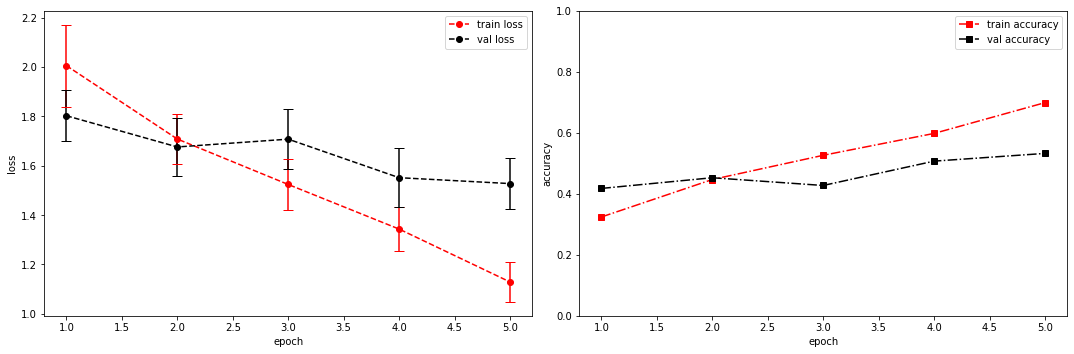

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 0.8652 +/- 0.0000,  accuracy: 0.048828125, time elapsed = 0.2721564769744873s
Epoch [6/100], step [17/84],  Loss: 0.9426 +/- 0.0645,  accuracy: 0.7841796875, time elapsed = 0.9256932735443115s
Epoch [6/100], step [33/84],  Loss: 0.9206 +/- 0.0783,  accuracy: 0.7939453125, time elapsed = 0.8999307155609131s
Epoch [6/100], step [49/84],  Loss: 0.9162 +/- 0.0859,  accuracy: 0.7802734375, time elapsed = 0.8898372650146484s
Epoch [6/100], step [65/84],  Loss: 0.9061 +/- 0.0469,  accuracy: 0.783203125, time elapsed = 0.9095525741577148s
Epoch [6/100], step [81/84],  Loss: 0.9148 +/- 0.0952,  accuracy: 0.771484375, time elapsed = 0.8900017738342285s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.7833302256199888,  precision = 0.7833302256199888 recall = 0.7833302256199888 f1 = 0.7833302256199888 ::: val: acc = 0.522744220730798,  precision = 0.522744220730798 recall = 0.522744220730798 time elapsed

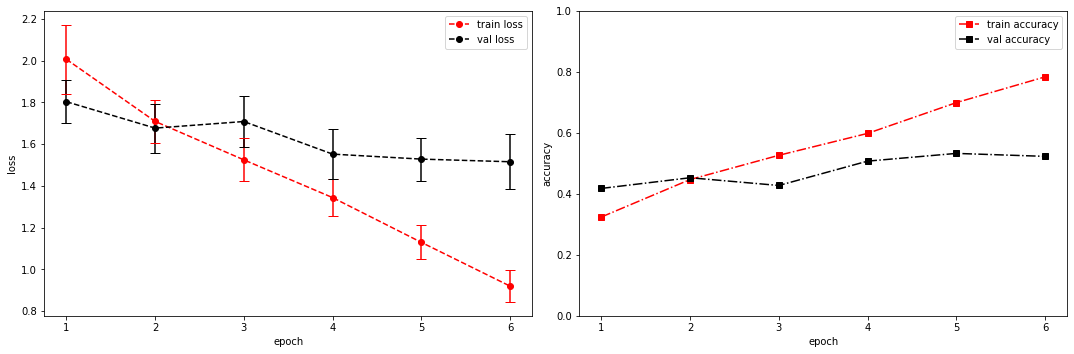

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.8118 +/- 0.0000,  accuracy: 0.052734375, time elapsed = 0.29071044921875s
Epoch [7/100], step [17/84],  Loss: 0.7268 +/- 0.0789,  accuracy: 0.8759765625, time elapsed = 0.9402143955230713s
Epoch [7/100], step [33/84],  Loss: 0.7168 +/- 0.0475,  accuracy: 0.8759765625, time elapsed = 0.9641697406768799s
Epoch [7/100], step [49/84],  Loss: 0.7249 +/- 0.0636,  accuracy: 0.865234375, time elapsed = 0.9044189453125s
Epoch [7/100], step [65/84],  Loss: 0.7378 +/- 0.0722,  accuracy: 0.861328125, time elapsed = 0.8908288478851318s
Epoch [7/100], step [81/84],  Loss: 0.7335 +/- 0.0563,  accuracy: 0.8583984375, time elapsed = 0.8851437568664551s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.8653738579153459,  precision = 0.8653738579153459 recall = 0.8653738579153459 f1 = 0.8653738579153459 ::: val: acc = 0.5197613721103654,  precision = 0.5197613721103654 recall = 0.5197613721103654 time elapsed =

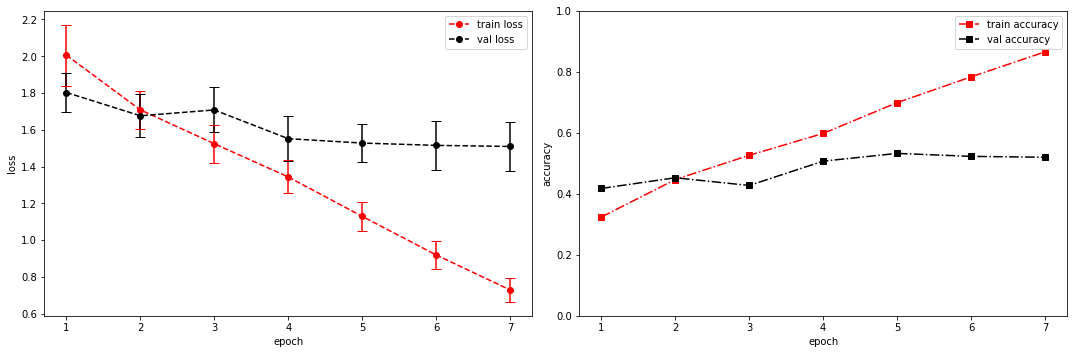

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0.5, 0.25]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─

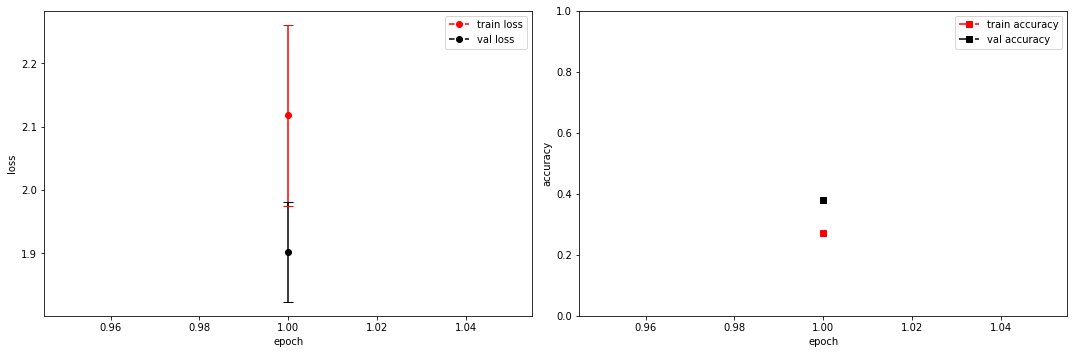

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.9724 +/- 0.0000,  accuracy: 0.0224609375, time elapsed = 0.29761695861816406s
Epoch [2/100], step [17/84],  Loss: 1.9223 +/- 0.0827,  accuracy: 0.3603515625, time elapsed = 0.9308805465698242s
Epoch [2/100], step [33/84],  Loss: 1.8681 +/- 0.1058,  accuracy: 0.4072265625, time elapsed = 0.9485726356506348s
Epoch [2/100], step [49/84],  Loss: 1.8862 +/- 0.1040,  accuracy: 0.408203125, time elapsed = 0.9501514434814453s
Epoch [2/100], step [65/84],  Loss: 1.8977 +/- 0.0671,  accuracy: 0.384765625, time elapsed = 0.9585297107696533s
Epoch [2/100], step [81/84],  Loss: 1.8628 +/- 0.0743,  accuracy: 0.3916015625, time elapsed = 0.9409265518188477s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.39063956740630246,  precision = 0.39063956740630246 recall = 0.39063956740630246 f1 = 0.39063956740630246 ::: val: acc = 0.42654735272184935,  precision = 0.42654735272184935 recall = 0.42654735272184935 

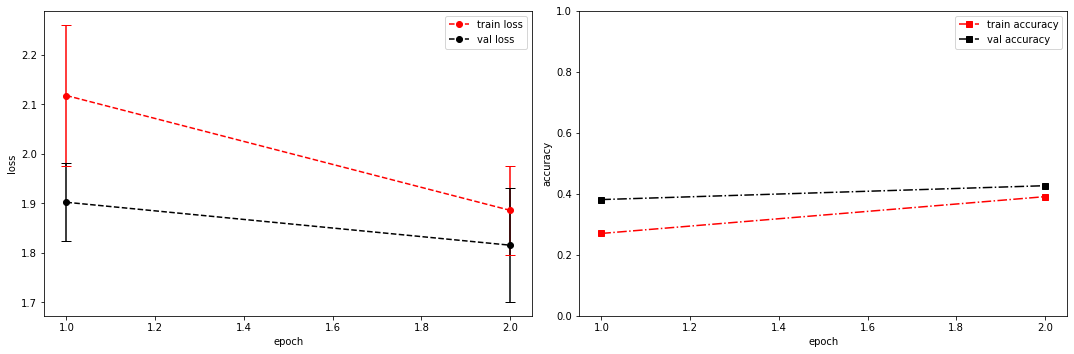

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.6731 +/- 0.0000,  accuracy: 0.0341796875, time elapsed = 0.2973942756652832s
Epoch [3/100], step [17/84],  Loss: 1.7498 +/- 0.0919,  accuracy: 0.466796875, time elapsed = 0.9619033336639404s
Epoch [3/100], step [33/84],  Loss: 1.7529 +/- 0.1158,  accuracy: 0.4482421875, time elapsed = 0.8875315189361572s
Epoch [3/100], step [49/84],  Loss: 1.7337 +/- 0.1325,  accuracy: 0.4541015625, time elapsed = 0.9024732112884521s
Epoch [3/100], step [65/84],  Loss: 1.7378 +/- 0.0926,  accuracy: 0.4404296875, time elapsed = 0.8841667175292969s
Epoch [3/100], step [81/84],  Loss: 1.7114 +/- 0.1165,  accuracy: 0.4619140625, time elapsed = 0.8870103359222412s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.45478277083721796,  precision = 0.45478277083721796 recall = 0.45478277083721796 f1 = 0.45478277083721796 ::: val: acc = 0.4541387024608501,  precision = 0.4541387024608501 recall = 0.4541387024608501 tim

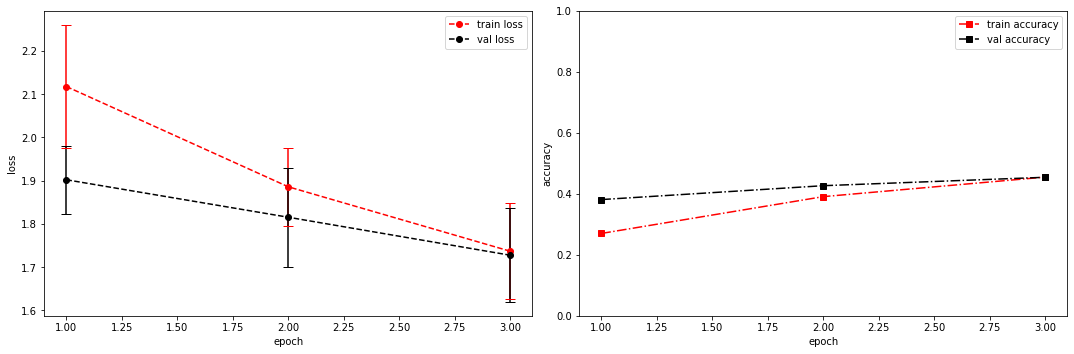

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.7727 +/- 0.0000,  accuracy: 0.03125, time elapsed = 0.28082942962646484s
Epoch [4/100], step [17/84],  Loss: 1.6019 +/- 0.0831,  accuracy: 0.4951171875, time elapsed = 0.9453473091125488s
Epoch [4/100], step [33/84],  Loss: 1.6278 +/- 0.1290,  accuracy: 0.48828125, time elapsed = 0.9321520328521729s
Epoch [4/100], step [49/84],  Loss: 1.5866 +/- 0.0794,  accuracy: 0.50390625, time elapsed = 0.9087231159210205s
Epoch [4/100], step [65/84],  Loss: 1.6317 +/- 0.1175,  accuracy: 0.4853515625, time elapsed = 0.9031014442443848s
Epoch [4/100], step [81/84],  Loss: 1.6190 +/- 0.0939,  accuracy: 0.4921875, time elapsed = 0.9480199813842773s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.49449934738019763,  precision = 0.49449934738019763 recall = 0.49449934738019763 f1 = 0.49449934738019763 ::: val: acc = 0.4750186428038777,  precision = 0.4750186428038777 recall = 0.4750186428038777 time elapsed 

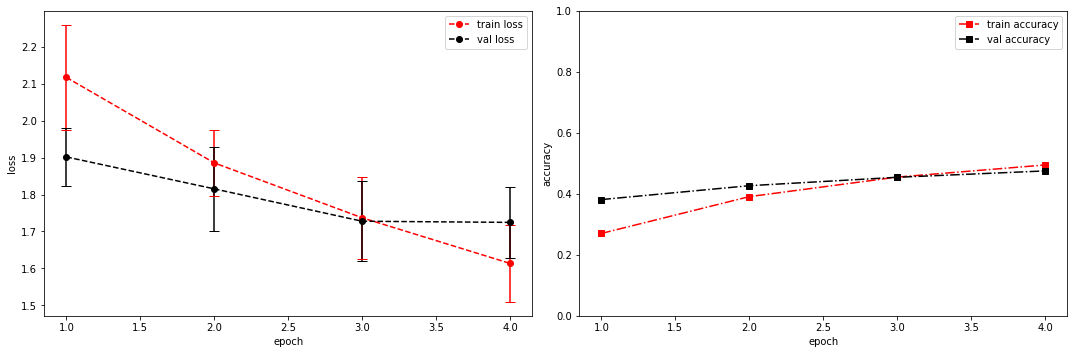

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.4531 +/- 0.0000,  accuracy: 0.0361328125, time elapsed = 0.2901489734649658s
Epoch [5/100], step [17/84],  Loss: 1.5050 +/- 0.0994,  accuracy: 0.5390625, time elapsed = 0.9432501792907715s
Epoch [5/100], step [33/84],  Loss: 1.4811 +/- 0.0785,  accuracy: 0.5615234375, time elapsed = 0.9336674213409424s
Epoch [5/100], step [49/84],  Loss: 1.4766 +/- 0.0770,  accuracy: 0.556640625, time elapsed = 0.9204189777374268s
Epoch [5/100], step [65/84],  Loss: 1.5068 +/- 0.0920,  accuracy: 0.51953125, time elapsed = 0.9333868026733398s
Epoch [5/100], step [81/84],  Loss: 1.5085 +/- 0.0843,  accuracy: 0.54296875, time elapsed = 0.9356451034545898s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5439119895580832,  precision = 0.5439119895580832 recall = 0.5439119895580832 f1 = 0.5439119895580832 ::: val: acc = 0.4899328859060403,  precision = 0.4899328859060403 recall = 0.4899328859060403 time elapsed =

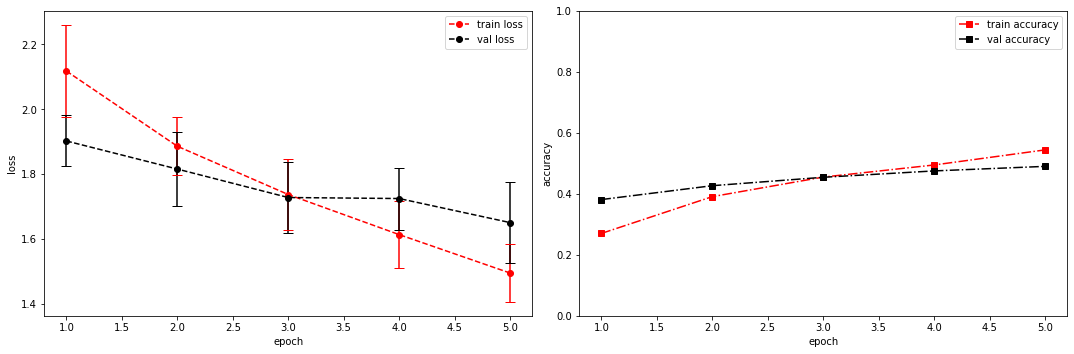

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.4779 +/- 0.0000,  accuracy: 0.0341796875, time elapsed = 0.2867701053619385s
Epoch [6/100], step [17/84],  Loss: 1.3722 +/- 0.0865,  accuracy: 0.619140625, time elapsed = 0.9399285316467285s
Epoch [6/100], step [33/84],  Loss: 1.3511 +/- 0.0867,  accuracy: 0.61328125, time elapsed = 0.9261221885681152s
Epoch [6/100], step [49/84],  Loss: 1.3388 +/- 0.0764,  accuracy: 0.6181640625, time elapsed = 0.9404034614562988s
Epoch [6/100], step [65/84],  Loss: 1.3081 +/- 0.0660,  accuracy: 0.60546875, time elapsed = 0.9274697303771973s
Epoch [6/100], step [81/84],  Loss: 1.3133 +/- 0.0860,  accuracy: 0.6259765625, time elapsed = 0.9793591499328613s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6160730934178631,  precision = 0.6160730934178631 recall = 0.6160730934178631 f1 = 0.6160730934178631 ::: val: acc = 0.506338553318419,  precision = 0.506338553318419 recall = 0.506338553318419 time elapsed =

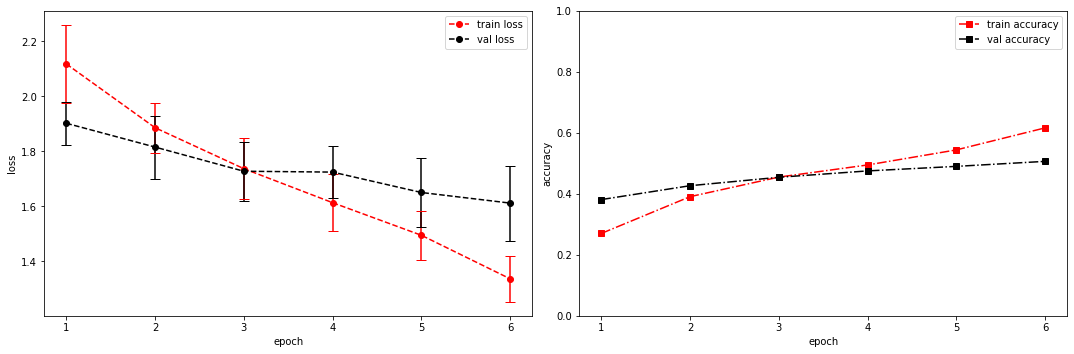

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 1.1329 +/- 0.0000,  accuracy: 0.0458984375, time elapsed = 0.2840304374694824s
Epoch [7/100], step [17/84],  Loss: 1.1800 +/- 0.0827,  accuracy: 0.6953125, time elapsed = 0.9747543334960938s
Epoch [7/100], step [33/84],  Loss: 1.1902 +/- 0.0827,  accuracy: 0.6904296875, time elapsed = 0.9444501399993896s
Epoch [7/100], step [49/84],  Loss: 1.2001 +/- 0.0934,  accuracy: 0.66796875, time elapsed = 0.9604785442352295s
Epoch [7/100], step [65/84],  Loss: 1.1928 +/- 0.0996,  accuracy: 0.6669921875, time elapsed = 0.9550395011901855s
Epoch [7/100], step [81/84],  Loss: 1.2124 +/- 0.0845,  accuracy: 0.6552734375, time elapsed = 0.9668090343475342s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6759276524333395,  precision = 0.6759276524333395 recall = 0.6759276524333395 f1 = 0.6759276524333395 ::: val: acc = 0.49589858314690527,  precision = 0.49589858314690527 recall = 0.49589858314690527 time ela

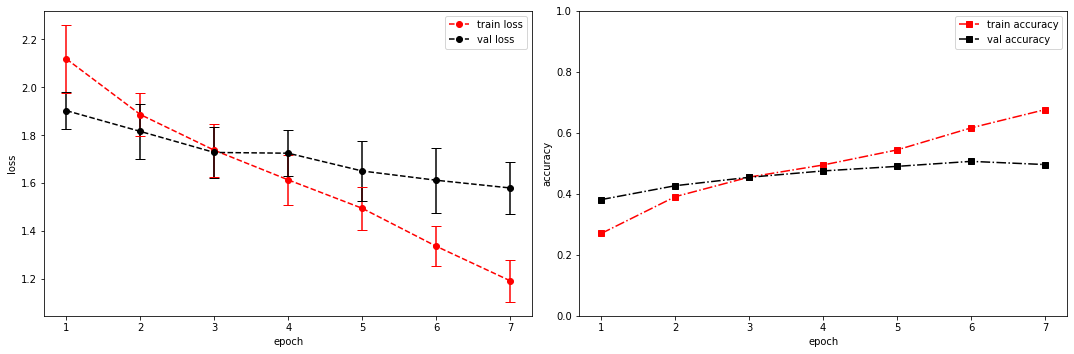

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0, 0.5]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─ReL

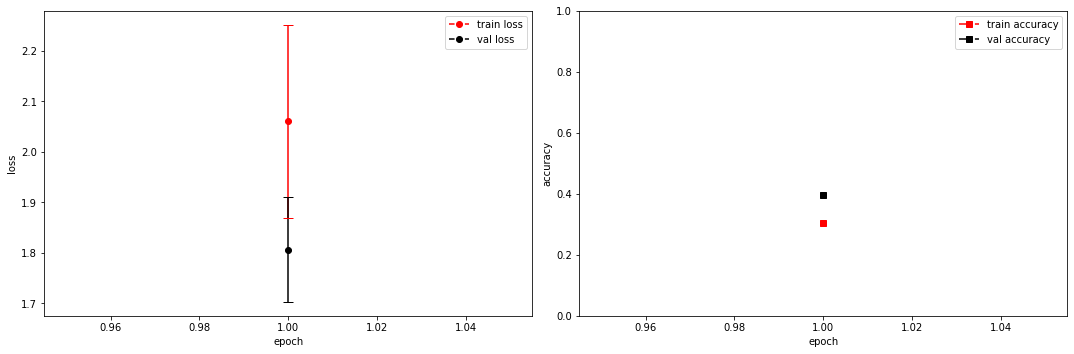

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.8101 +/- 0.0000,  accuracy: 0.021484375, time elapsed = 0.26955318450927734s
Epoch [2/100], step [17/84],  Loss: 1.7697 +/- 0.0874,  accuracy: 0.41015625, time elapsed = 0.9114301204681396s
Epoch [2/100], step [33/84],  Loss: 1.7153 +/- 0.0847,  accuracy: 0.447265625, time elapsed = 0.883094310760498s
Epoch [2/100], step [49/84],  Loss: 1.7781 +/- 0.1291,  accuracy: 0.42578125, time elapsed = 0.9294469356536865s
Epoch [2/100], step [65/84],  Loss: 1.7494 +/- 0.1822,  accuracy: 0.4375, time elapsed = 0.9220247268676758s
Epoch [2/100], step [81/84],  Loss: 1.7127 +/- 0.0655,  accuracy: 0.4423828125, time elapsed = 0.8924112319946289s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.4333395487600224,  precision = 0.4333395487600224 recall = 0.4333395487600224 f1 = 0.4333395487600224 ::: val: acc = 0.43475018642803875,  precision = 0.43475018642803875 recall = 0.43475018642803875 time elapsed = 

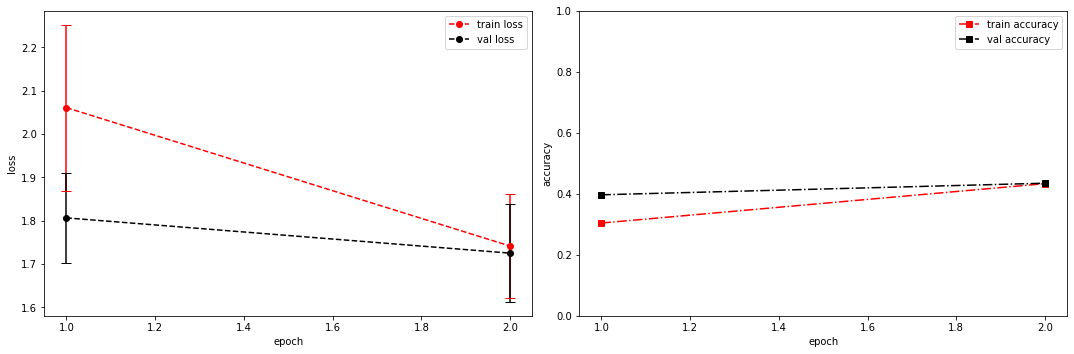

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.5576 +/- 0.0000,  accuracy: 0.03125, time elapsed = 0.2845032215118408s
Epoch [3/100], step [17/84],  Loss: 1.5396 +/- 0.0839,  accuracy: 0.5078125, time elapsed = 0.897803783416748s
Epoch [3/100], step [33/84],  Loss: 1.5057 +/- 0.0877,  accuracy: 0.54296875, time elapsed = 0.9212765693664551s
Epoch [3/100], step [49/84],  Loss: 1.5213 +/- 0.1290,  accuracy: 0.515625, time elapsed = 0.9146976470947266s
Epoch [3/100], step [65/84],  Loss: 1.4959 +/- 0.0988,  accuracy: 0.5380859375, time elapsed = 0.9126060009002686s
Epoch [3/100], step [81/84],  Loss: 1.5160 +/- 0.1072,  accuracy: 0.5302734375, time elapsed = 0.8978469371795654s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5256386350922991,  precision = 0.5256386350922991 recall = 0.5256386350922991 f1 = 0.5256386350922991 ::: val: acc = 0.453392990305742,  precision = 0.453392990305742 recall = 0.453392990305742 time elapsed = 6.4315695

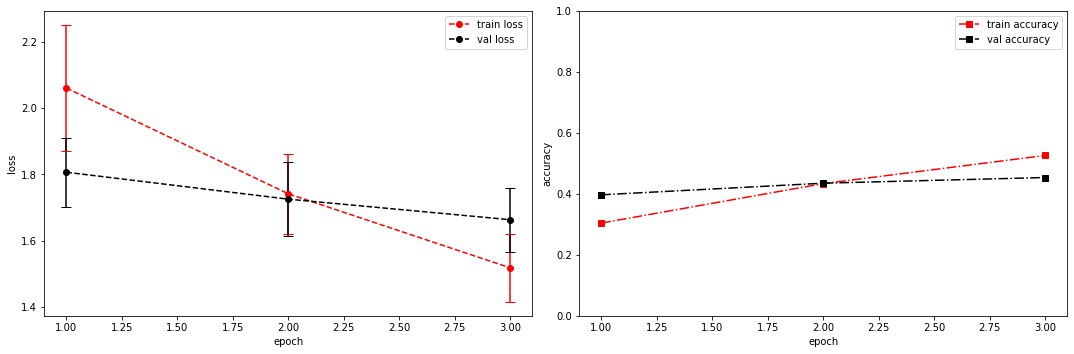

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.3374 +/- 0.0000,  accuracy: 0.03515625, time elapsed = 0.2812790870666504s
Epoch [4/100], step [17/84],  Loss: 1.3029 +/- 0.1175,  accuracy: 0.62890625, time elapsed = 0.9109504222869873s
Epoch [4/100], step [33/84],  Loss: 1.3291 +/- 0.0924,  accuracy: 0.6025390625, time elapsed = 0.9165120124816895s
Epoch [4/100], step [49/84],  Loss: 1.2807 +/- 0.0994,  accuracy: 0.626953125, time elapsed = 0.8907604217529297s
Epoch [4/100], step [65/84],  Loss: 1.3048 +/- 0.1100,  accuracy: 0.6142578125, time elapsed = 0.8876888751983643s
Epoch [4/100], step [81/84],  Loss: 1.2974 +/- 0.1011,  accuracy: 0.6103515625, time elapsed = 0.8943698406219482s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6142084654111505,  precision = 0.6142084654111505 recall = 0.6142084654111505 f1 = 0.6142084654111505 ::: val: acc = 0.49217002237136465,  precision = 0.49217002237136465 recall = 0.49217002237136465 time ela

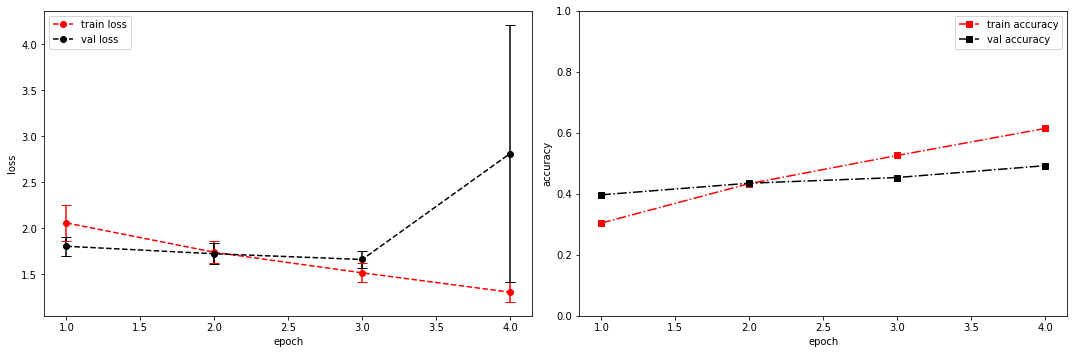

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.2328 +/- 0.0000,  accuracy: 0.0419921875, time elapsed = 0.2879824638366699s
Epoch [5/100], step [17/84],  Loss: 1.1030 +/- 0.0699,  accuracy: 0.6943359375, time elapsed = 0.933197021484375s
Epoch [5/100], step [33/84],  Loss: 1.0812 +/- 0.1110,  accuracy: 0.71484375, time elapsed = 0.9206318855285645s
Epoch [5/100], step [49/84],  Loss: 1.1103 +/- 0.0790,  accuracy: 0.6767578125, time elapsed = 0.9037368297576904s
Epoch [5/100], step [65/84],  Loss: 1.1257 +/- 0.0897,  accuracy: 0.6796875, time elapsed = 0.9299111366271973s
Epoch [5/100], step [81/84],  Loss: 1.0802 +/- 0.0863,  accuracy: 0.7060546875, time elapsed = 0.9089899063110352s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6936416184971098,  precision = 0.6936416184971098 recall = 0.6936416184971098 f1 = 0.6936416184971098 ::: val: acc = 0.5197613721103654,  precision = 0.5197613721103654 recall = 0.5197613721103654 time elapsed

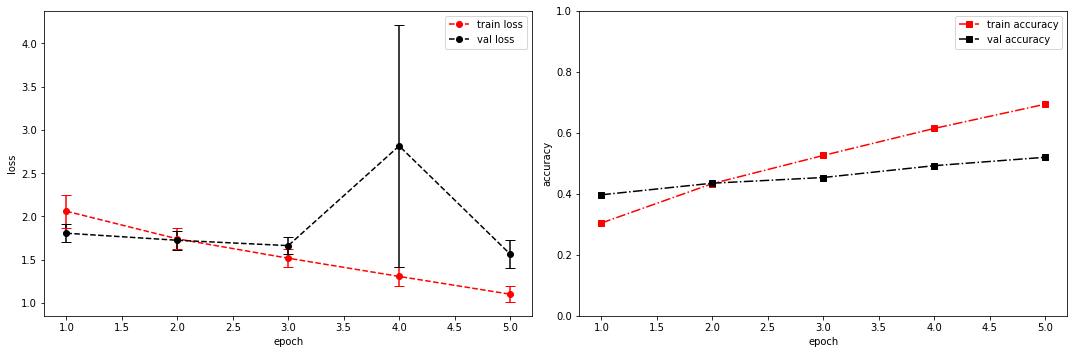

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.0105 +/- 0.0000,  accuracy: 0.0517578125, time elapsed = 0.2684168815612793s
Epoch [6/100], step [17/84],  Loss: 0.8985 +/- 0.0648,  accuracy: 0.79296875, time elapsed = 0.8997817039489746s
Epoch [6/100], step [33/84],  Loss: 0.8810 +/- 0.0859,  accuracy: 0.798828125, time elapsed = 0.9054632186889648s
Epoch [6/100], step [49/84],  Loss: 0.8851 +/- 0.0823,  accuracy: 0.78515625, time elapsed = 0.8880071640014648s
Epoch [6/100], step [65/84],  Loss: 0.8757 +/- 0.0677,  accuracy: 0.791015625, time elapsed = 0.8779246807098389s
Epoch [6/100], step [81/84],  Loss: 0.9038 +/- 0.0919,  accuracy: 0.779296875, time elapsed = 0.8869352340698242s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.7881782584374417,  precision = 0.7881782584374417 recall = 0.7881782584374417 f1 = 0.7881782584374417 ::: val: acc = 0.5190156599552572,  precision = 0.5190156599552572 recall = 0.5190156599552572 time elapsed 

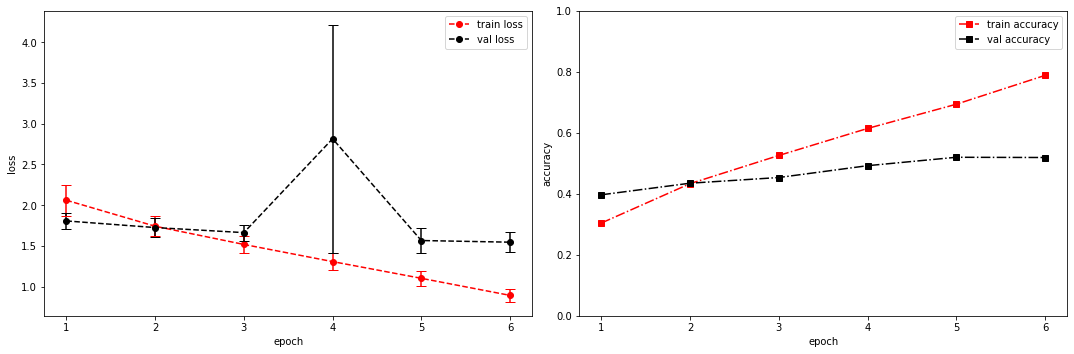

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.7221 +/- 0.0000,  accuracy: 0.0546875, time elapsed = 0.3019981384277344s
Epoch [7/100], step [17/84],  Loss: 0.7532 +/- 0.0762,  accuracy: 0.84765625, time elapsed = 0.9438619613647461s
Epoch [7/100], step [33/84],  Loss: 0.7326 +/- 0.0665,  accuracy: 0.85546875, time elapsed = 0.9419896602630615s
Epoch [7/100], step [49/84],  Loss: 0.7228 +/- 0.0655,  accuracy: 0.84765625, time elapsed = 0.9315800666809082s
Epoch [7/100], step [65/84],  Loss: 0.6869 +/- 0.0722,  accuracy: 0.8642578125, time elapsed = 0.9277520179748535s
Epoch [7/100], step [81/84],  Loss: 0.7302 +/- 0.0673,  accuracy: 0.86328125, time elapsed = 0.9160981178283691s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.8560507178817826,  precision = 0.8560507178817826 recall = 0.8560507178817826 f1 = 0.8560507178817824 ::: val: acc = 0.5234899328859061,  precision = 0.5234899328859061 recall = 0.5234899328859061 time elapsed = 6.

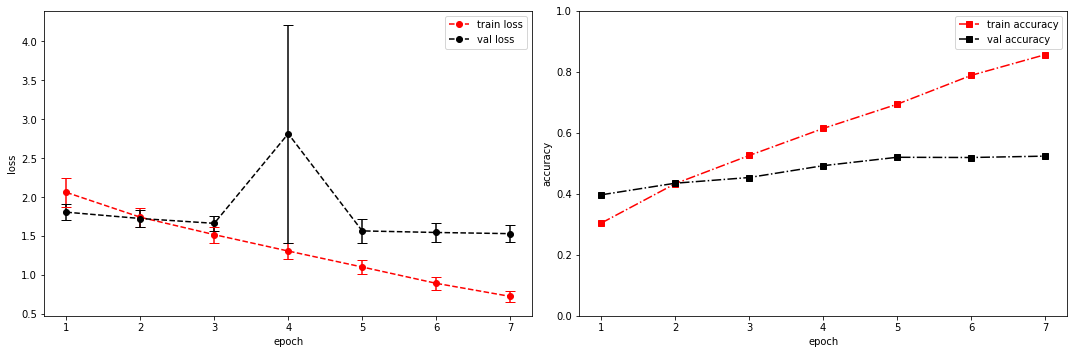

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0.1, 0.5]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─R

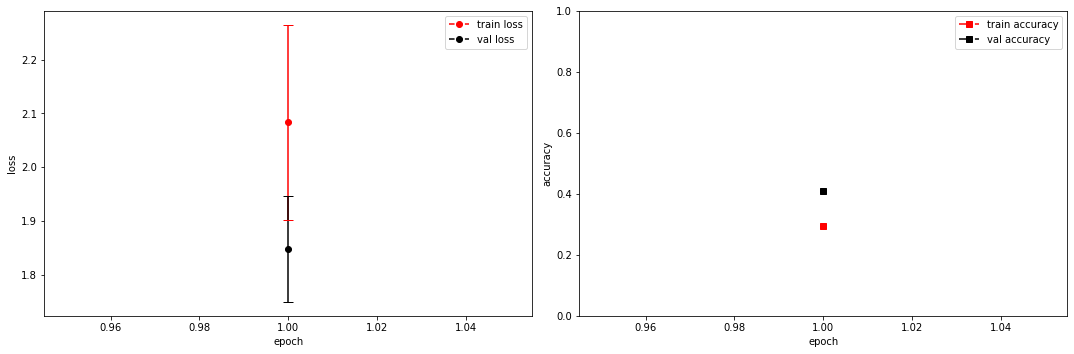

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.8278 +/- 0.0000,  accuracy: 0.0263671875, time elapsed = 0.2653629779815674s
Epoch [2/100], step [17/84],  Loss: 1.7651 +/- 0.0680,  accuracy: 0.4365234375, time elapsed = 0.9046893119812012s
Epoch [2/100], step [33/84],  Loss: 1.8052 +/- 0.1283,  accuracy: 0.4033203125, time elapsed = 0.8949499130249023s
Epoch [2/100], step [49/84],  Loss: 1.7942 +/- 0.1325,  accuracy: 0.4208984375, time elapsed = 0.9038693904876709s
Epoch [2/100], step [65/84],  Loss: 1.7563 +/- 0.0996,  accuracy: 0.427734375, time elapsed = 0.8873260021209717s
Epoch [2/100], step [81/84],  Loss: 1.6993 +/- 0.1185,  accuracy: 0.46484375, time elapsed = 0.8814563751220703s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.43054260674995337,  precision = 0.43054260674995337 recall = 0.43054260674995337 f1 = 0.43054260674995337 ::: val: acc = 0.4750186428038777,  precision = 0.4750186428038777 recall = 0.4750186428038777 time 

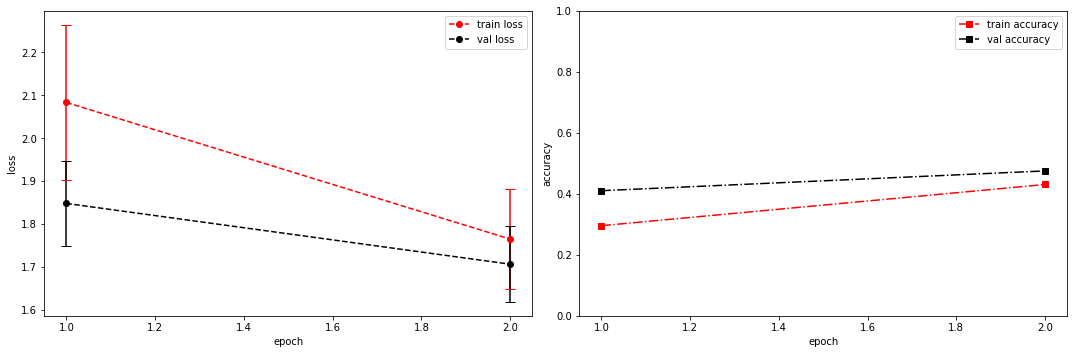

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.4926 +/- 0.0000,  accuracy: 0.03125, time elapsed = 0.28318262100219727s
Epoch [3/100], step [17/84],  Loss: 1.5389 +/- 0.0952,  accuracy: 0.5166015625, time elapsed = 0.9170436859130859s
Epoch [3/100], step [33/84],  Loss: 1.5952 +/- 0.0831,  accuracy: 0.4873046875, time elapsed = 0.9210751056671143s
Epoch [3/100], step [49/84],  Loss: 1.5816 +/- 0.1246,  accuracy: 0.5087890625, time elapsed = 0.8890514373779297s
Epoch [3/100], step [65/84],  Loss: 1.5722 +/- 0.0982,  accuracy: 0.4970703125, time elapsed = 0.9096972942352295s
Epoch [3/100], step [81/84],  Loss: 1.5833 +/- 0.0978,  accuracy: 0.4931640625, time elapsed = 0.933661699295044s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5027037106097334,  precision = 0.5027037106097334 recall = 0.5027037106097334 f1 = 0.5027037106097334 ::: val: acc = 0.45861297539149887,  precision = 0.45861297539149887 recall = 0.45861297539149887 time ela

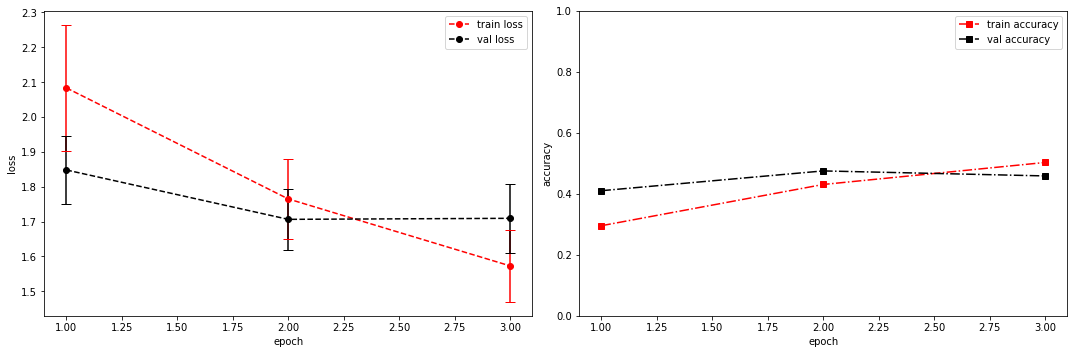

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.4033 +/- 0.0000,  accuracy: 0.0390625, time elapsed = 0.2721872329711914s
Epoch [4/100], step [17/84],  Loss: 1.3764 +/- 0.0797,  accuracy: 0.5830078125, time elapsed = 0.9224684238433838s
Epoch [4/100], step [33/84],  Loss: 1.3358 +/- 0.1208,  accuracy: 0.6328125, time elapsed = 0.8981664180755615s
Epoch [4/100], step [49/84],  Loss: 1.3525 +/- 0.0824,  accuracy: 0.5810546875, time elapsed = 0.900092363357544s
Epoch [4/100], step [65/84],  Loss: 1.3914 +/- 0.0728,  accuracy: 0.583984375, time elapsed = 0.8966593742370605s
Epoch [4/100], step [81/84],  Loss: 1.4006 +/- 0.1362,  accuracy: 0.5556640625, time elapsed = 0.884537935256958s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5864255081111318,  precision = 0.5864255081111318 recall = 0.5864255081111318 f1 = 0.5864255081111318 ::: val: acc = 0.48322147651006714,  precision = 0.48322147651006714 recall = 0.48322147651006714 time elapsed

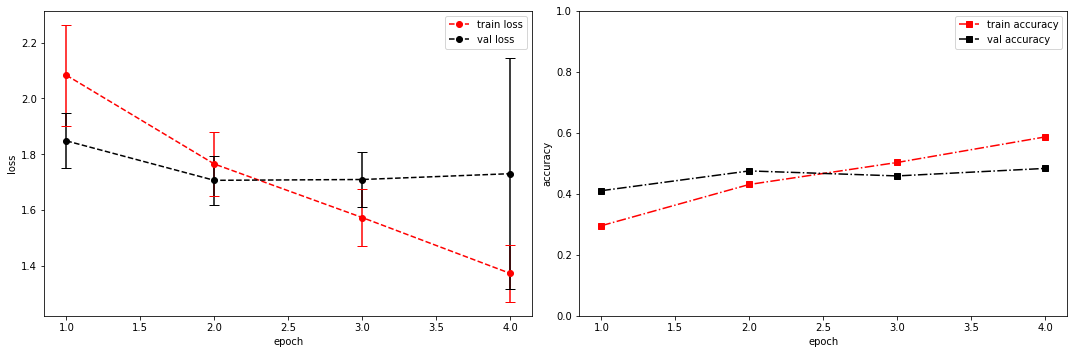

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.1611 +/- 0.0000,  accuracy: 0.041015625, time elapsed = 0.2765786647796631s
Epoch [5/100], step [17/84],  Loss: 1.2192 +/- 0.0932,  accuracy: 0.6591796875, time elapsed = 0.9470434188842773s
Epoch [5/100], step [33/84],  Loss: 1.1564 +/- 0.1201,  accuracy: 0.6953125, time elapsed = 0.8943462371826172s
Epoch [5/100], step [49/84],  Loss: 1.1478 +/- 0.0963,  accuracy: 0.6728515625, time elapsed = 0.8988924026489258s
Epoch [5/100], step [65/84],  Loss: 1.1819 +/- 0.0756,  accuracy: 0.6630859375, time elapsed = 0.8870956897735596s
Epoch [5/100], step [81/84],  Loss: 1.1749 +/- 0.0731,  accuracy: 0.6904296875, time elapsed = 0.896651029586792s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6764870408353534,  precision = 0.6764870408353534 recall = 0.6764870408353534 f1 = 0.6764870408353534 ::: val: acc = 0.4780014914243102,  precision = 0.4780014914243102 recall = 0.4780014914243102 time elapse

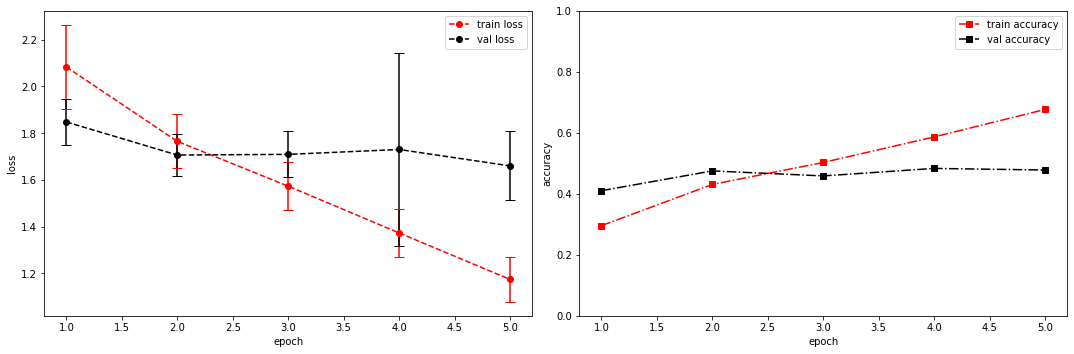

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 0.8357 +/- 0.0000,  accuracy: 0.052734375, time elapsed = 0.2747485637664795s
Epoch [6/100], step [17/84],  Loss: 1.0055 +/- 0.0646,  accuracy: 0.75, time elapsed = 0.8873465061187744s
Epoch [6/100], step [33/84],  Loss: 0.9784 +/- 0.1093,  accuracy: 0.7451171875, time elapsed = 0.9172241687774658s
Epoch [6/100], step [49/84],  Loss: 0.9884 +/- 0.0878,  accuracy: 0.7548828125, time elapsed = 0.8966324329376221s
Epoch [6/100], step [65/84],  Loss: 1.0292 +/- 0.0689,  accuracy: 0.7490234375, time elapsed = 0.9314708709716797s
Epoch [6/100], step [81/84],  Loss: 1.0059 +/- 0.0685,  accuracy: 0.7353515625, time elapsed = 0.9143383502960205s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.7488346074958045,  precision = 0.7488346074958045 recall = 0.7488346074958045 f1 = 0.7488346074958045 ::: val: acc = 0.5048471290082028,  precision = 0.5048471290082028 recall = 0.5048471290082028 time elapsed = 

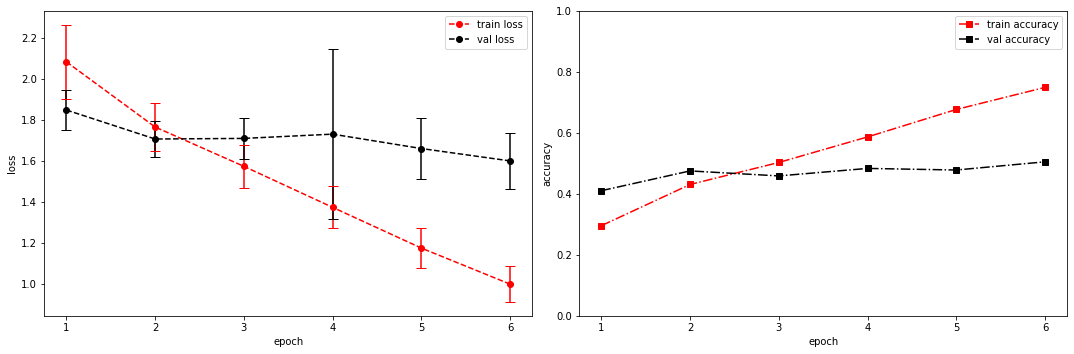

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 0.8611 +/- 0.0000,  accuracy: 0.0517578125, time elapsed = 0.2787313461303711s
Epoch [7/100], step [17/84],  Loss: 0.8340 +/- 0.0751,  accuracy: 0.828125, time elapsed = 0.9429538249969482s
Epoch [7/100], step [33/84],  Loss: 0.7910 +/- 0.0669,  accuracy: 0.8466796875, time elapsed = 0.9123847484588623s
Epoch [7/100], step [49/84],  Loss: 0.8003 +/- 0.0701,  accuracy: 0.828125, time elapsed = 0.8963272571563721s
Epoch [7/100], step [65/84],  Loss: 0.8218 +/- 0.0818,  accuracy: 0.8076171875, time elapsed = 0.8763878345489502s
Epoch [7/100], step [81/84],  Loss: 0.8074 +/- 0.0765,  accuracy: 0.83203125, time elapsed = 0.8882207870483398s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.8269625209770651,  precision = 0.8269625209770651 recall = 0.8269625209770651 f1 = 0.8269625209770651 ::: val: acc = 0.5123042505592841,  precision = 0.5123042505592841 recall = 0.5123042505592841 time elapsed = 6

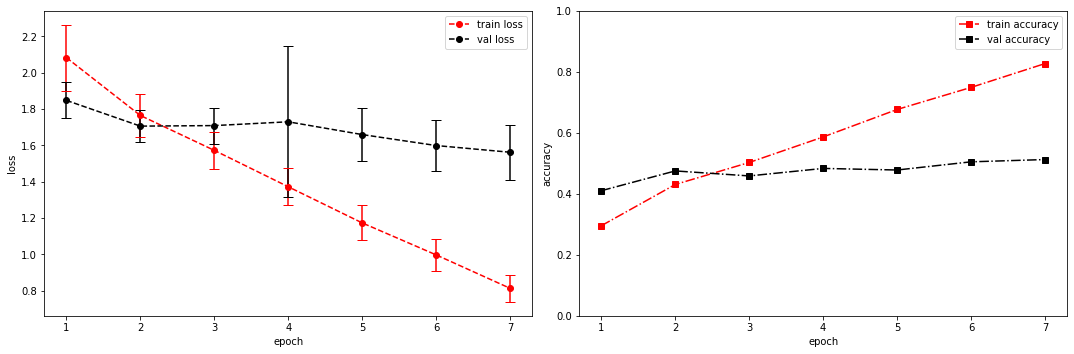

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0.25, 0.5]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─

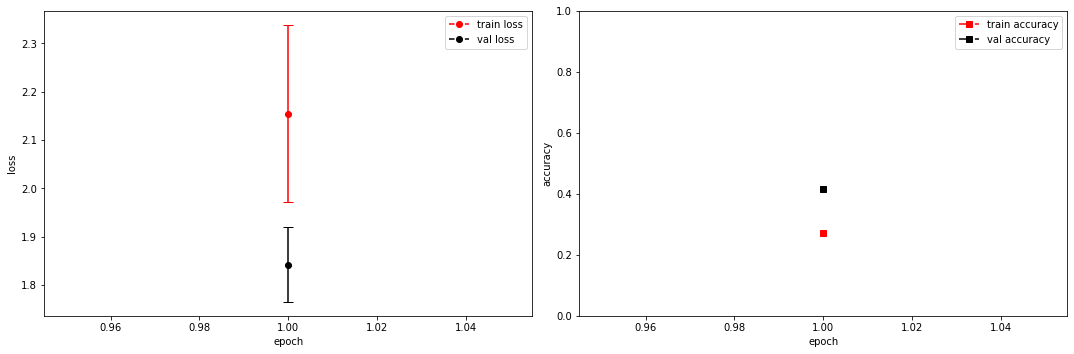

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.8025 +/- 0.0000,  accuracy: 0.0224609375, time elapsed = 0.2815206050872803s
Epoch [2/100], step [17/84],  Loss: 1.8960 +/- 0.0990,  accuracy: 0.361328125, time elapsed = 0.8979277610778809s
Epoch [2/100], step [33/84],  Loss: 1.8631 +/- 0.1157,  accuracy: 0.3828125, time elapsed = 0.8889589309692383s
Epoch [2/100], step [49/84],  Loss: 1.8811 +/- 0.0876,  accuracy: 0.3671875, time elapsed = 0.889763355255127s
Epoch [2/100], step [65/84],  Loss: 1.8628 +/- 0.1135,  accuracy: 0.3818359375, time elapsed = 0.8898417949676514s
Epoch [2/100], step [81/84],  Loss: 1.8184 +/- 0.0776,  accuracy: 0.400390625, time elapsed = 0.8865888118743896s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.3803841133693828,  precision = 0.3803841133693828 recall = 0.3803841133693828 f1 = 0.3803841133693828 ::: val: acc = 0.465324384787472,  precision = 0.465324384787472 recall = 0.465324384787472 time elapsed = 6.3

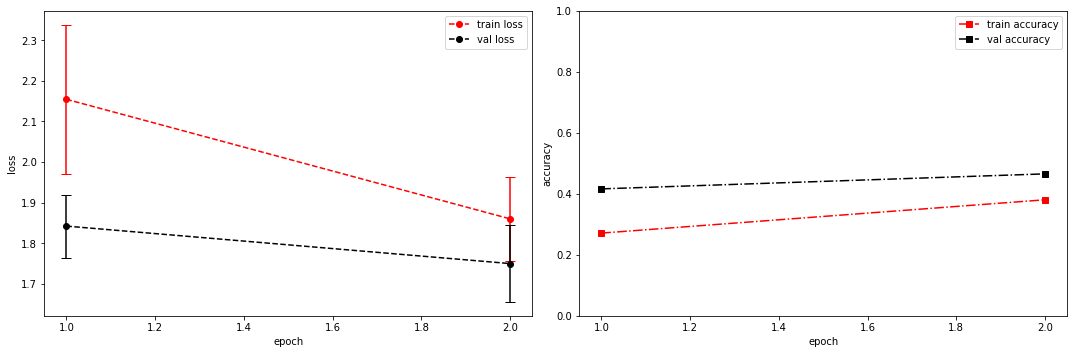

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.6866 +/- 0.0000,  accuracy: 0.029296875, time elapsed = 0.29049110412597656s
Epoch [3/100], step [17/84],  Loss: 1.7177 +/- 0.0859,  accuracy: 0.435546875, time elapsed = 0.8936483860015869s
Epoch [3/100], step [33/84],  Loss: 1.7270 +/- 0.0920,  accuracy: 0.4248046875, time elapsed = 0.9174115657806396s
Epoch [3/100], step [49/84],  Loss: 1.6557 +/- 0.0879,  accuracy: 0.4501953125, time elapsed = 0.9085030555725098s
Epoch [3/100], step [65/84],  Loss: 1.7493 +/- 0.0871,  accuracy: 0.419921875, time elapsed = 0.9027671813964844s
Epoch [3/100], step [81/84],  Loss: 1.6926 +/- 0.1133,  accuracy: 0.44140625, time elapsed = 0.8911924362182617s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.4359500279694201,  precision = 0.4359500279694201 recall = 0.4359500279694201 f1 = 0.4359500279694201 ::: val: acc = 0.47874720357941836,  precision = 0.47874720357941836 recall = 0.47874720357941836 time el

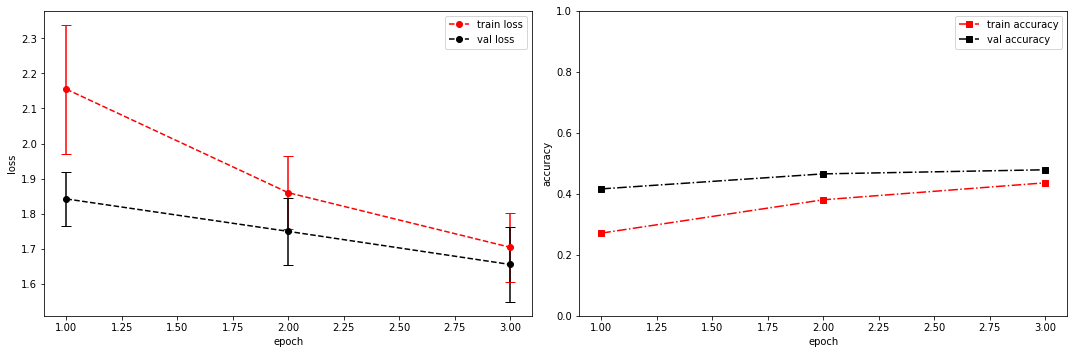

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.5314 +/- 0.0000,  accuracy: 0.033203125, time elapsed = 0.28076672554016113s
Epoch [4/100], step [17/84],  Loss: 1.5871 +/- 0.0629,  accuracy: 0.513671875, time elapsed = 0.9171373844146729s
Epoch [4/100], step [33/84],  Loss: 1.5741 +/- 0.1115,  accuracy: 0.50390625, time elapsed = 0.9108750820159912s
Epoch [4/100], step [49/84],  Loss: 1.5244 +/- 0.0858,  accuracy: 0.517578125, time elapsed = 0.9012515544891357s
Epoch [4/100], step [65/84],  Loss: 1.5789 +/- 0.0907,  accuracy: 0.4873046875, time elapsed = 0.9082884788513184s
Epoch [4/100], step [81/84],  Loss: 1.5418 +/- 0.0907,  accuracy: 0.5224609375, time elapsed = 0.8913118839263916s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5077382062278576,  precision = 0.5077382062278576 recall = 0.5077382062278576 f1 = 0.5077382062278576 ::: val: acc = 0.49962714392244595,  precision = 0.49962714392244595 recall = 0.49962714392244595 time el

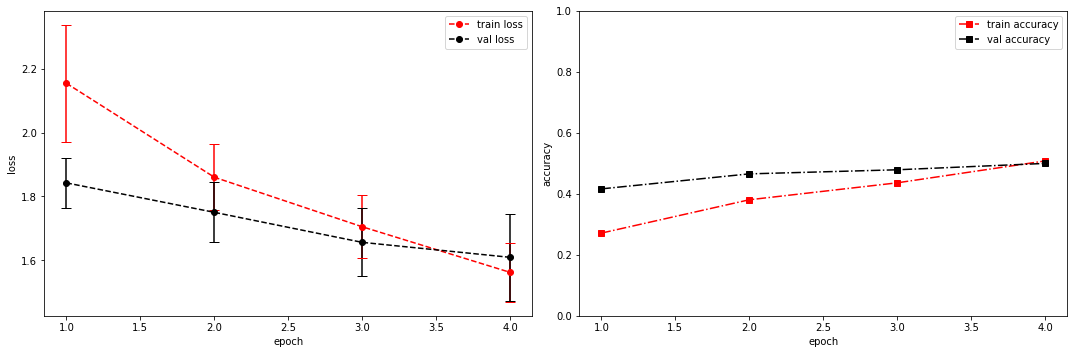

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.4021 +/- 0.0000,  accuracy: 0.033203125, time elapsed = 0.28449201583862305s
Epoch [5/100], step [17/84],  Loss: 1.4663 +/- 0.0736,  accuracy: 0.5263671875, time elapsed = 0.9018969535827637s
Epoch [5/100], step [33/84],  Loss: 1.4281 +/- 0.1050,  accuracy: 0.552734375, time elapsed = 0.8997886180877686s
Epoch [5/100], step [49/84],  Loss: 1.3935 +/- 0.0876,  accuracy: 0.5908203125, time elapsed = 0.8879659175872803s
Epoch [5/100], step [65/84],  Loss: 1.4141 +/- 0.0954,  accuracy: 0.572265625, time elapsed = 0.9003915786743164s
Epoch [5/100], step [81/84],  Loss: 1.3758 +/- 0.1037,  accuracy: 0.587890625, time elapsed = 0.8911426067352295s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5651687488346075,  precision = 0.5651687488346075 recall = 0.5651687488346075 f1 = 0.5651687488346075 ::: val: acc = 0.5137956748695004,  precision = 0.5137956748695004 recall = 0.5137956748695004 time elap

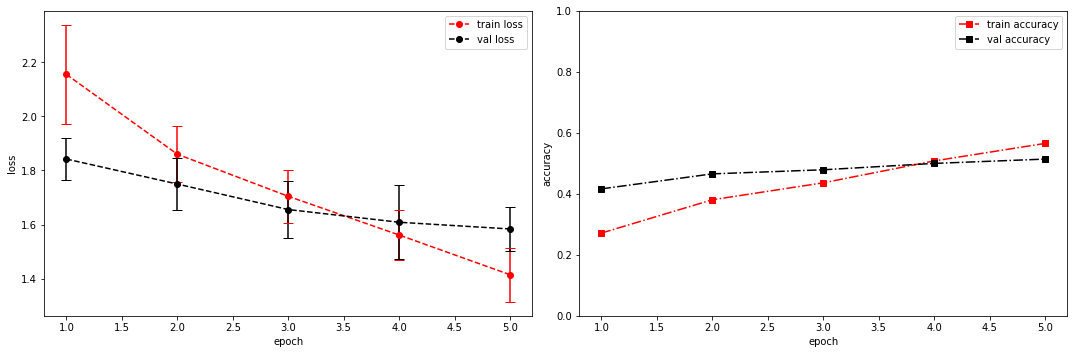

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.3998 +/- 0.0000,  accuracy: 0.037109375, time elapsed = 0.27897214889526367s
Epoch [6/100], step [17/84],  Loss: 1.1874 +/- 0.0584,  accuracy: 0.6787109375, time elapsed = 0.9492816925048828s
Epoch [6/100], step [33/84],  Loss: 1.2174 +/- 0.1234,  accuracy: 0.6357421875, time elapsed = 0.9256975650787354s
Epoch [6/100], step [49/84],  Loss: 1.2052 +/- 0.0962,  accuracy: 0.6572265625, time elapsed = 0.9115822315216064s
Epoch [6/100], step [65/84],  Loss: 1.2170 +/- 0.0971,  accuracy: 0.6435546875, time elapsed = 0.884749174118042s
Epoch [6/100], step [81/84],  Loss: 1.2468 +/- 0.1070,  accuracy: 0.6328125, time elapsed = 0.9097330570220947s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.6494499347380198,  precision = 0.6494499347380198 recall = 0.6494499347380198 f1 = 0.6494499347380198 ::: val: acc = 0.4899328859060403,  precision = 0.4899328859060403 recall = 0.4899328859060403 time elaps

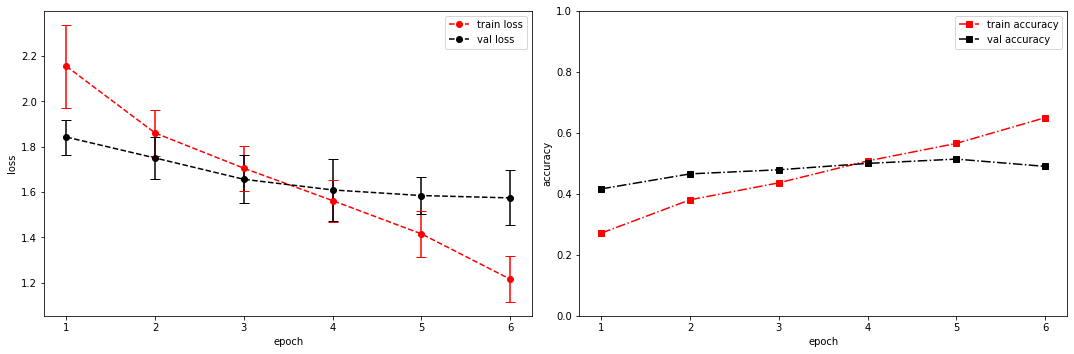

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 1.1233 +/- 0.0000,  accuracy: 0.044921875, time elapsed = 0.2939417362213135s
Epoch [7/100], step [17/84],  Loss: 1.0632 +/- 0.0809,  accuracy: 0.71875, time elapsed = 0.9125745296478271s
Epoch [7/100], step [33/84],  Loss: 1.0784 +/- 0.0840,  accuracy: 0.716796875, time elapsed = 0.8800351619720459s
Epoch [7/100], step [49/84],  Loss: 1.0442 +/- 0.0954,  accuracy: 0.70703125, time elapsed = 0.8880364894866943s
Epoch [7/100], step [65/84],  Loss: 1.0742 +/- 0.0732,  accuracy: 0.705078125, time elapsed = 0.8951942920684814s
Epoch [7/100], step [81/84],  Loss: 1.0916 +/- 0.0883,  accuracy: 0.70703125, time elapsed = 0.8918123245239258s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.7109826589595376,  precision = 0.7109826589595376 recall = 0.7109826589595376 f1 = 0.7109826589595376 ::: val: acc = 0.5160328113348247,  precision = 0.5160328113348247 recall = 0.5160328113348247 time elapsed = 6.3

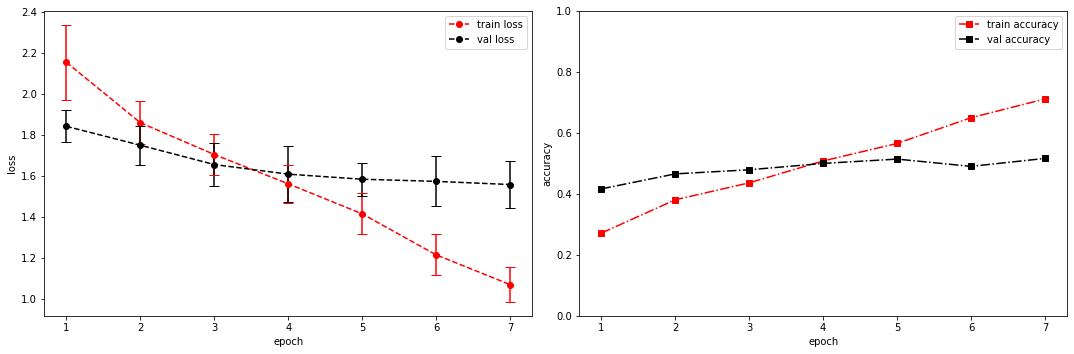

model saved
stopping early
(1, 13, 517)
running model: drop_prob = [0.5, 0.5]
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 16, 13, 258]         --
|    └─Sequential: 2-1                   [-1, 16, 13, 258]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 13, 517]         160
|    |    └─ReLU: 3-2                    [-1, 16, 13, 517]         --
|    |    └─MaxPool2d: 3-3               [-1, 16, 13, 258]         --
|    |    └─BatchNorm2d: 3-4             [-1, 16, 13, 258]         32
├─ConvBlock: 1-2                         [-1, 32, 13, 129]         --
|    └─Sequential: 2-2                   [-1, 32, 13, 129]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 13, 258]         4,640
|    |    └─R

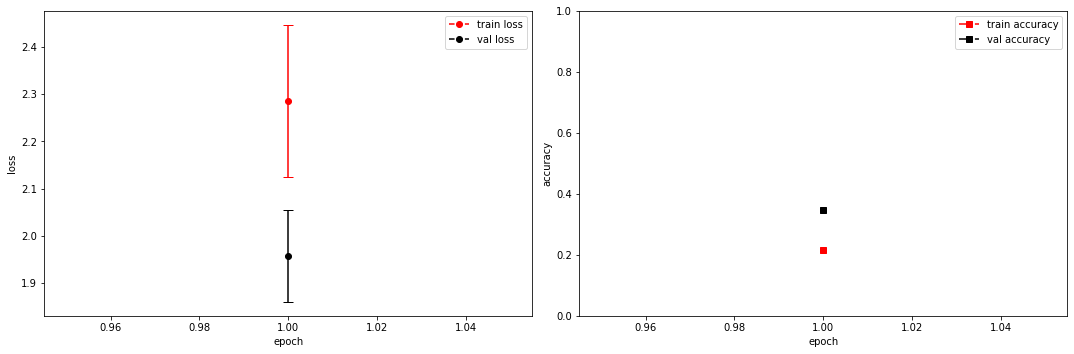

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 2.0998 +/- 0.0000,  accuracy: 0.0166015625, time elapsed = 0.2652313709259033s
Epoch [2/100], step [17/84],  Loss: 2.0938 +/- 0.1189,  accuracy: 0.2958984375, time elapsed = 0.900090217590332s
Epoch [2/100], step [33/84],  Loss: 2.0252 +/- 0.1247,  accuracy: 0.310546875, time elapsed = 0.8859529495239258s
Epoch [2/100], step [49/84],  Loss: 2.0605 +/- 0.1154,  accuracy: 0.3076171875, time elapsed = 0.9007594585418701s
Epoch [2/100], step [65/84],  Loss: 2.0633 +/- 0.1097,  accuracy: 0.294921875, time elapsed = 0.8983805179595947s
Epoch [2/100], step [81/84],  Loss: 2.0360 +/- 0.1110,  accuracy: 0.2958984375, time elapsed = 0.8909831047058105s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.3016968114861085,  precision = 0.3016968114861085 recall = 0.3016968114861085 f1 = 0.3016968114861085 ::: val: acc = 0.4116331096196868,  precision = 0.4116331096196868 recall = 0.4116331096196868 time elap

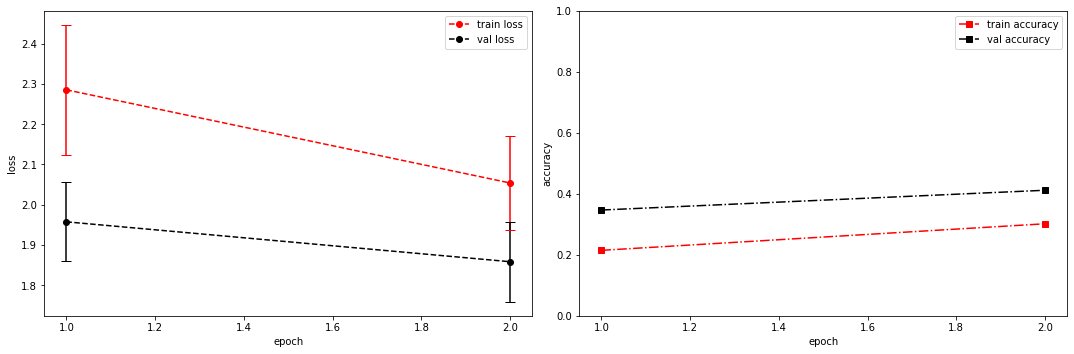

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 2.0300 +/- 0.0000,  accuracy: 0.0166015625, time elapsed = 0.2795069217681885s
Epoch [3/100], step [17/84],  Loss: 1.9577 +/- 0.1188,  accuracy: 0.333984375, time elapsed = 0.9046280384063721s
Epoch [3/100], step [33/84],  Loss: 1.9527 +/- 0.1297,  accuracy: 0.3544921875, time elapsed = 0.916064977645874s
Epoch [3/100], step [49/84],  Loss: 1.9409 +/- 0.0918,  accuracy: 0.3330078125, time elapsed = 0.8762836456298828s
Epoch [3/100], step [65/84],  Loss: 1.9000 +/- 0.1470,  accuracy: 0.369140625, time elapsed = 0.8890860080718994s
Epoch [3/100], step [81/84],  Loss: 1.9355 +/- 0.1135,  accuracy: 0.35546875, time elapsed = 0.8918516635894775s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.348312511653925,  precision = 0.348312511653925 recall = 0.348312511653925 f1 = 0.348312511653925 ::: val: acc = 0.39373601789709173,  precision = 0.39373601789709173 recall = 0.39373601789709173 time elapsed

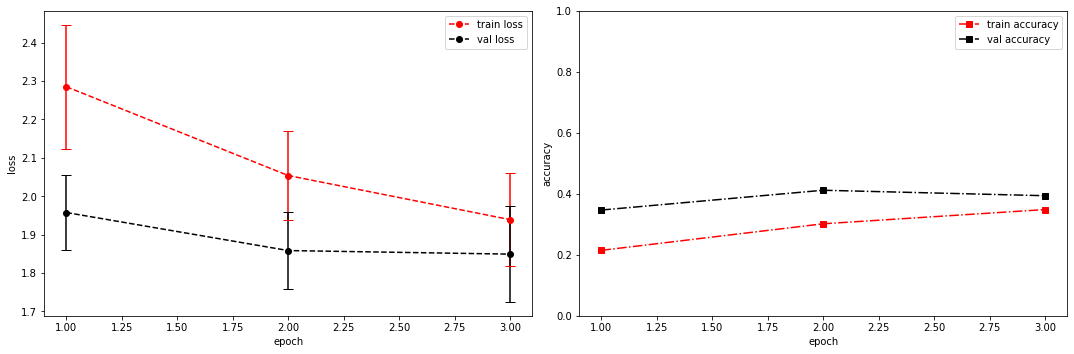

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.9587 +/- 0.0000,  accuracy: 0.021484375, time elapsed = 0.27907800674438477s
Epoch [4/100], step [17/84],  Loss: 1.8320 +/- 0.0905,  accuracy: 0.3818359375, time elapsed = 0.8830575942993164s
Epoch [4/100], step [33/84],  Loss: 1.8461 +/- 0.0952,  accuracy: 0.3837890625, time elapsed = 0.8842003345489502s
Epoch [4/100], step [49/84],  Loss: 1.8146 +/- 0.1126,  accuracy: 0.4052734375, time elapsed = 0.8844058513641357s
Epoch [4/100], step [65/84],  Loss: 1.8057 +/- 0.0877,  accuracy: 0.3955078125, time elapsed = 0.9060523509979248s
Epoch [4/100], step [81/84],  Loss: 1.8265 +/- 0.0995,  accuracy: 0.3837890625, time elapsed = 0.8768038749694824s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.3898937162036174,  precision = 0.3898937162036174 recall = 0.3898937162036174 f1 = 0.3898937162036174 ::: val: acc = 0.4407158836689038,  precision = 0.4407158836689038 recall = 0.4407158836689038 time e

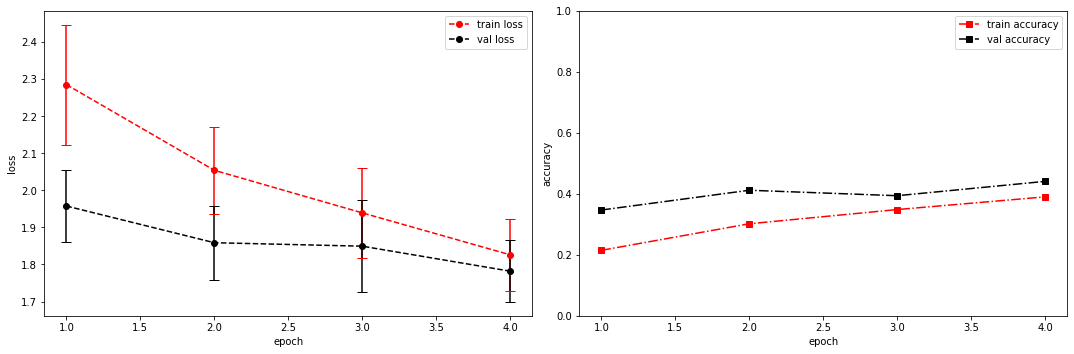

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.5125 +/- 0.0000,  accuracy: 0.0341796875, time elapsed = 0.27588629722595215s
Epoch [5/100], step [17/84],  Loss: 1.6938 +/- 0.1269,  accuracy: 0.4453125, time elapsed = 0.9033260345458984s
Epoch [5/100], step [33/84],  Loss: 1.7314 +/- 0.1131,  accuracy: 0.4443359375, time elapsed = 0.8981356620788574s
Epoch [5/100], step [49/84],  Loss: 1.7213 +/- 0.0879,  accuracy: 0.43359375, time elapsed = 0.9005415439605713s
Epoch [5/100], step [65/84],  Loss: 1.6649 +/- 0.0674,  accuracy: 0.44921875, time elapsed = 0.8865995407104492s
Epoch [5/100], step [81/84],  Loss: 1.7083 +/- 0.0630,  accuracy: 0.4453125, time elapsed = 0.8847126960754395s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.4434085399962707,  precision = 0.4434085399962707 recall = 0.4434085399962707 f1 = 0.4434085399962707 ::: val: acc = 0.4481730052199851,  precision = 0.4481730052199851 recall = 0.4481730052199851 time elapsed = 

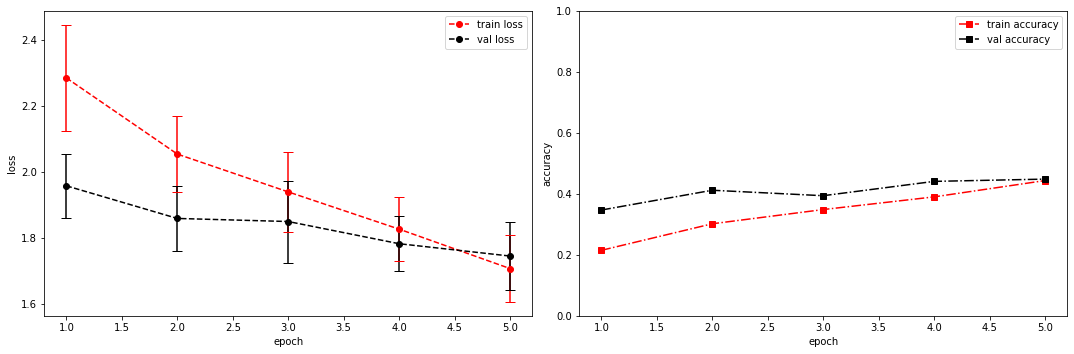

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.6999 +/- 0.0000,  accuracy: 0.0283203125, time elapsed = 0.2752549648284912s
Epoch [6/100], step [17/84],  Loss: 1.6409 +/- 0.1035,  accuracy: 0.4912109375, time elapsed = 0.939267635345459s
Epoch [6/100], step [33/84],  Loss: 1.6272 +/- 0.1419,  accuracy: 0.478515625, time elapsed = 0.9245433807373047s
Epoch [6/100], step [49/84],  Loss: 1.6463 +/- 0.0979,  accuracy: 0.4541015625, time elapsed = 0.8971505165100098s
Epoch [6/100], step [65/84],  Loss: 1.5929 +/- 0.0753,  accuracy: 0.4794921875, time elapsed = 0.8994715213775635s
Epoch [6/100], step [81/84],  Loss: 1.6048 +/- 0.0969,  accuracy: 0.482421875, time elapsed = 0.8745403289794922s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.4788364721238113,  precision = 0.4788364721238113 recall = 0.4788364721238113 f1 = 0.4788364721238113 ::: val: acc = 0.44668158090976884,  precision = 0.44668158090976884 recall = 0.44668158090976884 time e

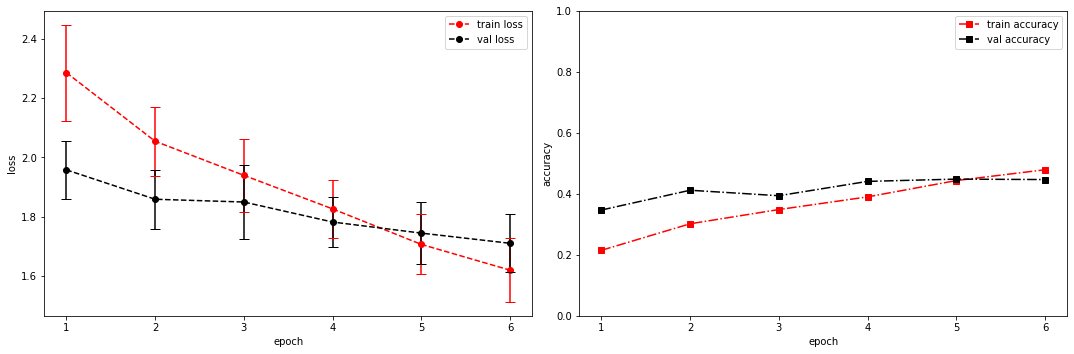

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 1.6085 +/- 0.0000,  accuracy: 0.0302734375, time elapsed = 0.27640485763549805s
Epoch [7/100], step [17/84],  Loss: 1.5087 +/- 0.0663,  accuracy: 0.5302734375, time elapsed = 0.8953473567962646s
Epoch [7/100], step [33/84],  Loss: 1.4732 +/- 0.1271,  accuracy: 0.5390625, time elapsed = 0.895911455154419s
Epoch [7/100], step [49/84],  Loss: 1.4548 +/- 0.0875,  accuracy: 0.5595703125, time elapsed = 0.8647286891937256s
Epoch [7/100], step [65/84],  Loss: 1.5014 +/- 0.0748,  accuracy: 0.5263671875, time elapsed = 0.8910250663757324s
Epoch [7/100], step [81/84],  Loss: 1.4866 +/- 0.0996,  accuracy: 0.5400390625, time elapsed = 0.887934684753418s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5371993287339176,  precision = 0.5371993287339176 recall = 0.5371993287339176 f1 = 0.5371993287339176 ::: val: acc = 0.48396718866517524,  precision = 0.48396718866517524 recall = 0.48396718866517524 time el

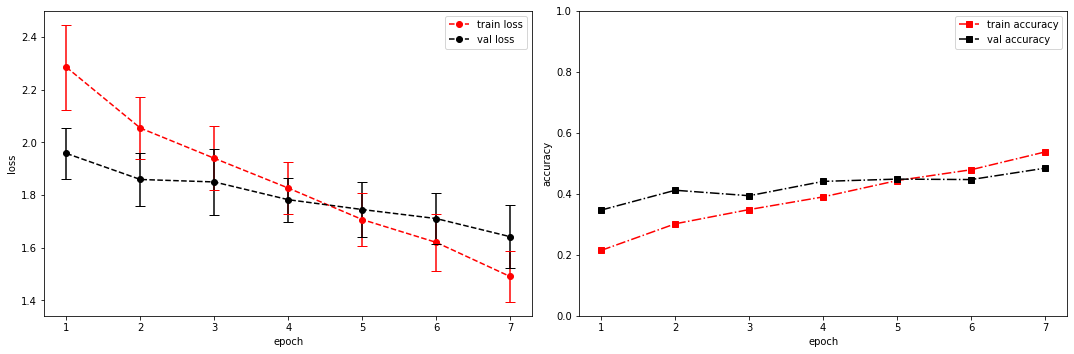

model saved


training epoch:  7
model set to train
Epoch [8/100], step [1/84],  Loss: 1.2503 +/- 0.0000,  accuracy: 0.0419921875, time elapsed = 0.28711867332458496s
Epoch [8/100], step [17/84],  Loss: 1.3226 +/- 0.1102,  accuracy: 0.6162109375, time elapsed = 0.9616189002990723s
Epoch [8/100], step [33/84],  Loss: 1.3368 +/- 0.1050,  accuracy: 0.6123046875, time elapsed = 0.9400269985198975s
Epoch [8/100], step [49/84],  Loss: 1.3704 +/- 0.0771,  accuracy: 0.587890625, time elapsed = 0.9368982315063477s
Epoch [8/100], step [65/84],  Loss: 1.3669 +/- 0.0885,  accuracy: 0.56640625, time elapsed = 0.9456307888031006s
Epoch [8/100], step [81/84],  Loss: 1.3906 +/- 0.1227,  accuracy: 0.5927734375, time elapsed = 0.9633331298828125s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.5940704829386537,  precision = 0.5940704829386537 recall = 0.5940704829386537 f1 = 0.5940704829386537 ::: val: acc = 0.4601043997017151,  precision = 0.4601043997017151 recall = 0.4601043997017151 time ela

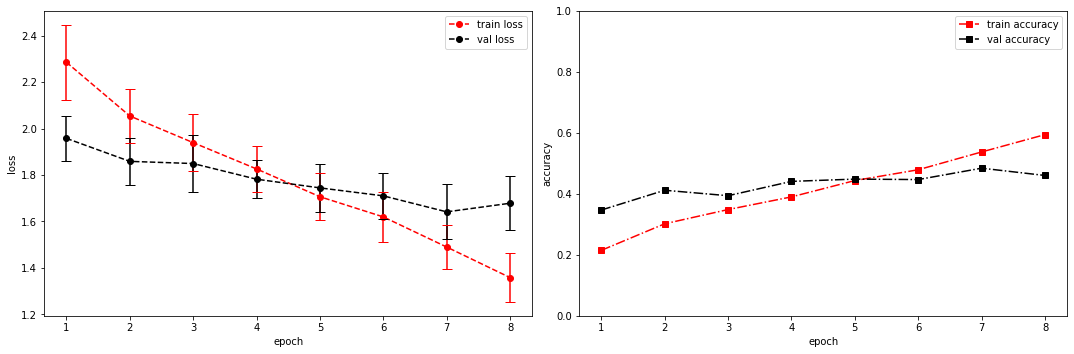

model saved
stopping early


In [9]:


# define initial args dict
args_dict = {
    'filename': filename,
    'num_epochs': 100,
    'interval': 16,
    'lr': 0.0001,
    'batch_size': 64,
    'val_split': 0.2,
    'save_checkpoint': True,
    'checkpoint_path': '/content/drive/MyDrive/ITCS 5156 project/trained_models/CNN tests 4-25/',
    'criterion': torch.nn.CrossEntropyLoss(),
    'patience': 3,
    'min_epochs': 5,
    'buffer': 0.05
}



for i, drop in enumerate(dropouts):
  print(one_mfcc.shape)
  model_args = {
      'conv_paddings': [1, 1, 1, 1, 1],
      'pool_masks': [True, True, True, True, True],
      'pool_kernel_sizes': [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
      'pool_strides': [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
      'channels': [16, 32, 32, 64, 128],
      'dropout_probs': drop
  }
  
  args_dict['model_args'] = model_args

  args_dict['model_id'] = 'Conv_5_layer'
  args_dict['checkpoint_name'] = "CNN_var_drop_{}_{}.pt".format(
      str(drop[0]), str(drop[1])
  )
  
  args_dict['notes'] = dedent("""
    Model trained on 4-25.
    Varying dropout probabilities for linear layers with fixed layer params
    5 conv layers, channels: [16, 32, 32, 64, 128]
    dropout probabilities: {}, {}

    Other params: 
    max epochs = 100
    interval (for output) = 16
    lr = 0.0001
    batch_size = 64
    criterion = CrossEntropyLoss
    No dropout layers in linear portion
    buffer (for early stopping) = 0.05

    Model summary: 
    {}
  """.format(str(drop[0]), str(drop[1]), summary_str))

  args_dict['experiment_params'] = {
      'drop_probs': drop
  }

  # ### output the important stuff before running the model
  # print("=====================================")
  # print(args_dict['model_id'])
  # print(args_dict['checkpoint_name'])
  # print(args_dict['experiment_params'])
  
  # run the pipeline and pray to whatever diety you believe in that I didn't
  # screw this up
  print("running model: drop_prob = {}".format(drop))
  train_model(**args_dict)